# SUPERNOVA NEUTRINO DETECTION

This notebook contains the entire code used in my undergrad final project. It is organized in the following way:

* Curve fitting with supernova simulations by Monte Carlo
* Estimation of analytic function for DUNE's efficiency
* Neutrino-Argon cross section
* Supernova spectrum
* Detection

Before anything, we import all necessary packages and libraries that will be useful

In [2]:
import pandas as pd #For reading csv/txt files
import numpy as np #For general mathematical concepts
import matplotlib.pyplot as plt #For plotting graphs
from scipy.integrate import simps #For integration
from scipy.special import gamma #For special mathematical functions (in this case I use the gamma function)
from scipy import stats #For statistical concepts and tests
from random import choices #For selecting random variables in non pre-existing distributions (gaussian, lognormal,...)
import seaborn as sns #For plotting graphs (But more professional in some moments ;D)
from scipy.optimize import curve_fit #For fitting curves with usual non-linear least squares method
from sklearn.metrics import r2_score #For evluating the R^2 of the fit

## Curve fitting

Here we want to investigate if the analytic equations for describing neutrino emission spectrum by supernova fits well the numerical simulations. That is the first step to validate our simulation, since we'll be using one of these equations to represent our emission spectrum

Equation 1 was proposed in 1989 by Janka

$$ \frac{dN}{dE} = A \frac{E^2}{1+e^{x - \eta}},$$

while equation 2 was proposed in 1980 by Otroshchenko

$$\frac{dN_\nu}{dE} = A \frac{E^2 e^{-\alpha \left(\frac{E}{kT}\right)^2}}{1+ e^\frac{E}{kT}},$$

where $x = E/kT$, $A$ is a normalization constant, $T$ the neutrino emission temperature, $\eta$ is the neutrino degeneracy, which is equivalent to chemical potential in thermodynamics and $\alpha$ is a opacity parameter that represents the effective opacity of the star's interior to neutrinos.

Our fitting starts by retrieving the data of the supernova simulations from the GitHub repository.

In [3]:
url = 'https://raw.githubusercontent.com/PedroHPCintra/TCC/master/DadosSupernovaMonteCarlo.csv'

#Here we use pandas to read the csv file from the url and show the first five lines
data = pd.read_csv(url)
data.head(5)

Simulação 1    Unnamed: 1 Simulação 2 Unnamed: 3  \
0           E          dNdE           E       dNdE   
1           0  7.961524e+53        1.22   1.24e+53   
2           1  6.156184e+54        1.92   2.74e+53   
3         2.5  2.171815e+55        2.74   4.80e+53   
4         4.5  4.897389e+55        3.34   6.54e+53   

                                         Referências  
0  AKAZATO, K. et al. Supernova neutrino light cu...  
1  KEIL, M. T.; RAFFELT, G. G.; JANKA, H.-T. Mont...  
2                                                NaN  
3                                                NaN  
4                                                NaN

We'll be transforming it in an array just to make our work easier

In [4]:
data = np.asarray(data)

In [5]:
#Let's plot the first collum just to see
data[:,0]

array(['E', '0', '1', '2.5', '4.5', '7', '10', '14', '19', '25', '32',
       '40', '48', '58', '68', '80', '95', '115', '145', '185', '235',
       nan, nan, nan, nan, nan, nan, nan], dtype=object)

We've got some 'nan's in our array, and the numbers are listed as strings. So, first, let us define our x data and our y data going from the second element in to the 22nd element. Then, we create an empty list and append the values to it. Finally we transform it in an array.

In [6]:
#Getting only the necessary numbers, i. e. excluding the nans
data_E = data[1:21,0]
data_dNdE = data[1:21,1]

In [7]:
#Appending the numbers into an empty list
E_data = []
dNdE_data = []
for i in range(len(data_E)):
    E_data.append(float(data_E[i]))
    
for i in range(len(data_dNdE)):
    dNdE_data.append(float(data_dNdE[i]))

In [8]:
#Transforming the list into an array
E_data = np.array(E_data)
dNdE_data = np.array(dNdE_data)

In [9]:
#Checking if the array really is only made of the necessary numbers
E_data

array([  0. ,   1. ,   2.5,   4.5,   7. ,  10. ,  14. ,  19. ,  25. ,
        32. ,  40. ,  48. ,  58. ,  68. ,  80. ,  95. , 115. , 145. ,
       185. , 235. ])

Now we have our x and y data, x data is *E_data*, that corresponds to the energy values for the emitted neutrinos. The y data is *dNdE_data*, corresponding to the differential number of neutrinos per energy emitted in that specific energy.

We'll plot these points to see the shape of our spectrum

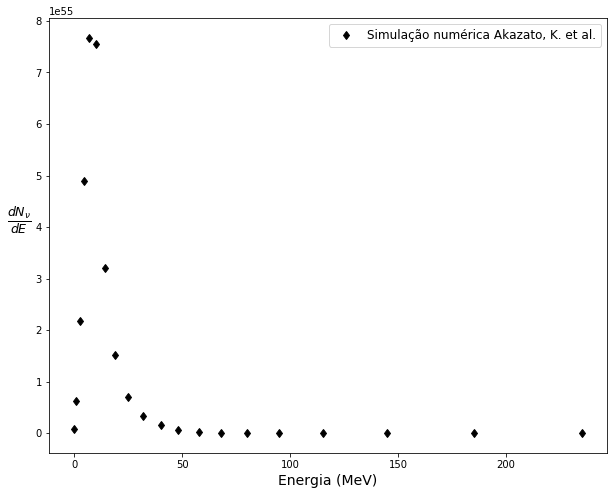

In [10]:
#Plotting the data
plt.figure(figsize=(10,8))
plt.plot(E_data, dNdE_data, 'kd', label = 'Simulação numérica Akazato, K. et al.')
plt.xlabel('Energia (MeV)', fontsize = 14)
plt.ylabel(r'$\frac{dN_\nu}{dE}$', rotation = 0, labelpad = 16, fontsize = 18)
plt.legend(loc='upper right', fontsize = 12)

Now we begin our fitting procedure, the first step is to define our analytic functions as we wrote them

In [13]:
# Defining the energy range
E = np.linspace(0, 250, 1000)

# Analytic function by Otroshchenko
def specNO(E, A, T, a):
    k = 9.617e-2
    return A*(((E**2)*np.exp(-a*(E/(k*T))**2))/(1 + np.exp(E/(k*T))))

# Analytic function by Janka
def specJH(E, A, T, eta):
    k = 9.617e-2
    return A*((E**2)/(1 + np.exp(E/(k*T)-eta)))

The data is ready, the functions are defined. We must only use the *curve_fit* package to fit the curves to the data. For that, we set out initial guess for each parameter and call *curve_fit*. After the fitting we evaluate it using the $R^2$ score.

In [14]:
# Defining initial parameters
initialParameters = np.array([1e54, 1, 1])

# Calling out the curve_fit package, it returns an array of the adjusted parameters (c) and a matrix of the
# covariances (cov)
c, cov = curve_fit(specJH, E_data, dNdE_data, initialParameters)
c2, cov2 = curve_fit(specNO, E_data, dNdE_data, initialParameters)

specJHopt = specJH(E, c[0], c[1], c[2])
specNOopt = specNO(E, c2[0], c2[1], c2[2])

#Evaluation of the fit
print('R^2 test JH:', r2_score(specJH(E_data, c[0], c[1], c[2]), dNdE_data))
print('R^2 test NO:', r2_score(specNO(E_data, c2[0], c2[1], c2[2]), dNdE_data))

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


R^2 test JH: 0.9907596666889269
R^2 test NO: -1.4746406799029727e+107


/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/home/pedroc/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


And of course, we plot them both alongside with the data from the simulation for a better visualization

Text(0.5, 1.0, 'Espectro de emissão de neutrinos na supernova')

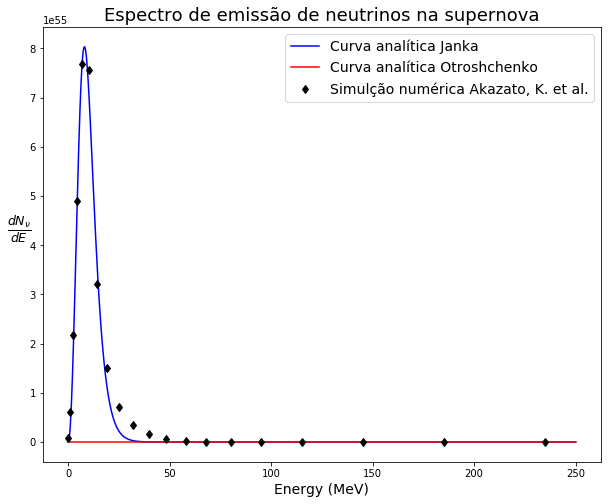

In [15]:
plt.figure(figsize=(10,8))
plt.plot(E, specJHopt, color = 'blue', label = 'Curva analítica Janka')
plt.plot(E, specNOopt, color = 'red', label = 'Curva analítica Otroshchenko')
plt.plot(E_data, dNdE_data, 'kd', label = 'Simulção numérica Akazato, K. et al.')
plt.xlabel('Energy (MeV)', fontsize = 14)
plt.ylabel(r'$\frac{d N_\nu}{dE}$', rotation = 0, fontsize = 18, labelpad=10)
plt.legend(loc = 'upper right', fontsize = 14)
plt.title('Espectro de emissão de neutrinos na supernova', fontsize = 18)

For a second confirmation, let's make everything once again for the second simulation, and check how well does the fitting performs

In [16]:
# Choosing only the necessary values from the csv collums
data_E_2 = data[1:30,2]
data_dNdE_2 = data[1:30,3]

In [17]:
# Getting only the values of each line
E2_data = []
dNdE2_data = []
for i in range(len(data_E_2)):
    E2_data.append(float(data_E_2[i]))
    
for i in range(len(data_dNdE_2)):
    dNdE2_data.append(float(data_dNdE_2[i]))

In [18]:
# Transforming in array
E2_data = np.array(E2_data)
dNdE2_data = np.array(dNdE2_data)

In [19]:
# Defining E range
E2 = np.linspace(0,50,500)

# Defining initial parameters
initialParameters = np.array([1e54, 1, 1])

# Fitting
c3, cov3 = curve_fit(specJH, E2_data, dNdE2_data, initialParameters)
c4, cov4 = curve_fit(specNO, E2_data, dNdE2_data, initialParameters)

specJHopt = specJH(E2, c3[0], c3[1], c3[2])
specNOopt = specNO(E2, c4[0], c4[1], c4[2])

# Evaluation
print('R^2 test JH:', r2_score(specJH(E2_data, c3[0], c3[1], c3[2]), dNdE2_data))
print('R^2 test NO:', r2_score(specNO(E2_data, c4[0], c4[1], c4[2]), dNdE2_data))

R^2 test JH: 0.9990181451394139
R^2 test NO: -1.4809897193044917e+152


/home/pedroc/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5, 1.0, 'Espectro de emissão de neutrinos na supernova')

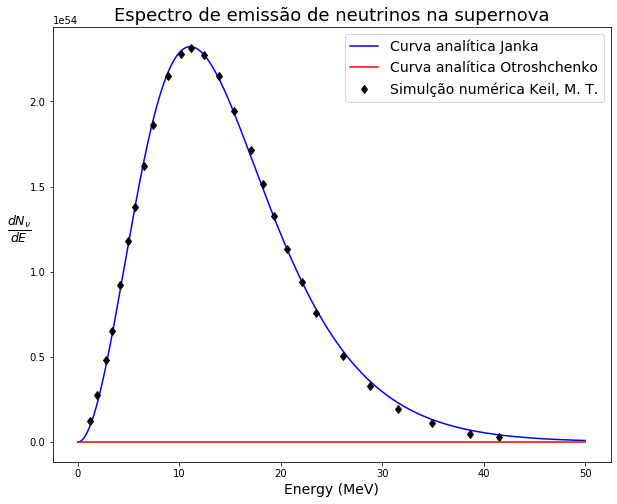

In [20]:
# Final plot
plt.figure(figsize=(10,8))
plt.plot(E2, specJHopt, color = 'blue', label = 'Curva analítica Janka')
plt.plot(E2, specNOopt, color = 'red', label = 'Curva analítica Otroshchenko')
plt.plot(E2_data, dNdE2_data, 'kd', label = 'Simulção numérica Keil, M. T.')
plt.xlabel('Energy (MeV)', fontsize = 14)
plt.ylabel(r'$\frac{d N_\nu}{dE}$', rotation = 0, fontsize = 18, labelpad=10)
plt.legend(loc = 'upper right', fontsize = 14)
plt.title('Espectro de emissão de neutrinos na supernova', fontsize = 18)

In both cases, Janka's function adjusted pretty well, with a good $R^2$ score, we'll be moving on with this equation to represent our emission spectrum

## Estimation of analytic function for DUNE's efficiency

This section is devoted to the acquision of a analytic approximation for DUNE's efficiency curve. For that we'll use another .csv data from this GitHub repository and adjust it with a logistic function

$$ \frac{A}{1+e^{-b(x-c)}},$$

where $A$ is the maximum efficiency, $b$ is the slope of the sigmoid central curve and $c$ is the shift of the function.

In [21]:
url = 'https://raw.githubusercontent.com/PedroHPCintra/TCC/master/OtherData.csv'

#Here we use pandas to read the csv file from the url and show the first five lines
data = pd.read_csv(url)
data.head(5)

Cross-section  Energy_cross  Eficiency  Energy_eff  Energy_SK_detection  \
0       0.000013          5.41      0.481        4.62                 20.0   
1       0.000023          5.91      0.633        5.13                 13.5   
2       0.000042          6.40      0.769        5.60                  7.5   
3       0.000082          7.14      0.873        6.10                  9.2   
4       0.000149          7.88      0.888        6.60                 12.8   

                                          References  
0  Abi, B., Acciarri, R., Acero, M. A., Adamov, G...  
1  Bionta, R. M., Blewitt, G., Bratton, C. B., Ca...  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [22]:
data = np.asarray(data)

In [34]:
data[:,3]

array([4.62, 5.13, 5.6, 6.1, 6.6, 7.07, 7.57, 8.08, 8.54, 9.05, 9.51,
       10.01, 10.98, 11.49, 12.41, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [35]:
# Choosing only the necessary values from the csv collums
data_E = data[0:14,3]
data_eff = data[0:14,2]

In [36]:
# Getting only the values of each line
E_data = []
eff_data = []
for i in range(len(data_E)):
    E_data.append(float(data_E[i]))
    
for i in range(len(data_eff)):
    eff_data.append(float(data_eff[i]))

In [37]:
# Transforming in array
E_data = np.array(E_data)
eff_data = np.array(eff_data)

In [38]:
# Defining E range
E = np.linspace(0,15,100)

# Defining the logistic function
def sig(x, a, b, c):
    return a/(1+np.exp(-b*(x-c)))

In [39]:
# Defining initial parameters
initialParameters = np.array([1, 1, 1])

# Fitting
c5, cov5 = curve_fit(sig, E_data, eff_data, initialParameters)

sigopt = sig(E, c5[0], c5[1], c5[2])

# Evaluation
print('R^2 test JH:', r2_score(sig(E_data, c5[0], c5[1], c5[2]), eff_data))

R^2 test JH: 0.9908734084649518


Text(0, 0.5, 'Efficiency')

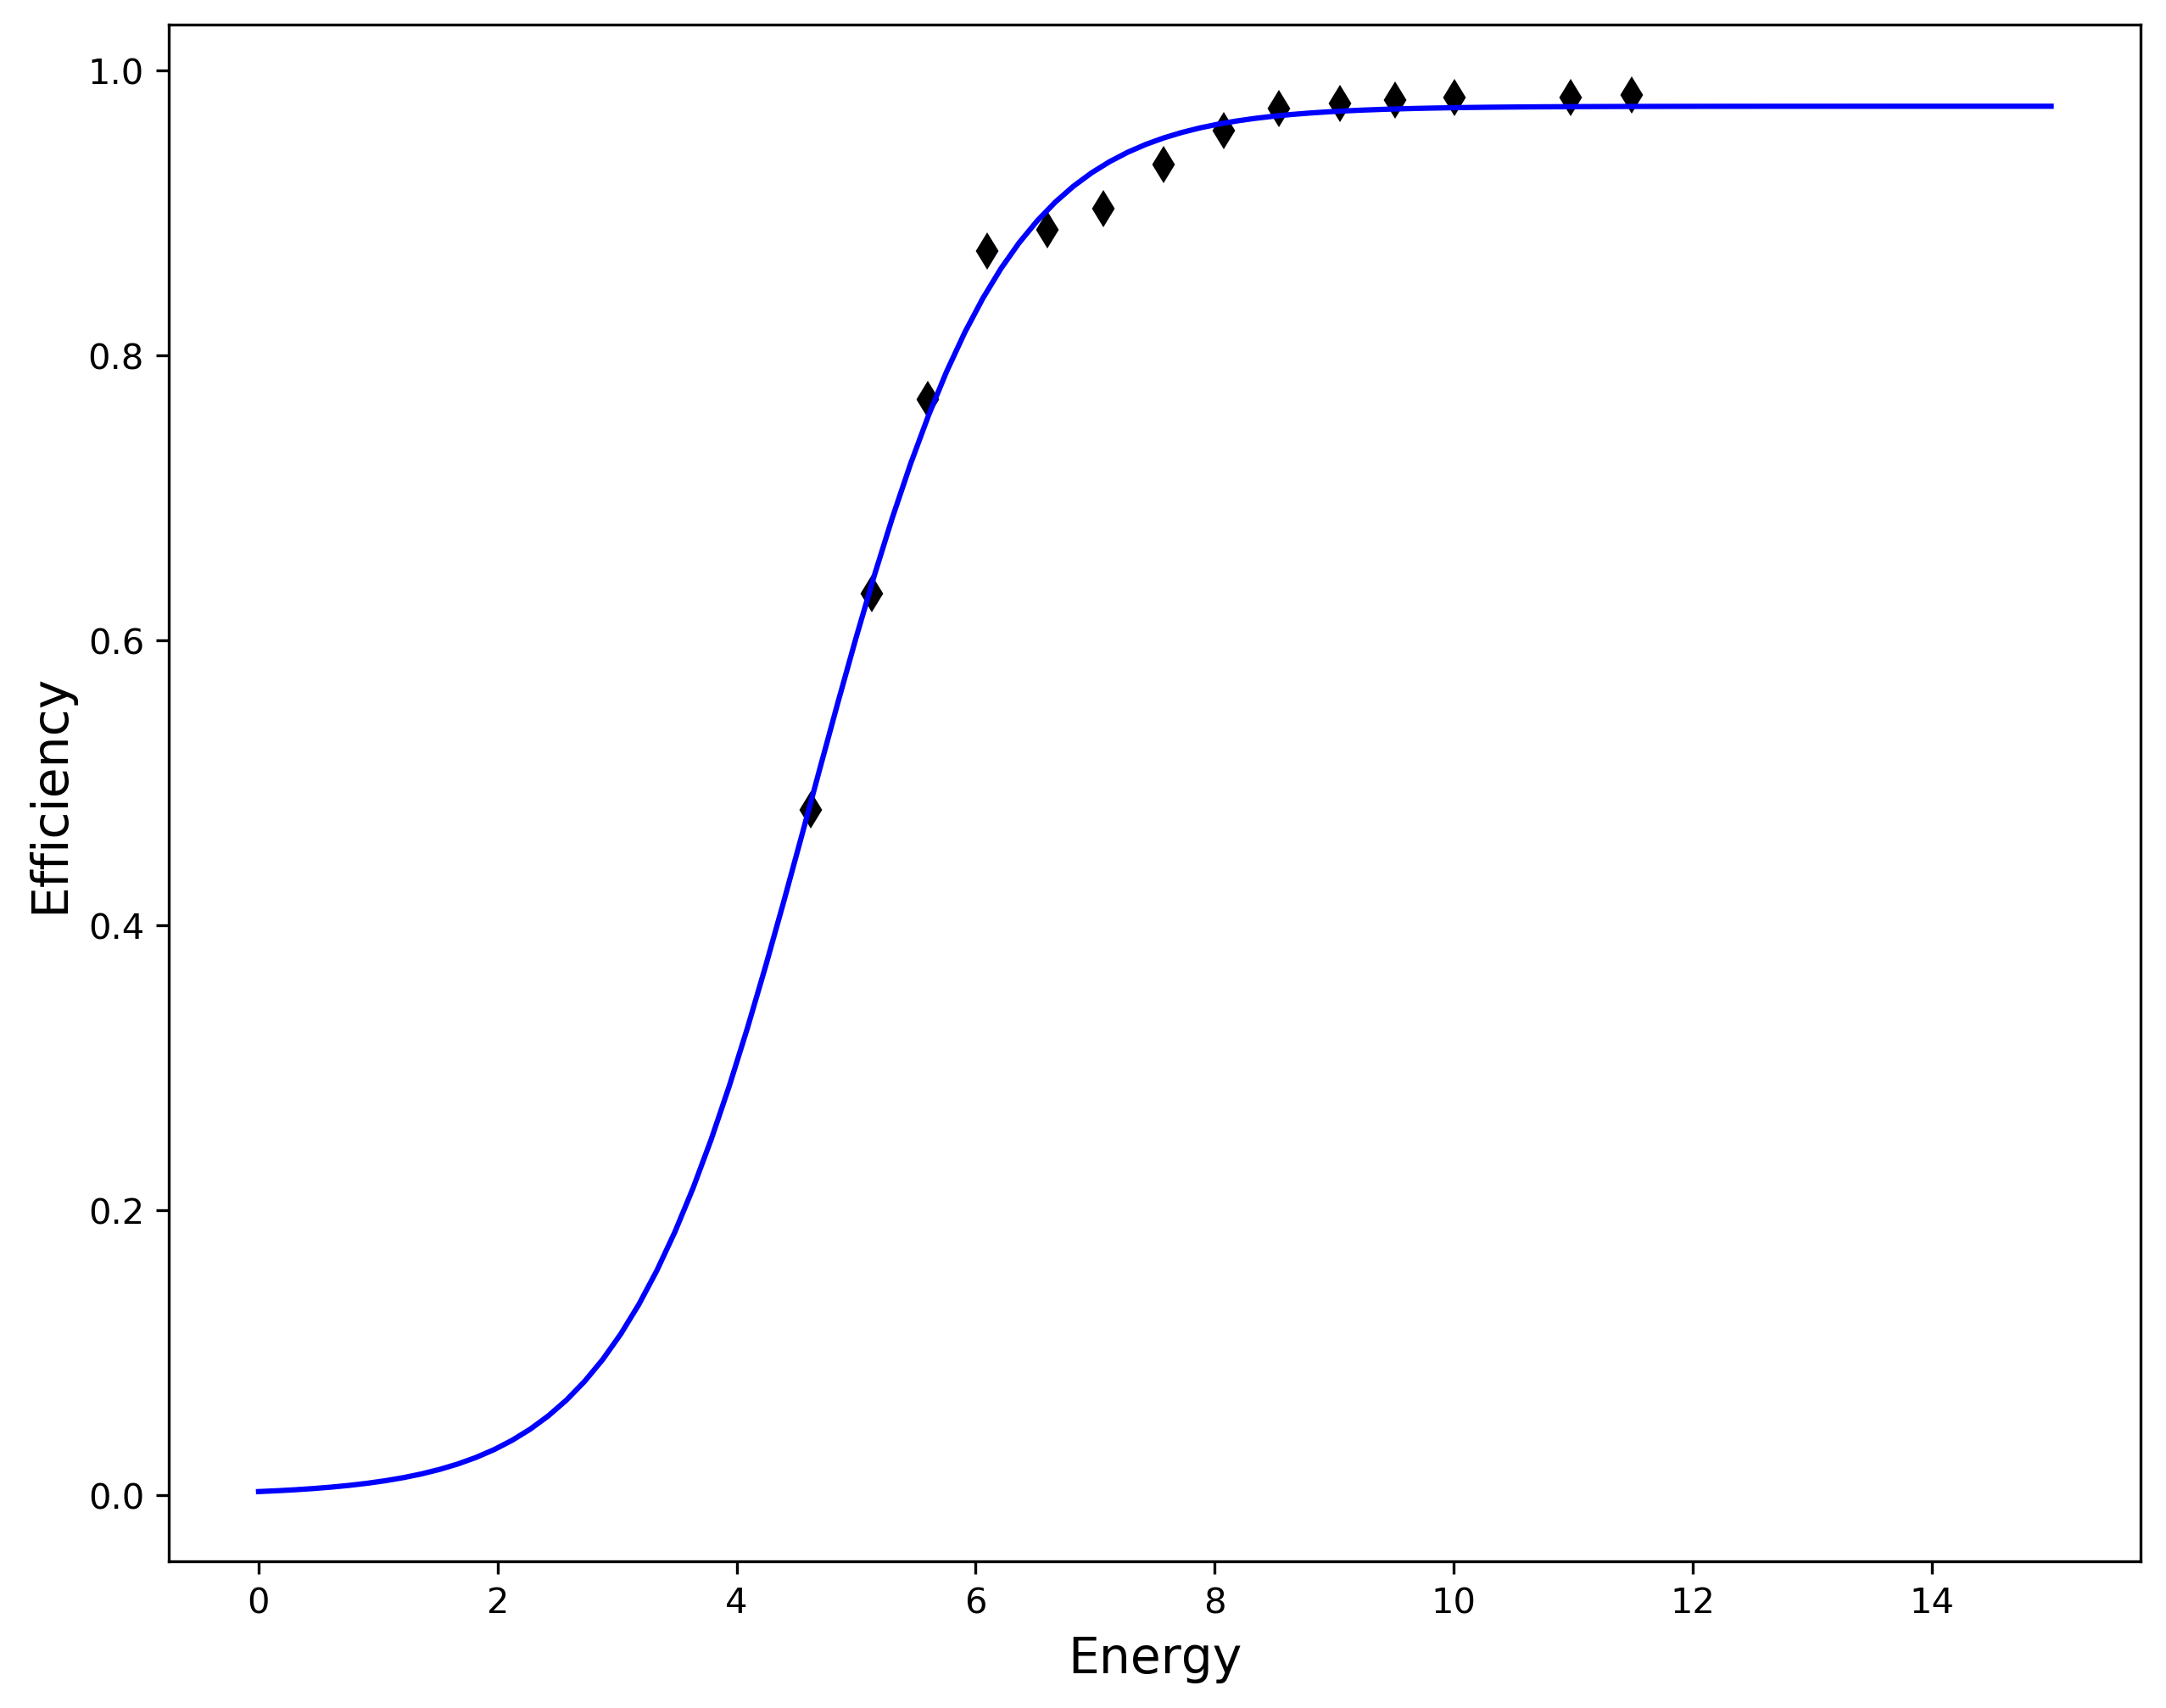

In [41]:
plt.figure(figsize=(10,8), dpi = 300)
plt.plot(E_data, eff_data, 'kd')
plt.plot(E, sig(E, c5[0], c5[1], c5[2]), color = 'blue')
plt.xlabel('Energy', fontsize = 14)
plt.ylabel('Efficiency', fontsize = 14)

## Neutrino-Argon cross section

In [42]:
data[:,0]

array([1.27e-05, 2.3199999999999998e-05, 4.210000000000001e-05, 8.18e-05,
       0.000149, 0.000194, 0.000288, 0.000459, 0.000683,
       0.0010199999999999999, 0.00124, 0.00173, 0.00225, 0.00293,
       0.0035700000000000003, 0.00436, 0.005679999999999999, 0.00648,
       0.0079, 0.00902, 0.011, 0.0125, 0.0153, 0.0199, 0.0242, 0.0295,
       0.0337, 0.041, 0.0468, 0.0533, 0.0569, 0.0649, 0.074, 0.0844,
       0.10300000000000001, 0.125, 0.152, 0.17300000000000001, 0.196,
       0.223, 0.254, 0.289, 0.32899999999999996], dtype=object)

In [53]:
# Choosing only the necessary values from the csv collums
Cross_E = data[0:43,1]
Cross_section = data[0:43,0]

In [54]:
# Getting only the values of each line
E_cross = []
Cross_sec = []
for i in range(len(Cross_E)):
    E_cross.append(float(Cross_E[i]))
    
for i in range(len(Cross_section)):
    Cross_sec.append(float(Cross_section[i]))

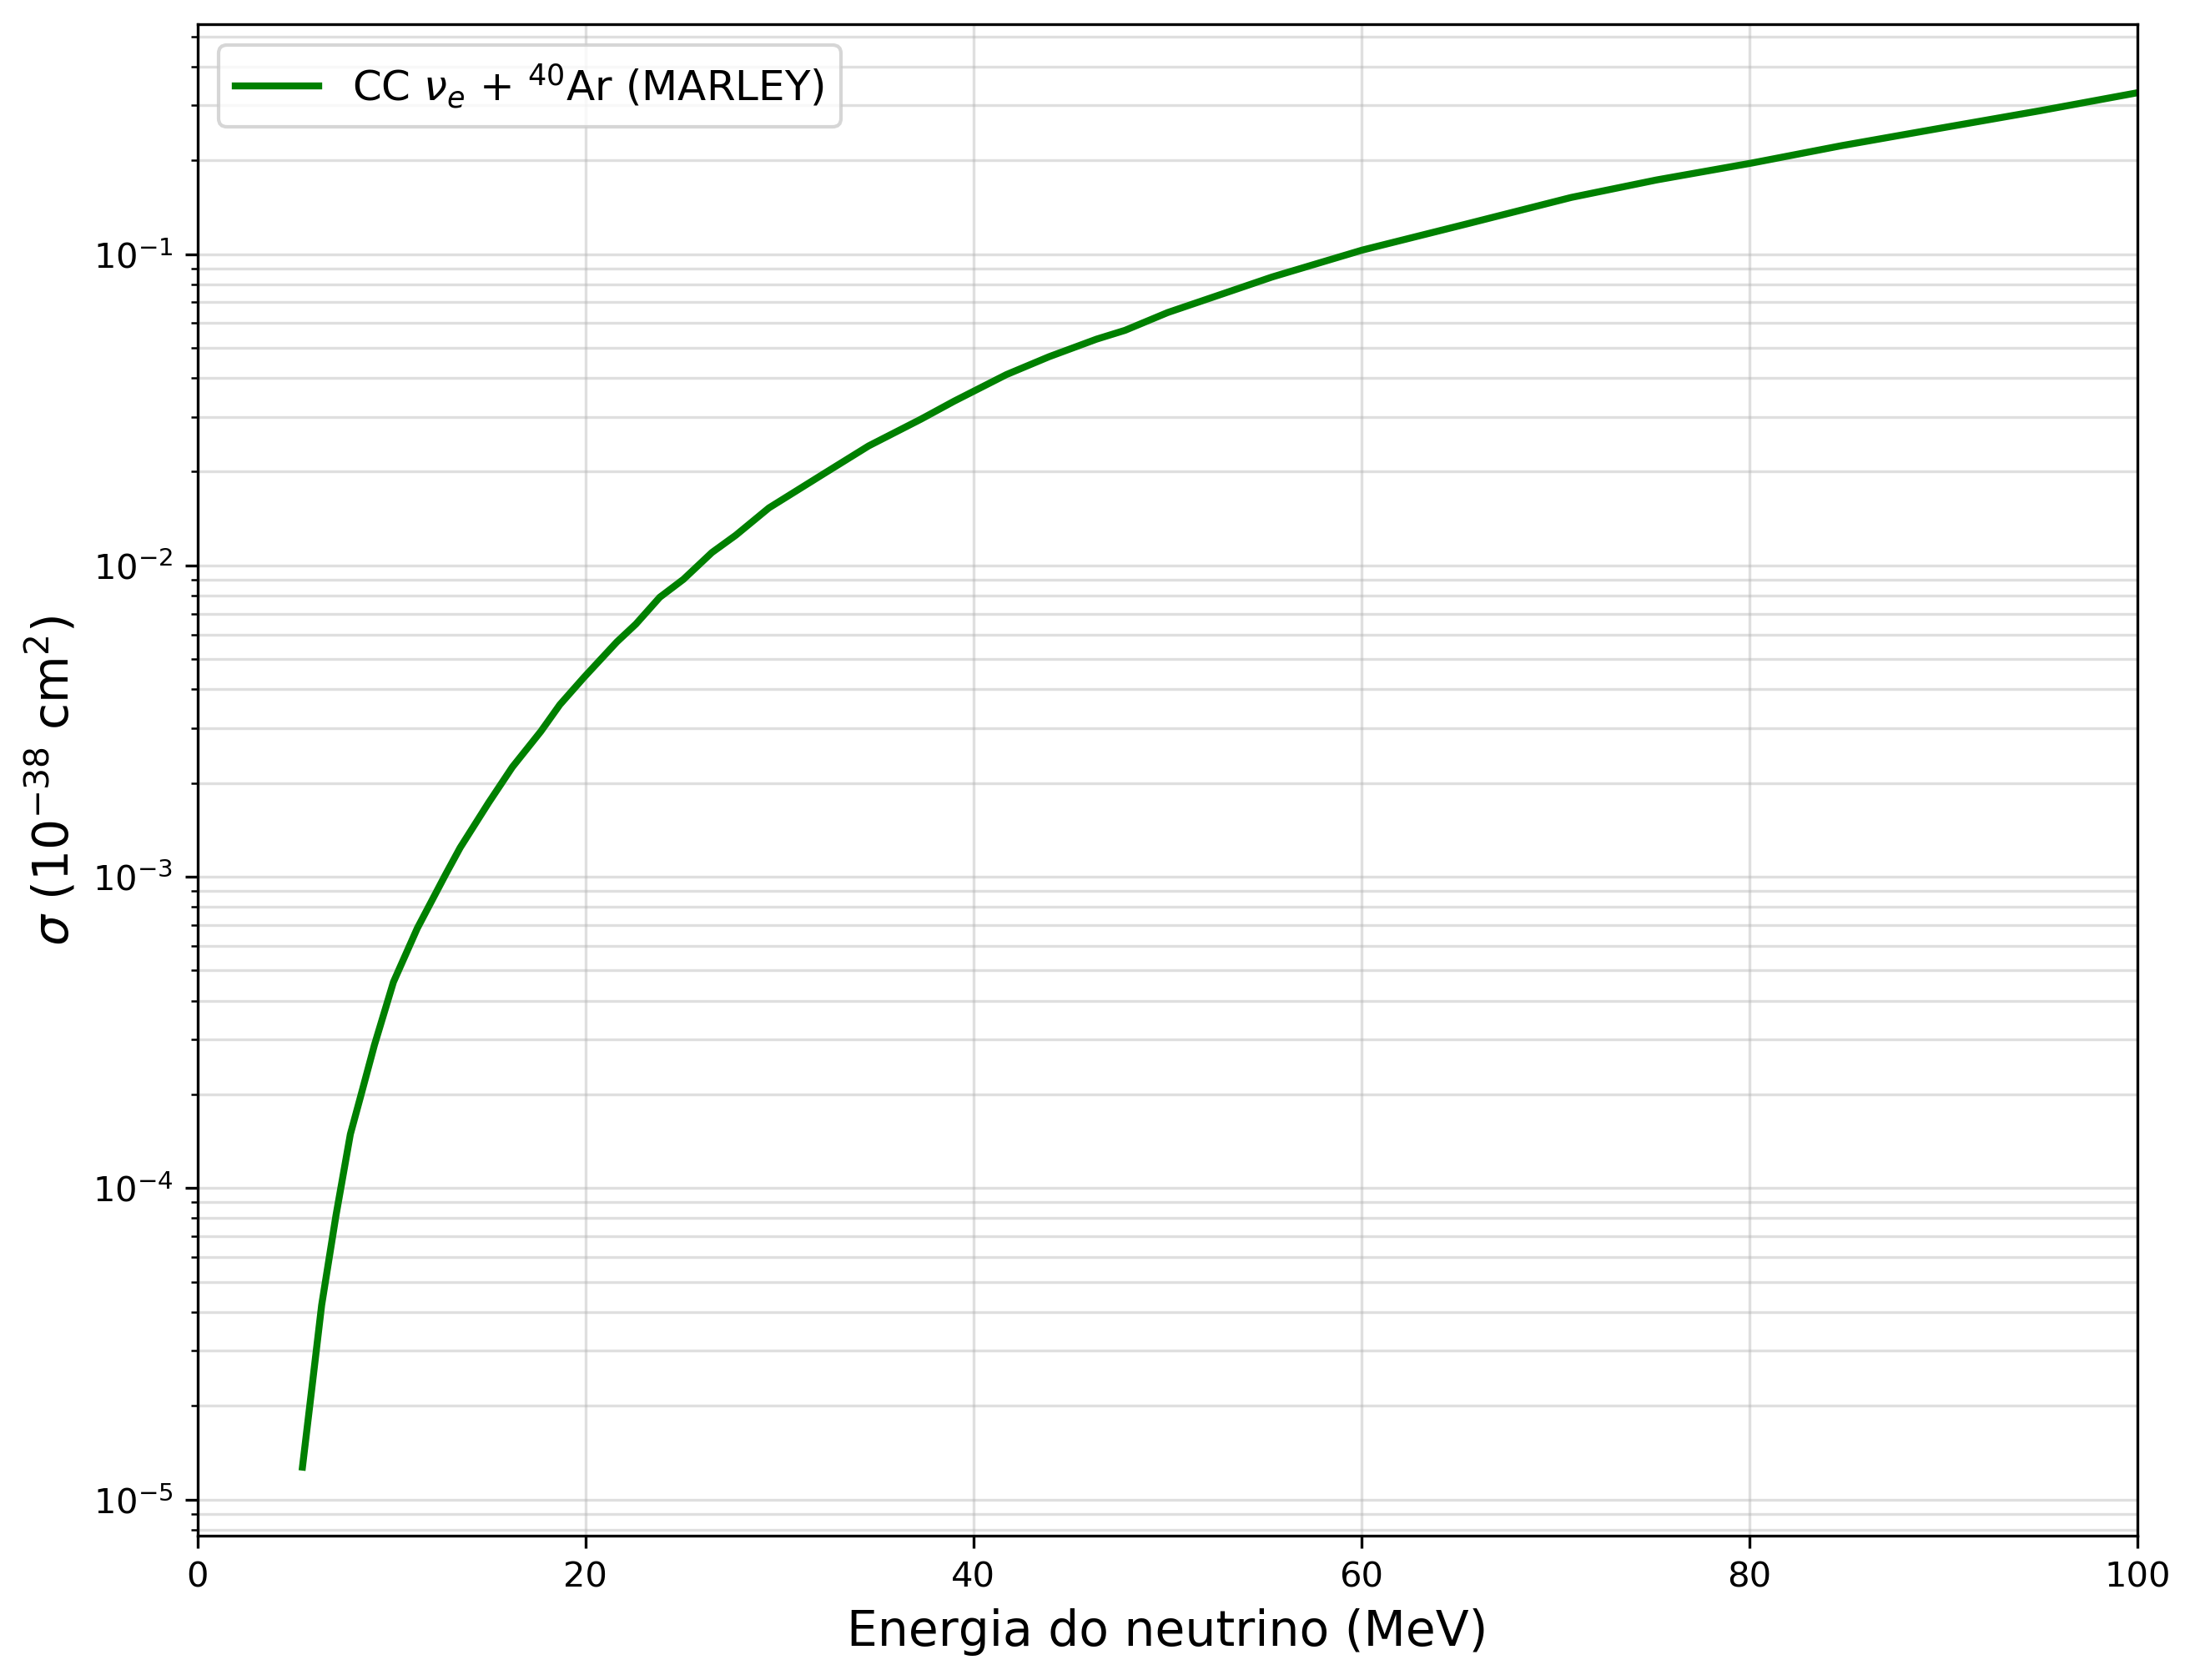

In [55]:
plt.figure(figsize=(10,8), dpi=300)
plt.grid(True, which='both', alpha=0.4)
plt.plot(E_cross, Cross_sec, color = 'green', label=r'CC $\nu_e$ + $^{40}$Ar (MARLEY)', linewidth = 2)
plt.xlabel('Energia do neutrino (MeV)', fontsize = 14)
plt.ylabel('$\sigma$ ($10^{-38}$ cm$^2$)', fontsize = 14)
plt.yscale('log')
plt.xlim(0,100)
plt.legend(loc='upper left', fontsize = 12)

In [56]:
# Transforming in array
E_cross = np.array(E_cross)
Cross_sec = np.array(Cross_sec)

In [57]:
# Defining E range
E = np.linspace(0,100,1000)

# Polynomial fit
pol = np.poly1d(np.polyfit(E_cross, Cross_sec, 9))

print('R^2 score pol:', r2_score(pol(E_cross), Cross_sec))

R^2 score pol: 0.9999782608098325


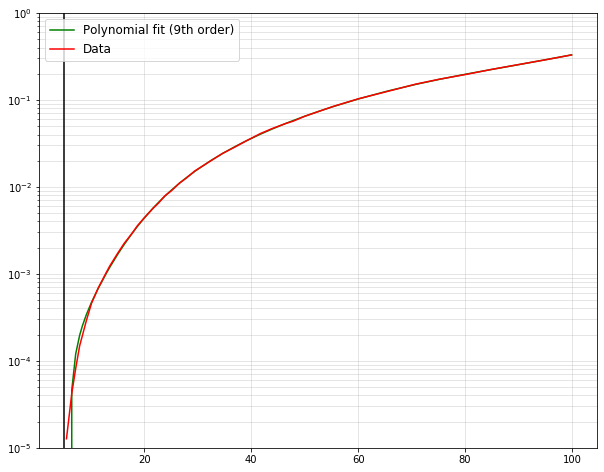

In [58]:
plt.figure(figsize=(10,8))
plt.grid(True, which = 'both', alpha = 0.4)
plt.plot(E_cross, pol(E_cross), color = 'green', label = 'Polynomial fit (9th order)')
plt.plot(E_cross, Cross_sec, color = 'red', label = 'Data')
plt.vlines(5, 1e-5, 1e0, color = 'black')
plt.ylim(1e-5, 1e-0)
plt.yscale('log')
plt.legend(loc='upper left', fontsize = 12)

In [59]:
pol

poly1d([-2.29475852e-17,  9.60641343e-15, -1.63301503e-12,  1.44776872e-10,
       -7.07396347e-09,  1.75257241e-07, -9.65078269e-07, -1.04504407e-05,
        2.20071593e-04, -9.08745120e-04])

## Supernova spectrum

In [114]:
T_test = []
eta_test = []
E_mean = []

for i in range(1000000):
    T = np.random.uniform(0, 100)
    eta = np.random.uniform(0, 20)
    E_ave = simps(E*spec(E, T, eta), E)/simps(spec(E, T, eta), E)
    E_mean.append(E_ave)
    T_test.append(T)
    eta_test.append(eta)

In [311]:
T_1987 = []
eta_1987 = []
E_1987 = []

for i in range(1000000):
    T = np.random.uniform(0, 100)
    eta = np.random.uniform(0, 20)
    E_ave = simps(E*spec(E, T, eta), E)/simps(spec(E, T, eta), E)
    if E_ave >= 8 and E_ave <= 28.4:
        E_1987.append(E_ave)
        T_1987.append(T)
        eta_1987.append(eta)

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


(0, 20)

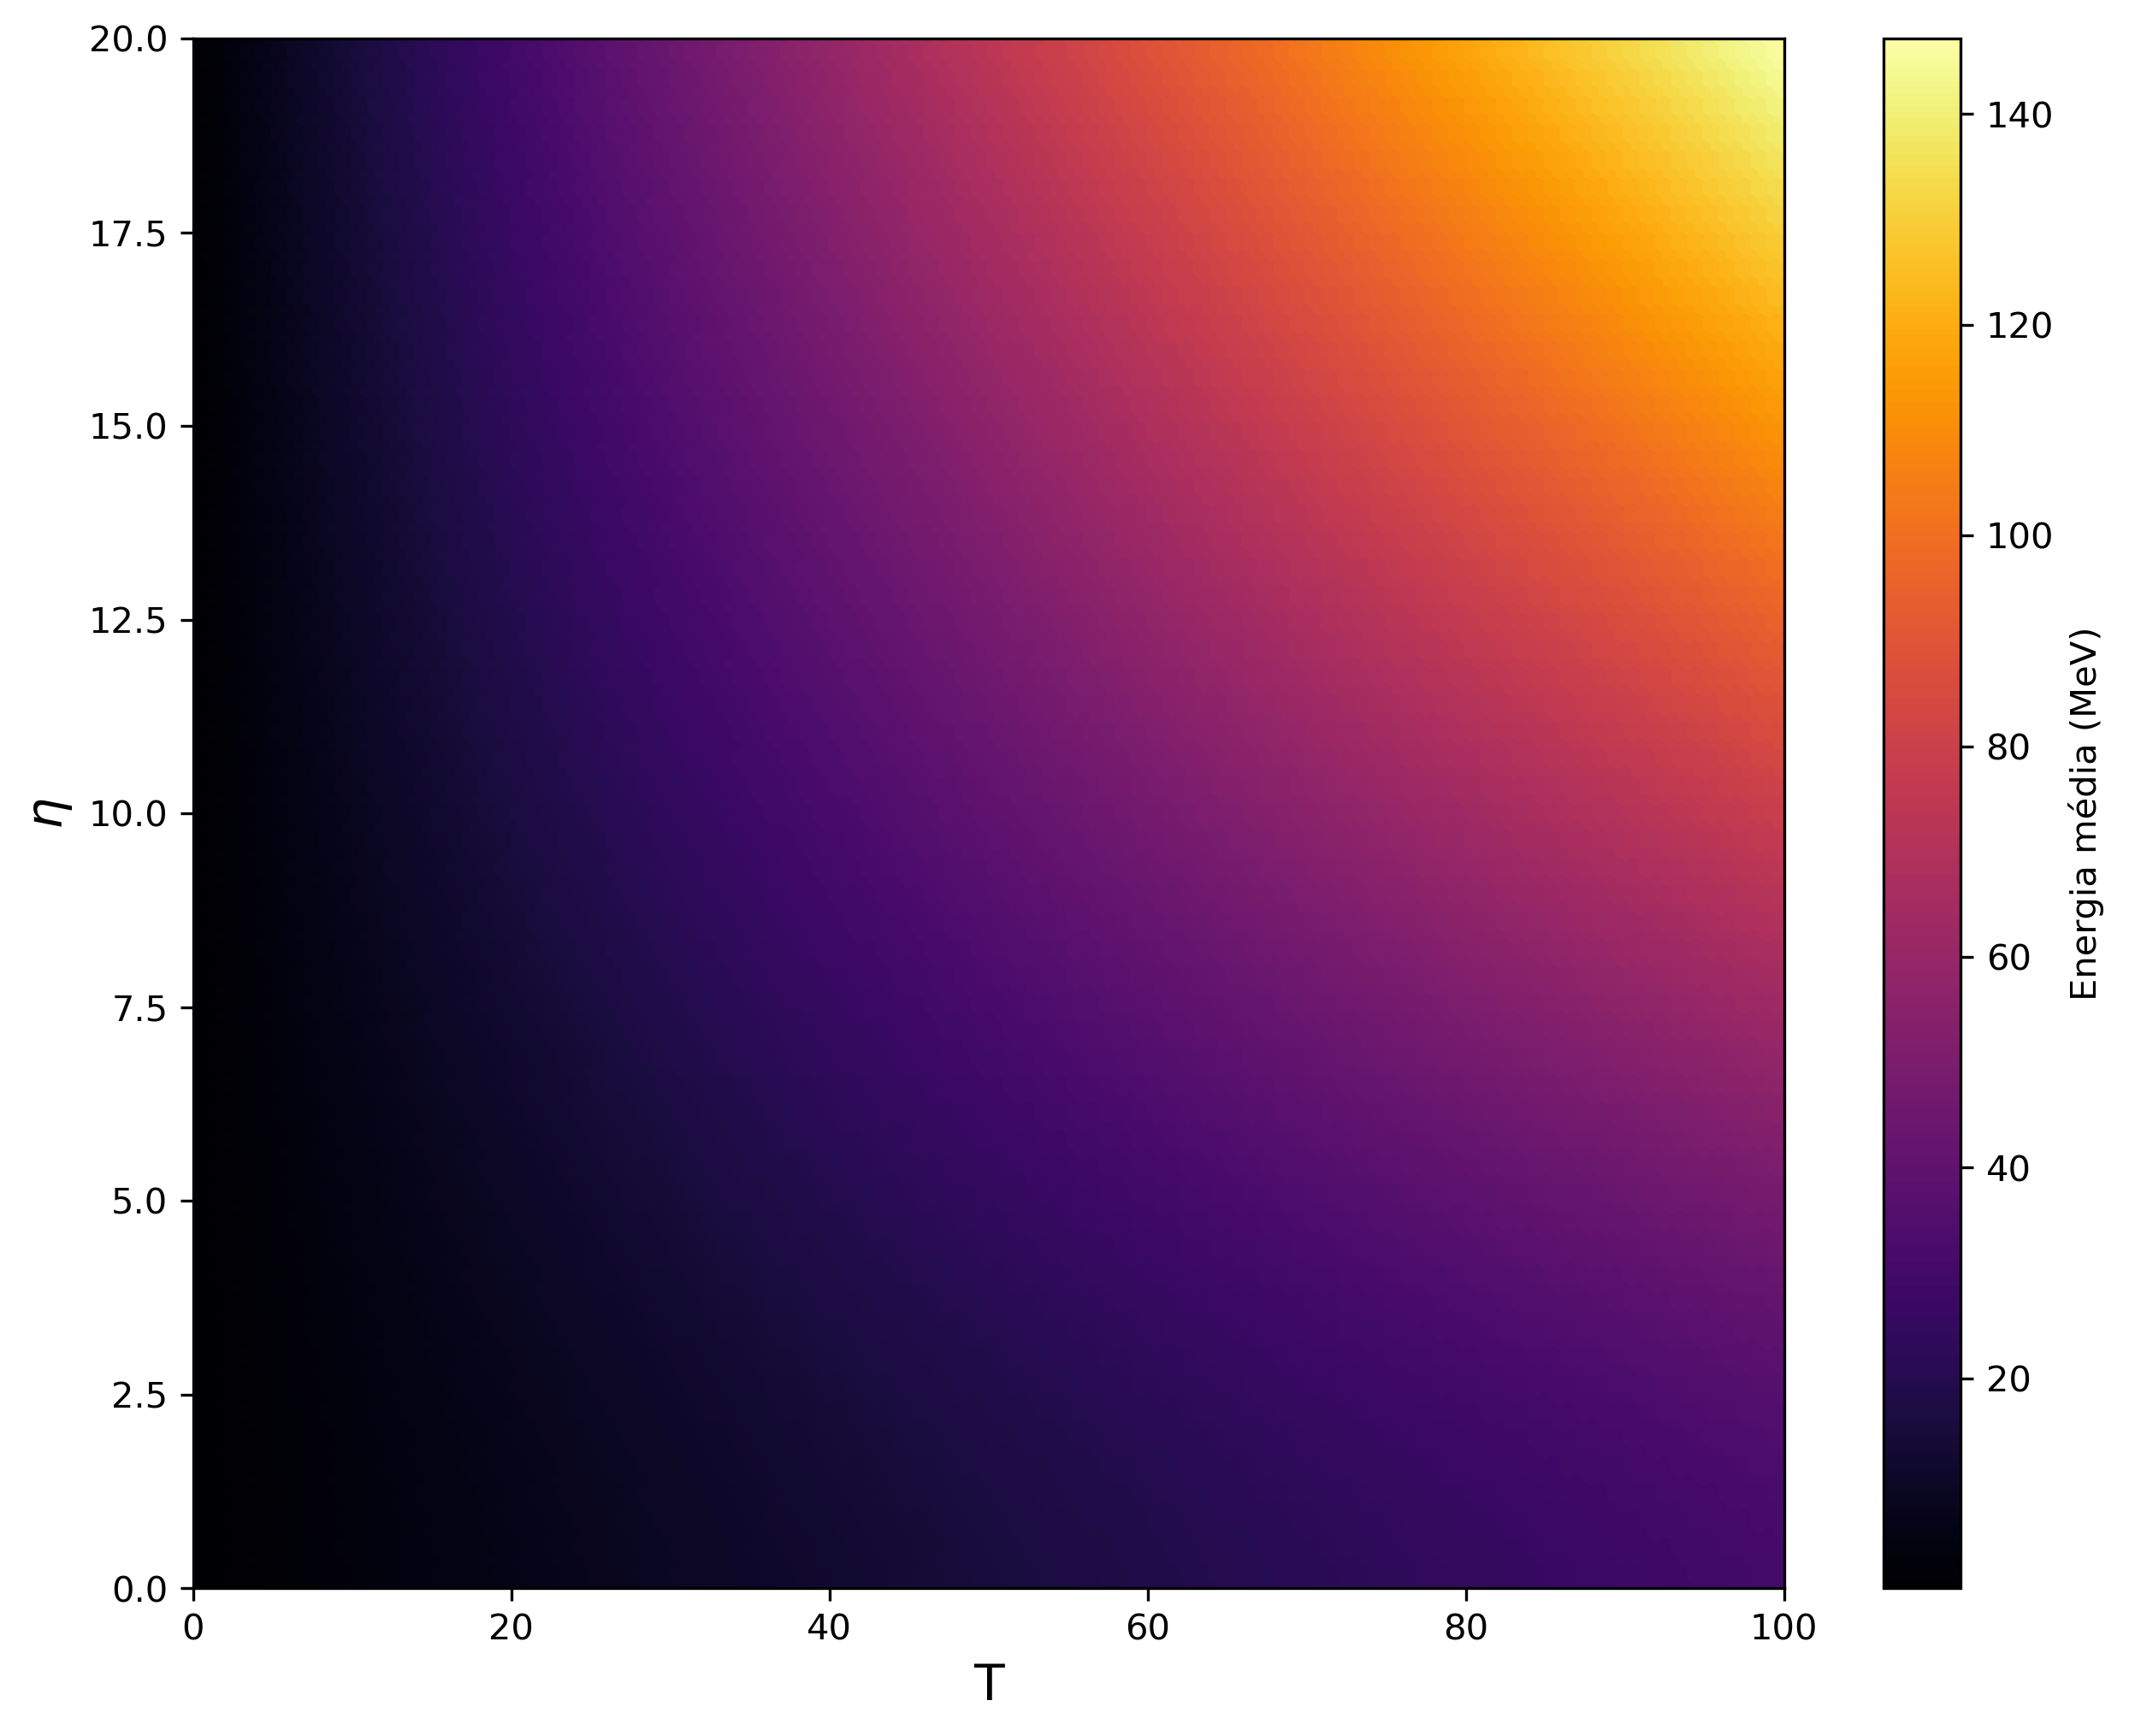

In [310]:
plt.figure(figsize=(10,8), dpi = 300)
cs = plt.hexbin(T_test, eta_test, C=E_mean, gridsize=100, cmap='inferno', bins=None)
plt.colorbar(cs, label = 'Energia média (MeV)')
plt.xlabel('T', fontsize = 14)
plt.ylabel('$\eta$', fontsize = 14)
plt.xlim(0, 100)
plt.ylim(0, 20)

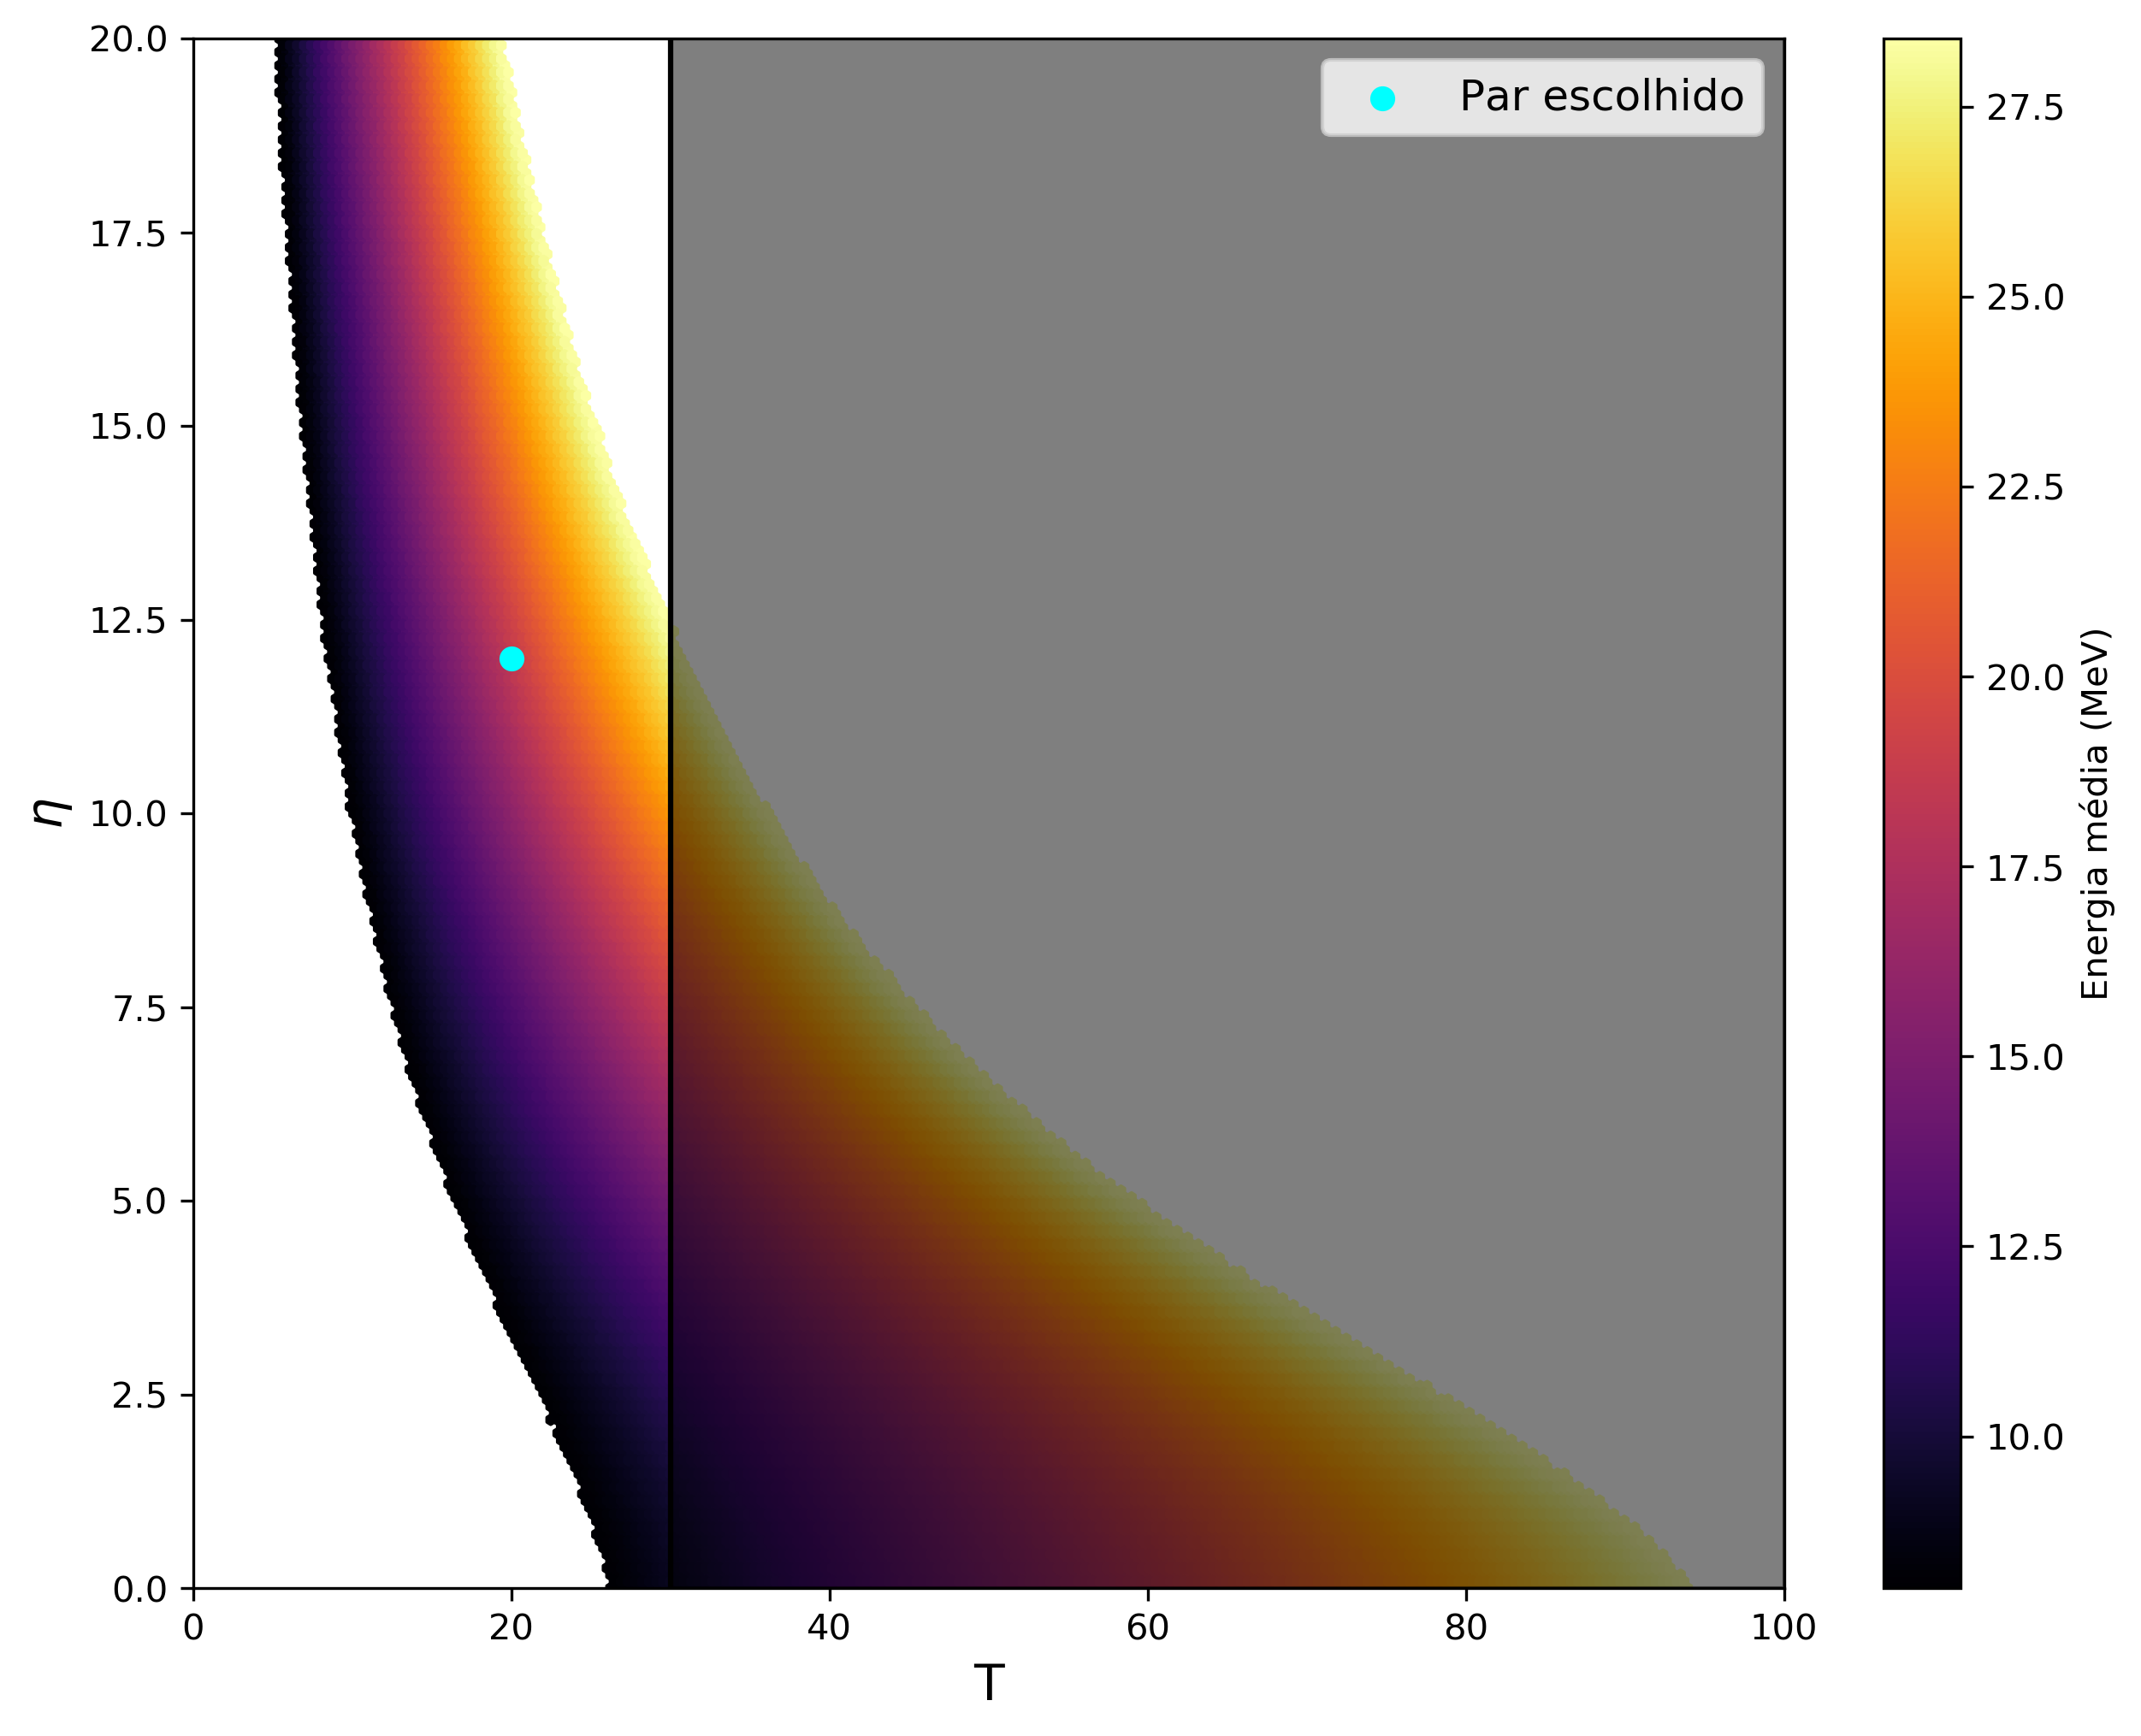

In [320]:
x = np.linspace(30, 100, 100)
plt.figure(figsize=(10,8), dpi = 300)
cs = plt.hexbin(T_1987, eta_1987, C=E_1987, gridsize=200, cmap='inferno', bins=None)
plt.colorbar(cs, label = 'Energia média (MeV)')
plt.scatter(20, 12, color='cyan', label = 'Par escolhido')
plt.xlabel('T', fontsize = 14)
plt.ylabel('$\eta$', fontsize = 14)
plt.vlines(30, 0, 20, color = 'black')
plt.fill_between(x, 0, 20, color = 'black', alpha = 0.5)
plt.xlim(0, 100)
plt.ylim(0, 20)
plt.legend(loc = 'upper right', fontsize = 12)

In [344]:
#Here we define the range of variation for the energy E in MeVs

E = np.linspace(0.001, 100, 1000)

#Here we now define the "spec" function, representing the supernova spectrum

def spec(E, T, eta):
    fermi3 = 1
    Etot = 1e53
    A = Etot/((T**3)*fermi3)
    k = 9.617e-2
    return A*((E**2)/(1 + np.exp(E/(k*T)-eta)))

#An interesting thing to do, is to calculate the total number of neutrinos emitted in this process, given by
#the integral of spec over all energies

tot = simps(spec(E, 20, 12), E)
print('Total number of neutrinos emitted: ', tot)

Total number of neutrinos emitted:  2.737169537340631e+51


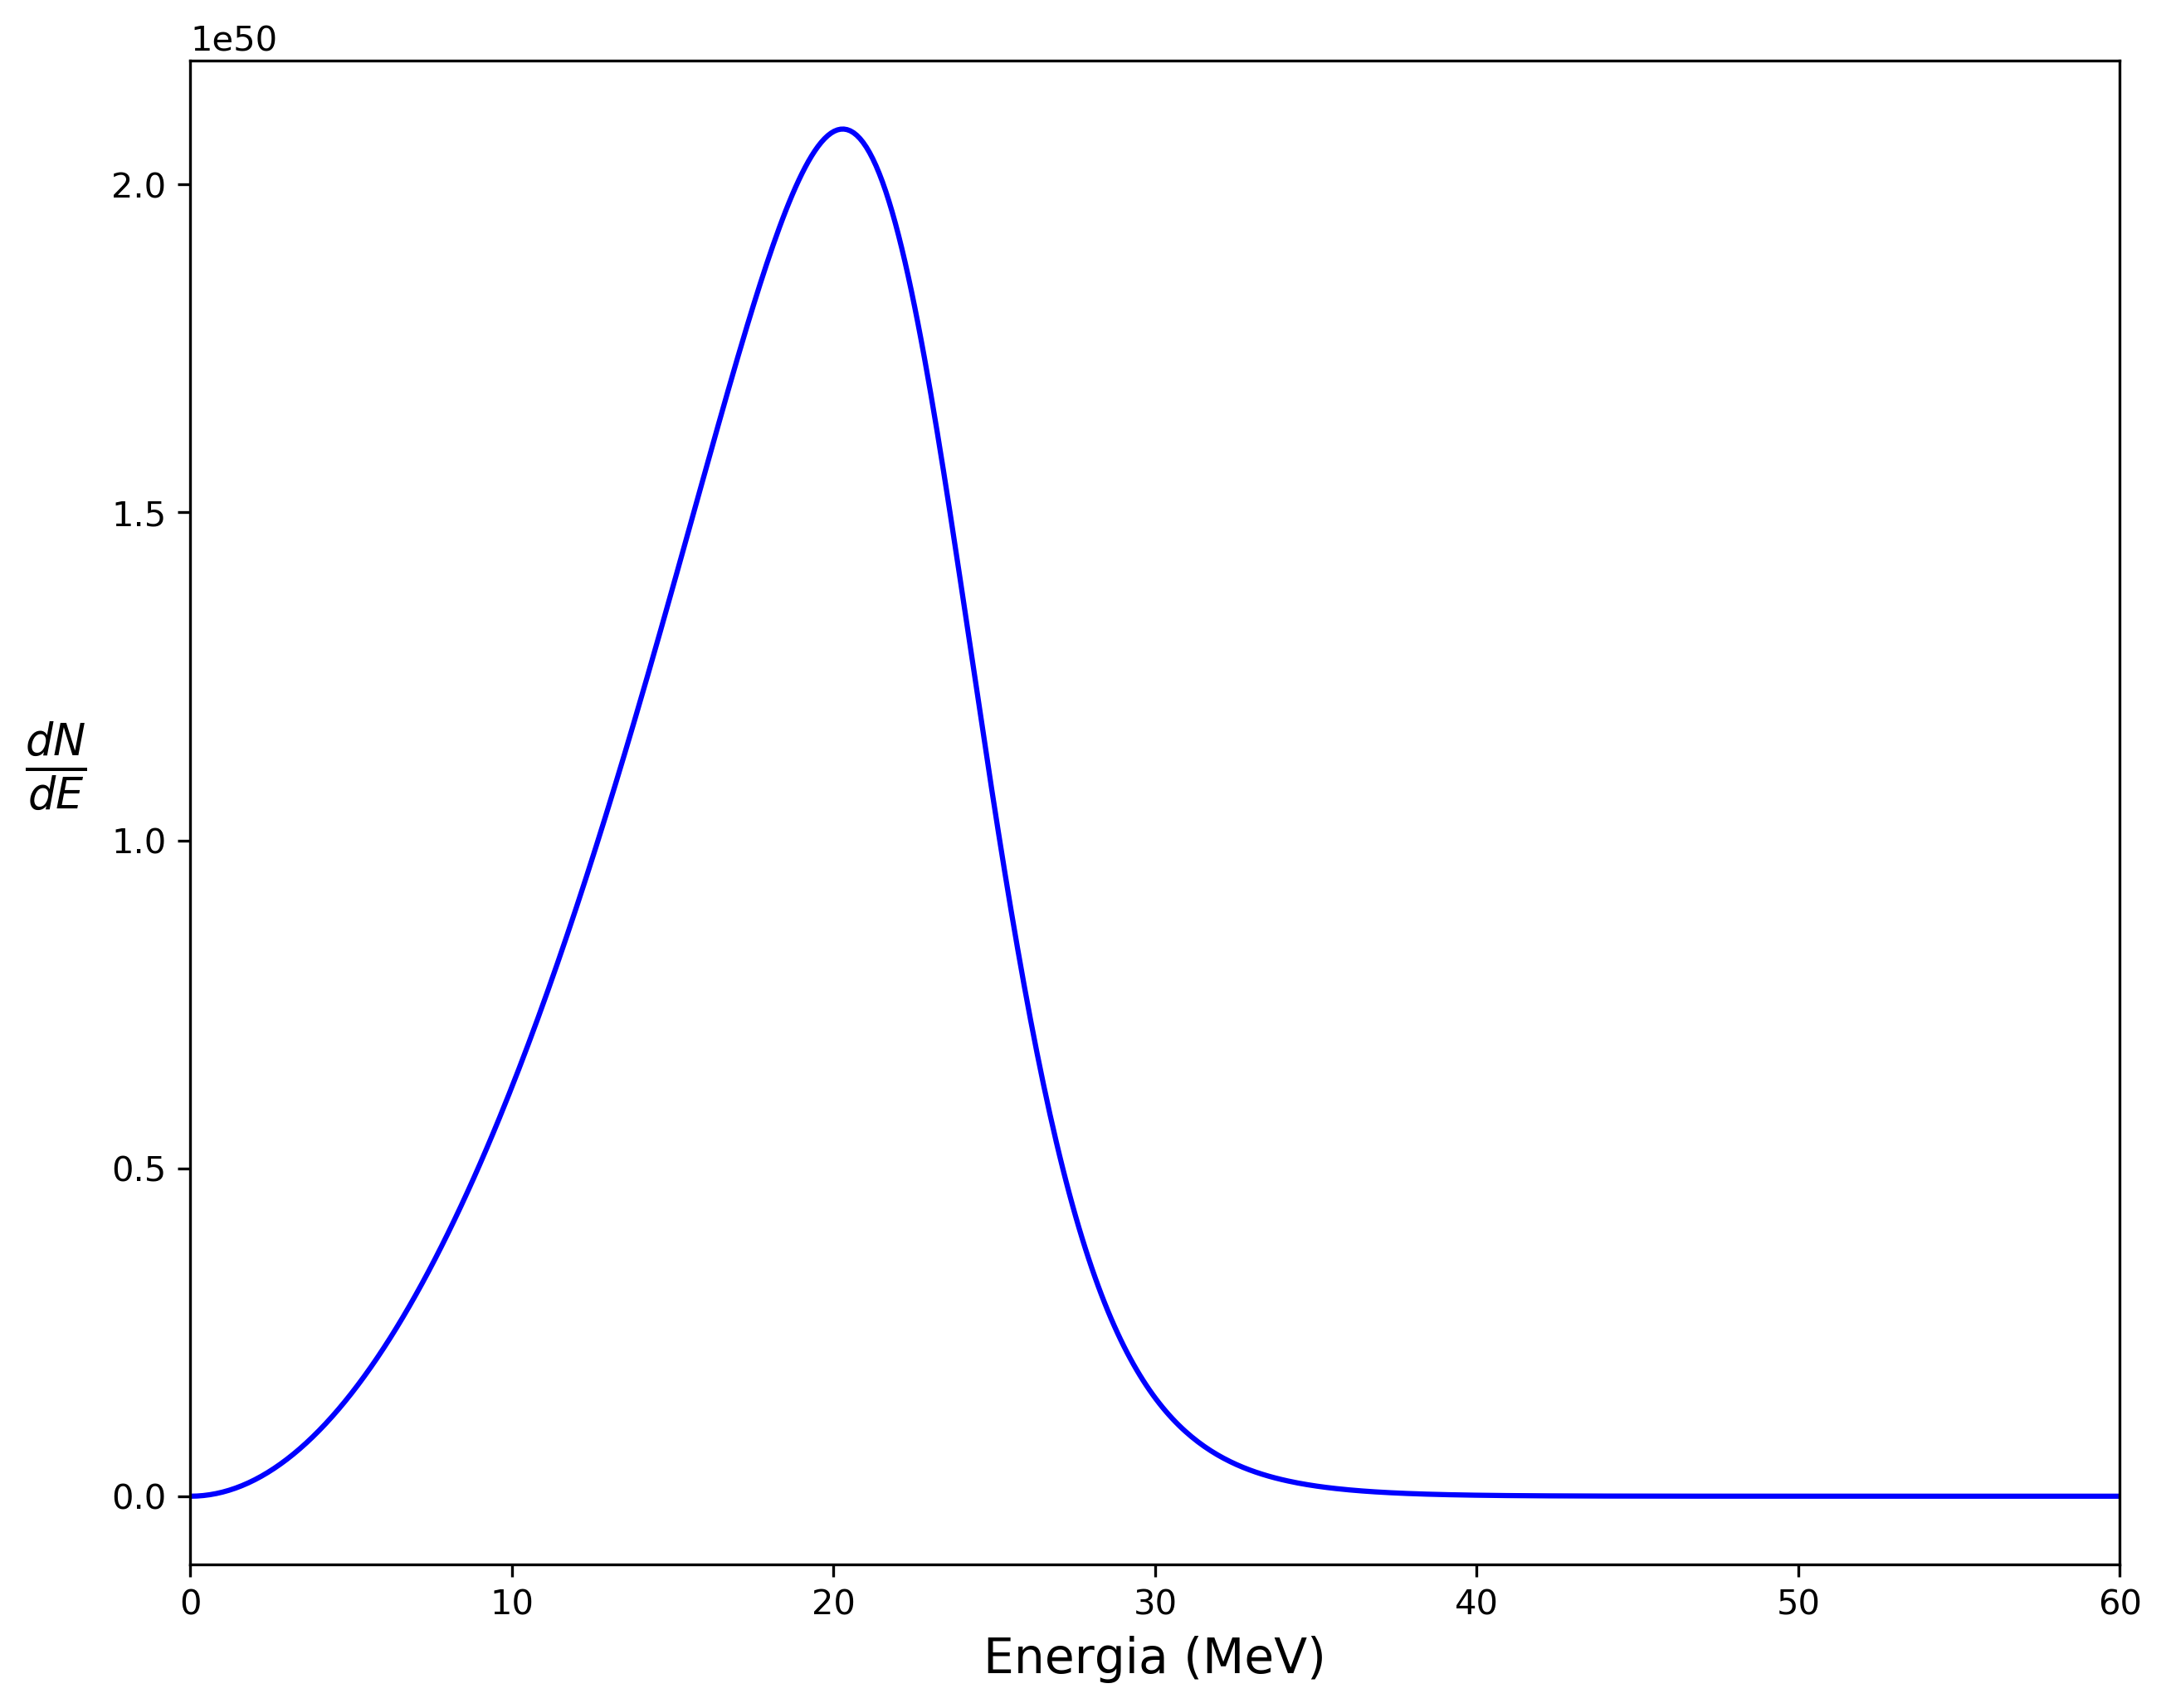

In [395]:
plt.figure(figsize=(10,8), dpi = 300)
plt.plot(E, spec(E, 20, 12), color = 'blue', label = 'Espectro emitido')
plt.xlabel(r'Energia (MeV)', fontsize = 14)
plt.ylabel(r'$\frac{dN}{dE}$', rotation = 0, labelpad = 16, fontsize = 18)
plt.xlim(0, 60)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/SupernovaEspec.pdf')

## Detection

Nice, now we proceed to create our detection spectrum, which is given by the multiplication of the supernova spectrum $dN/dE$ by the interaction cross-section of our detector $\sigma(E)$ and the efficiency $\varepsilon (E)$.

In [346]:
def sigmaNC(E, th, g1, g2):
    m_e = 0.511
    sigma_0 = 88.06e-46
    Tmax = (2*E**2)/(m_e + 2*E)
    return (sigma_0/m_e)*((g1**2 + g2**2)*(Tmax-th)-(g2**2 + g1*g2*(m_e/(2*E)))*((Tmax**2 - th**2)/E) + 
                         ((g2**2)/3)*((Tmax**3 - th**3)/E))

In [347]:
def sigmaCCAr(E):
    a = 1e-38
    coef = [-2.29475852e-17,  9.60641343e-15, -1.63301503e-12,  1.44776872e-10,
       -7.07396347e-09,  1.75257241e-07, -9.65078269e-07, -1.04504407e-05,
        2.20071593e-04, -9.08745120e-04]
    p = a*np.poly1d(coef)
    return p(E)

In [348]:
len(sigmaCCAr(E))

1000

In [349]:
def efficiency(E, a, b): #Detector efficiency
    return 1/(1+np.exp(-a*(E-b)))

In [403]:
def detec(E, T, eta):
    Nt = 1e36 #Number of target particles in the detector
    d = 50000*(3.09e16) #Distance from supernova to the detector
    D = Nt/(4*np.pi*d**2)
    return spec(E, T, eta)*(sigma(E, 0, 1/2, 1/2)+sigmaCCAr(E))*efficiency(E, 0.976, 1.265)*D

#It is useful to compute the total number of detected neutrinos, given by the integral of our "detec" function
#multiplied by a constant (D) that represents the homogeneous spread of neutrinos all over space, that is why
#we added it to the "detec" function already, but again, for simplicity we choose not to use it

s0 = simps(detec(E, 20, 12), E)
print('Expected events in the detector = %3.f' % s0)

Expected events in the detector = 4098


In [399]:
E_mean = simps(E*detec(E, 20, 12), E)/simps(detec(E, 20, 12), E)
print(f'Mean energy: {E_mean} MeV')

Mean energy: 22.651152736677442 MeV


## Small parenthesis here to test how T and \eta change the number of events in the detector

In [325]:
T_d = []
eta_d = []
events = []

for i in range(1000000):
    T = np.random.uniform(0, 100)
    eta = np.random.uniform(0, 20)
    event = simps(detec(E, T, eta), E)
    if event >= 0:
        T_d.append(T)
        eta_d.append(eta)
        events.append(event)

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [340]:
T_d2 = []
eta_d2 = []
events2 = []

for i in range(1000000):
    T = np.random.uniform(0, 100)
    eta = np.random.uniform(0, 20)
    event = simps(detec(E, T, eta), E)
    if event >= 0 and event <= 10000:
        T_d2.append(T)
        eta_d2.append(eta)
        events2.append(event)

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


(0, 20)

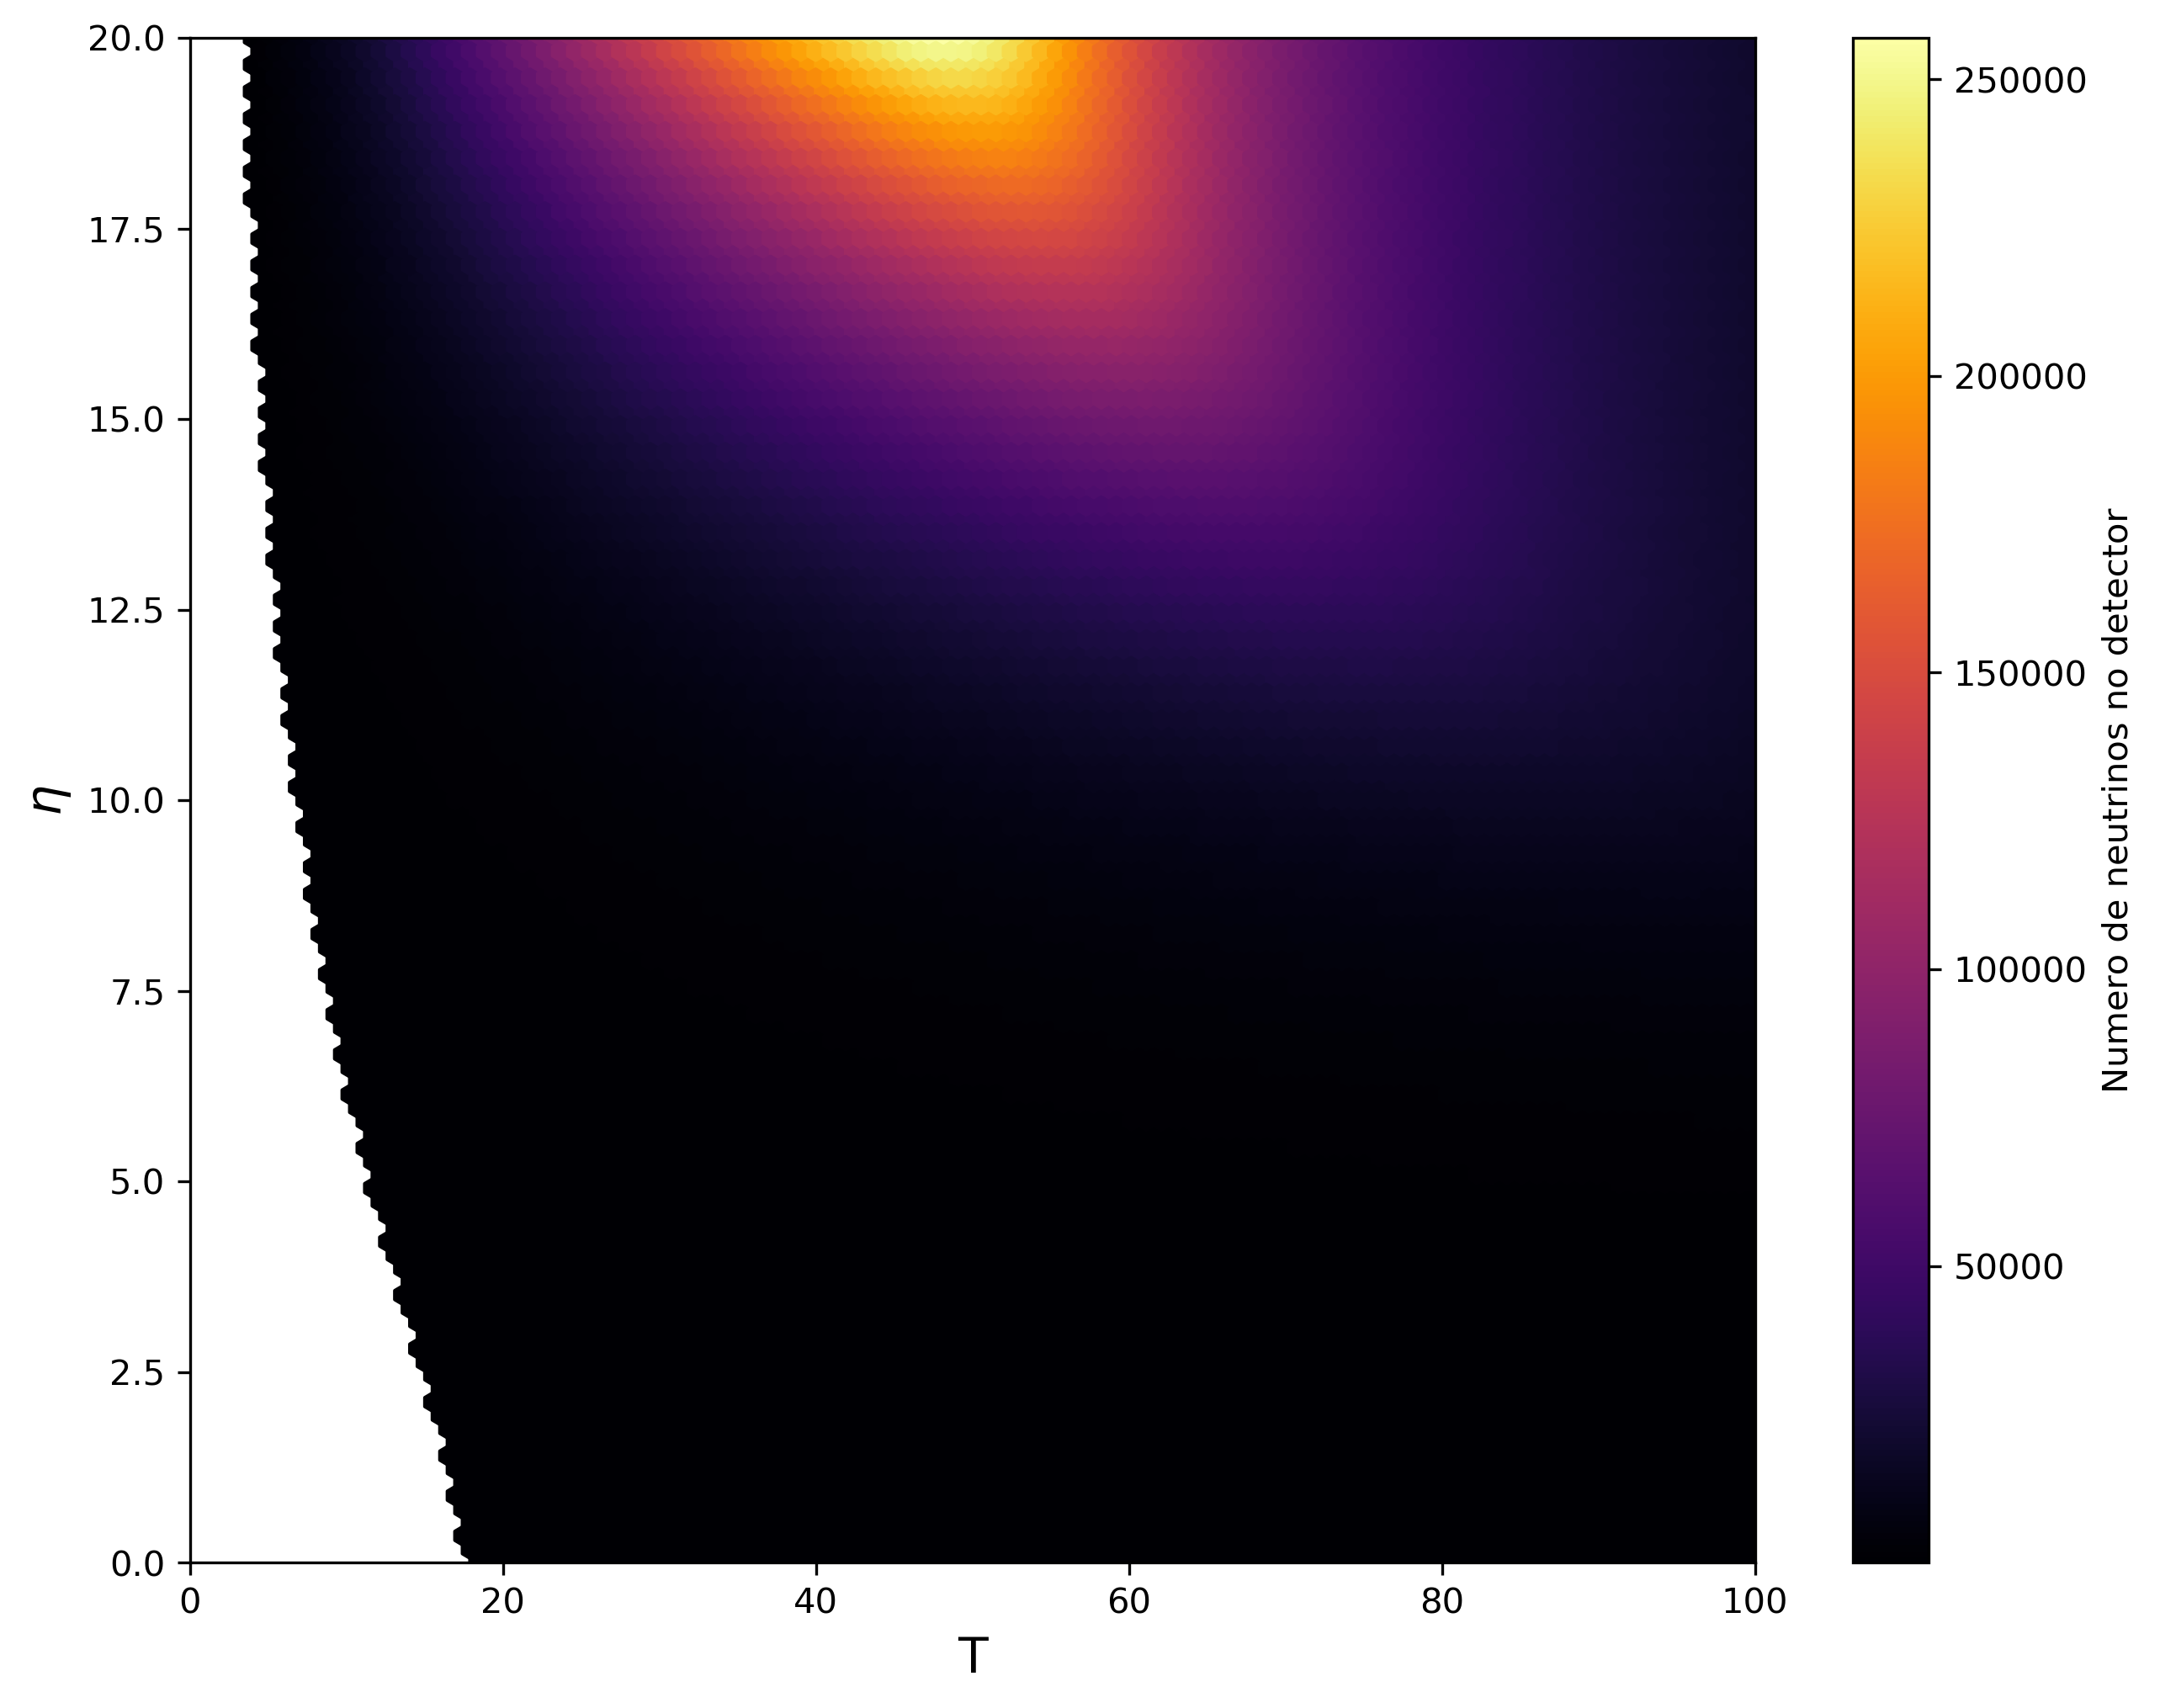

In [339]:
plt.figure(figsize=(10,8), dpi = 300)
cs = plt.hexbin(T_d, eta_d, C=events, gridsize=100, cmap='inferno', bins=None)
plt.colorbar(cs, label = 'Numero de neutrinos no detector')
plt.xlabel('T', fontsize = 14)
plt.ylabel('$\eta$', fontsize = 14)
plt.xlim(0, 100)
plt.ylim(0, 20)

(0, 20)

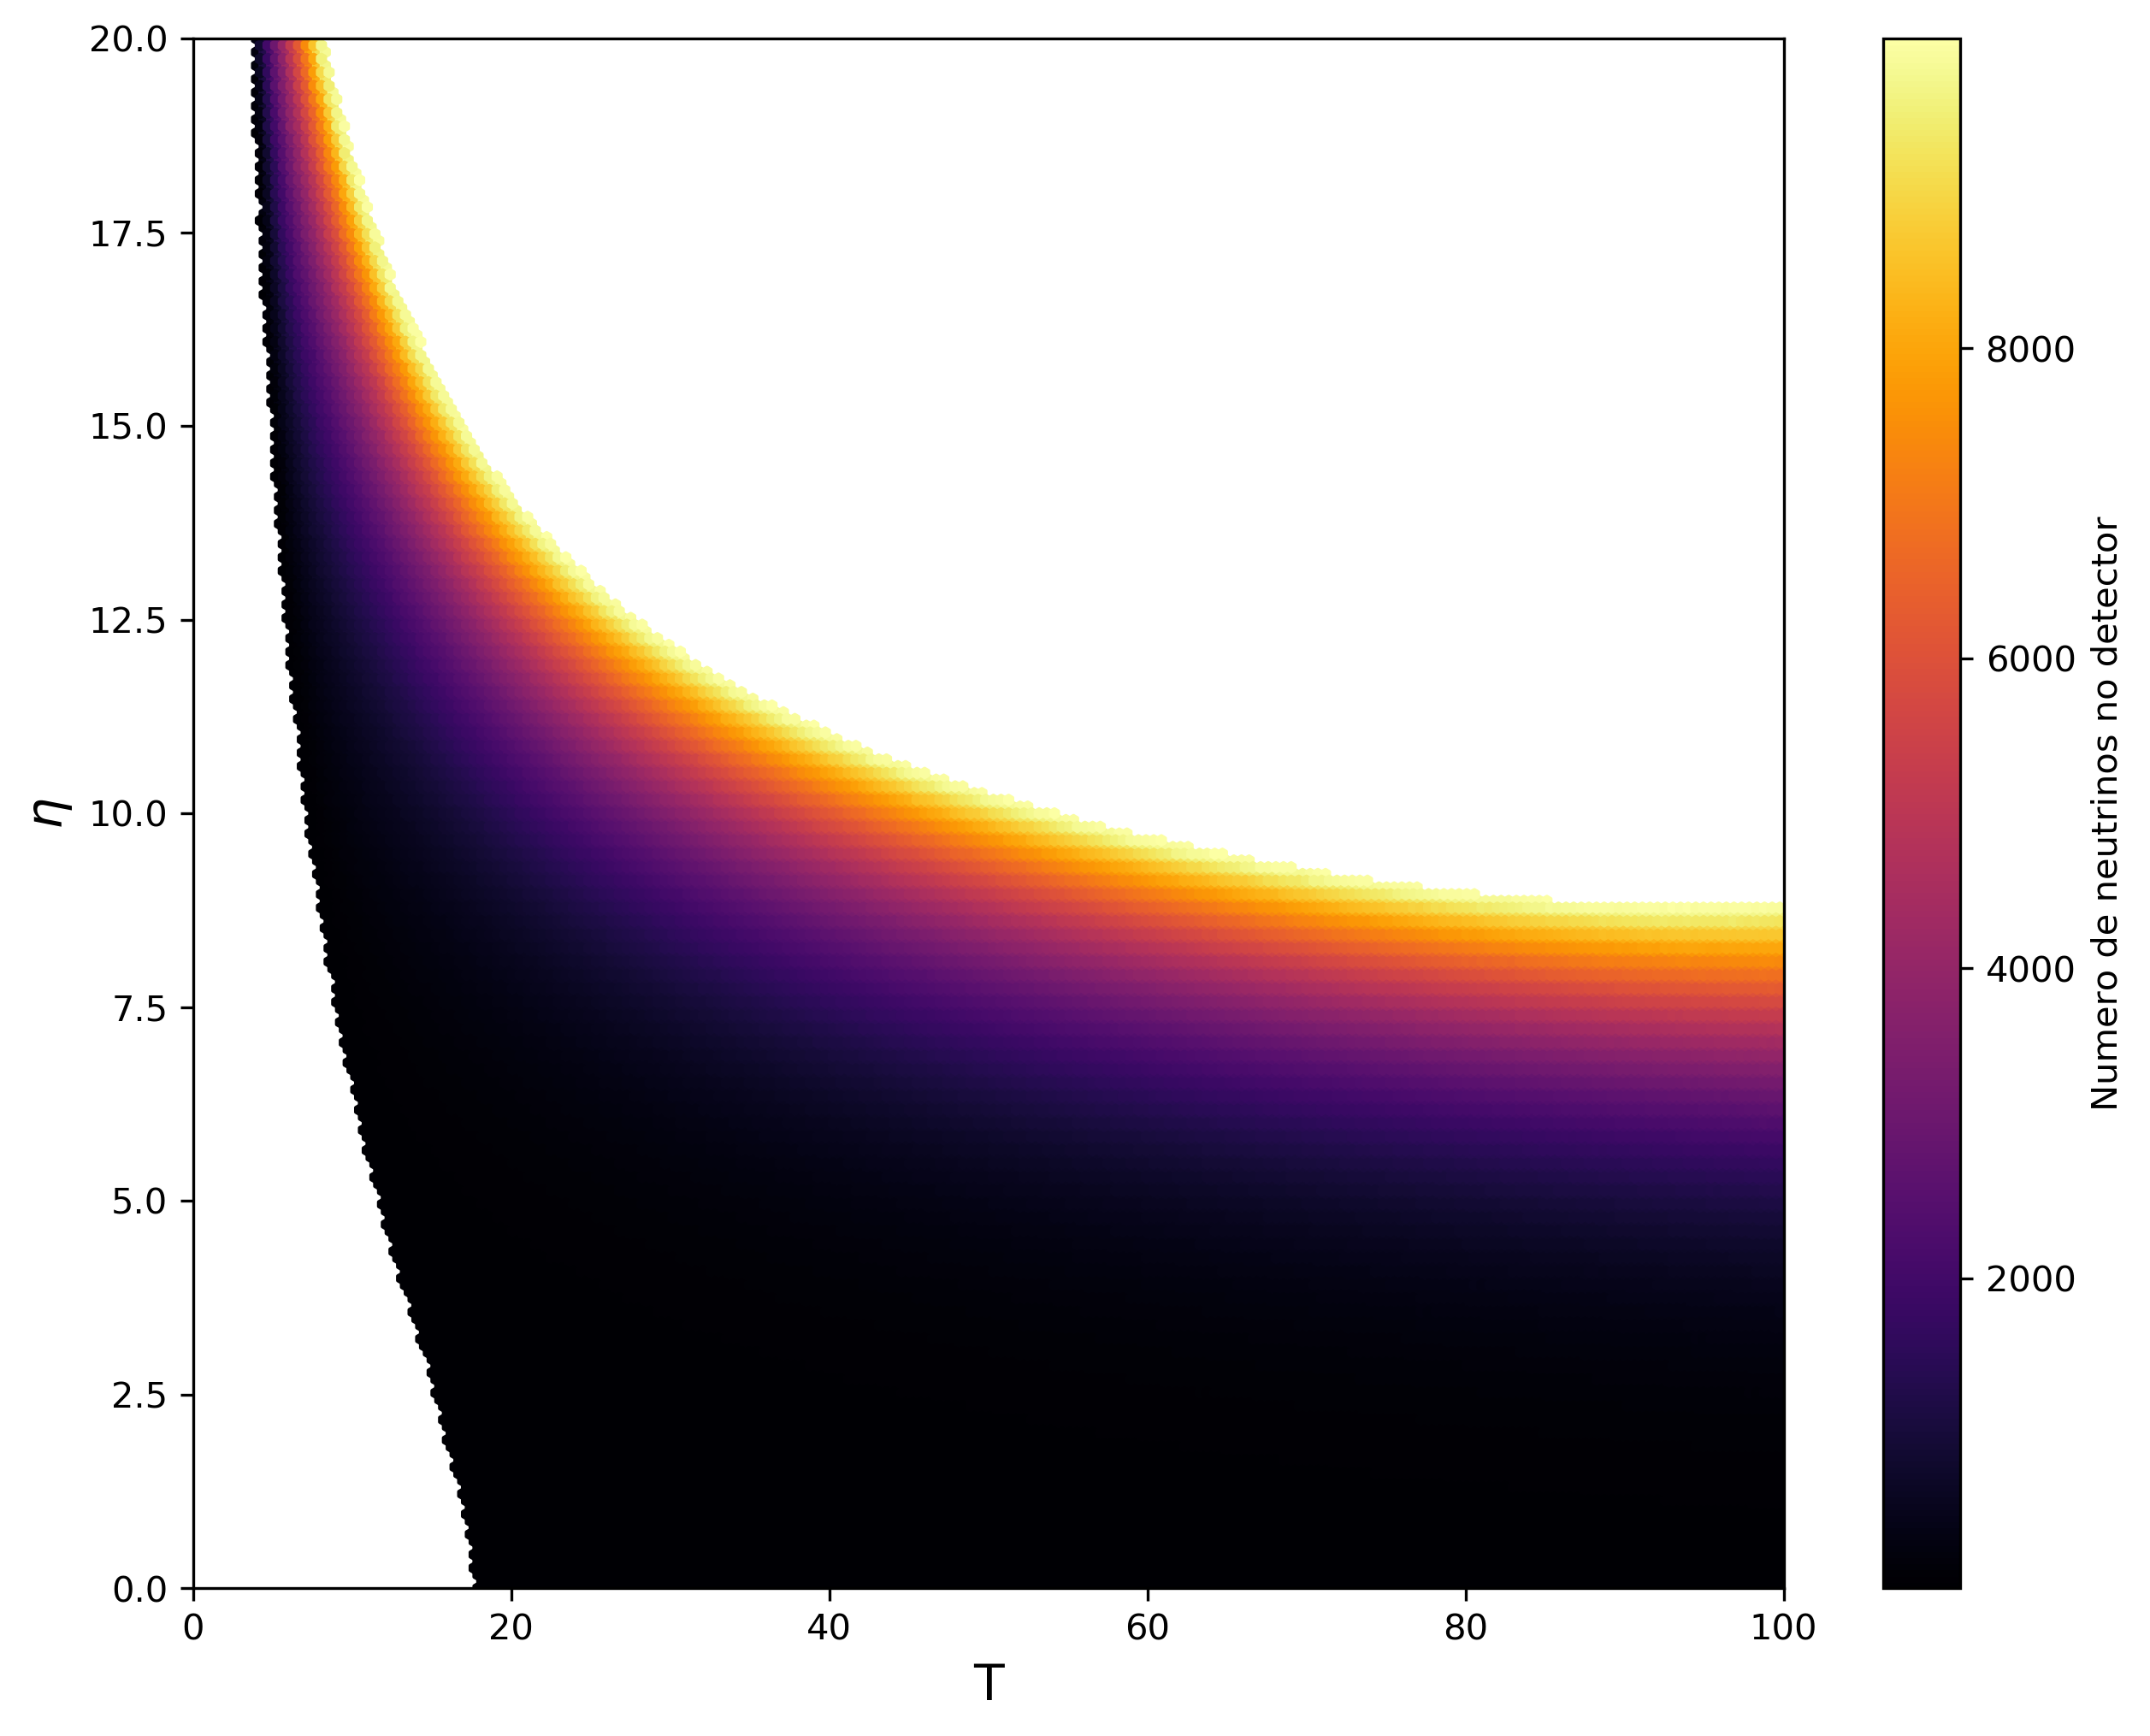

In [342]:
plt.figure(figsize=(10,8), dpi = 300)
cs = plt.hexbin(T_d2, eta_d2, C=events2, gridsize=200, cmap='inferno', bins=None)
plt.colorbar(cs, label = 'Numero de neutrinos no detector')
plt.xlabel('T', fontsize = 14)
plt.ylabel('$\eta$', fontsize = 14)
plt.xlim(0, 100)
plt.ylim(0, 20)

In [336]:
ets = []
r = []

for i in range(10000):
    et = np.random.uniform(0, 20)
    s = simps(detec(E, 20, et), E)
    ets.append(et)
    r.append(s)

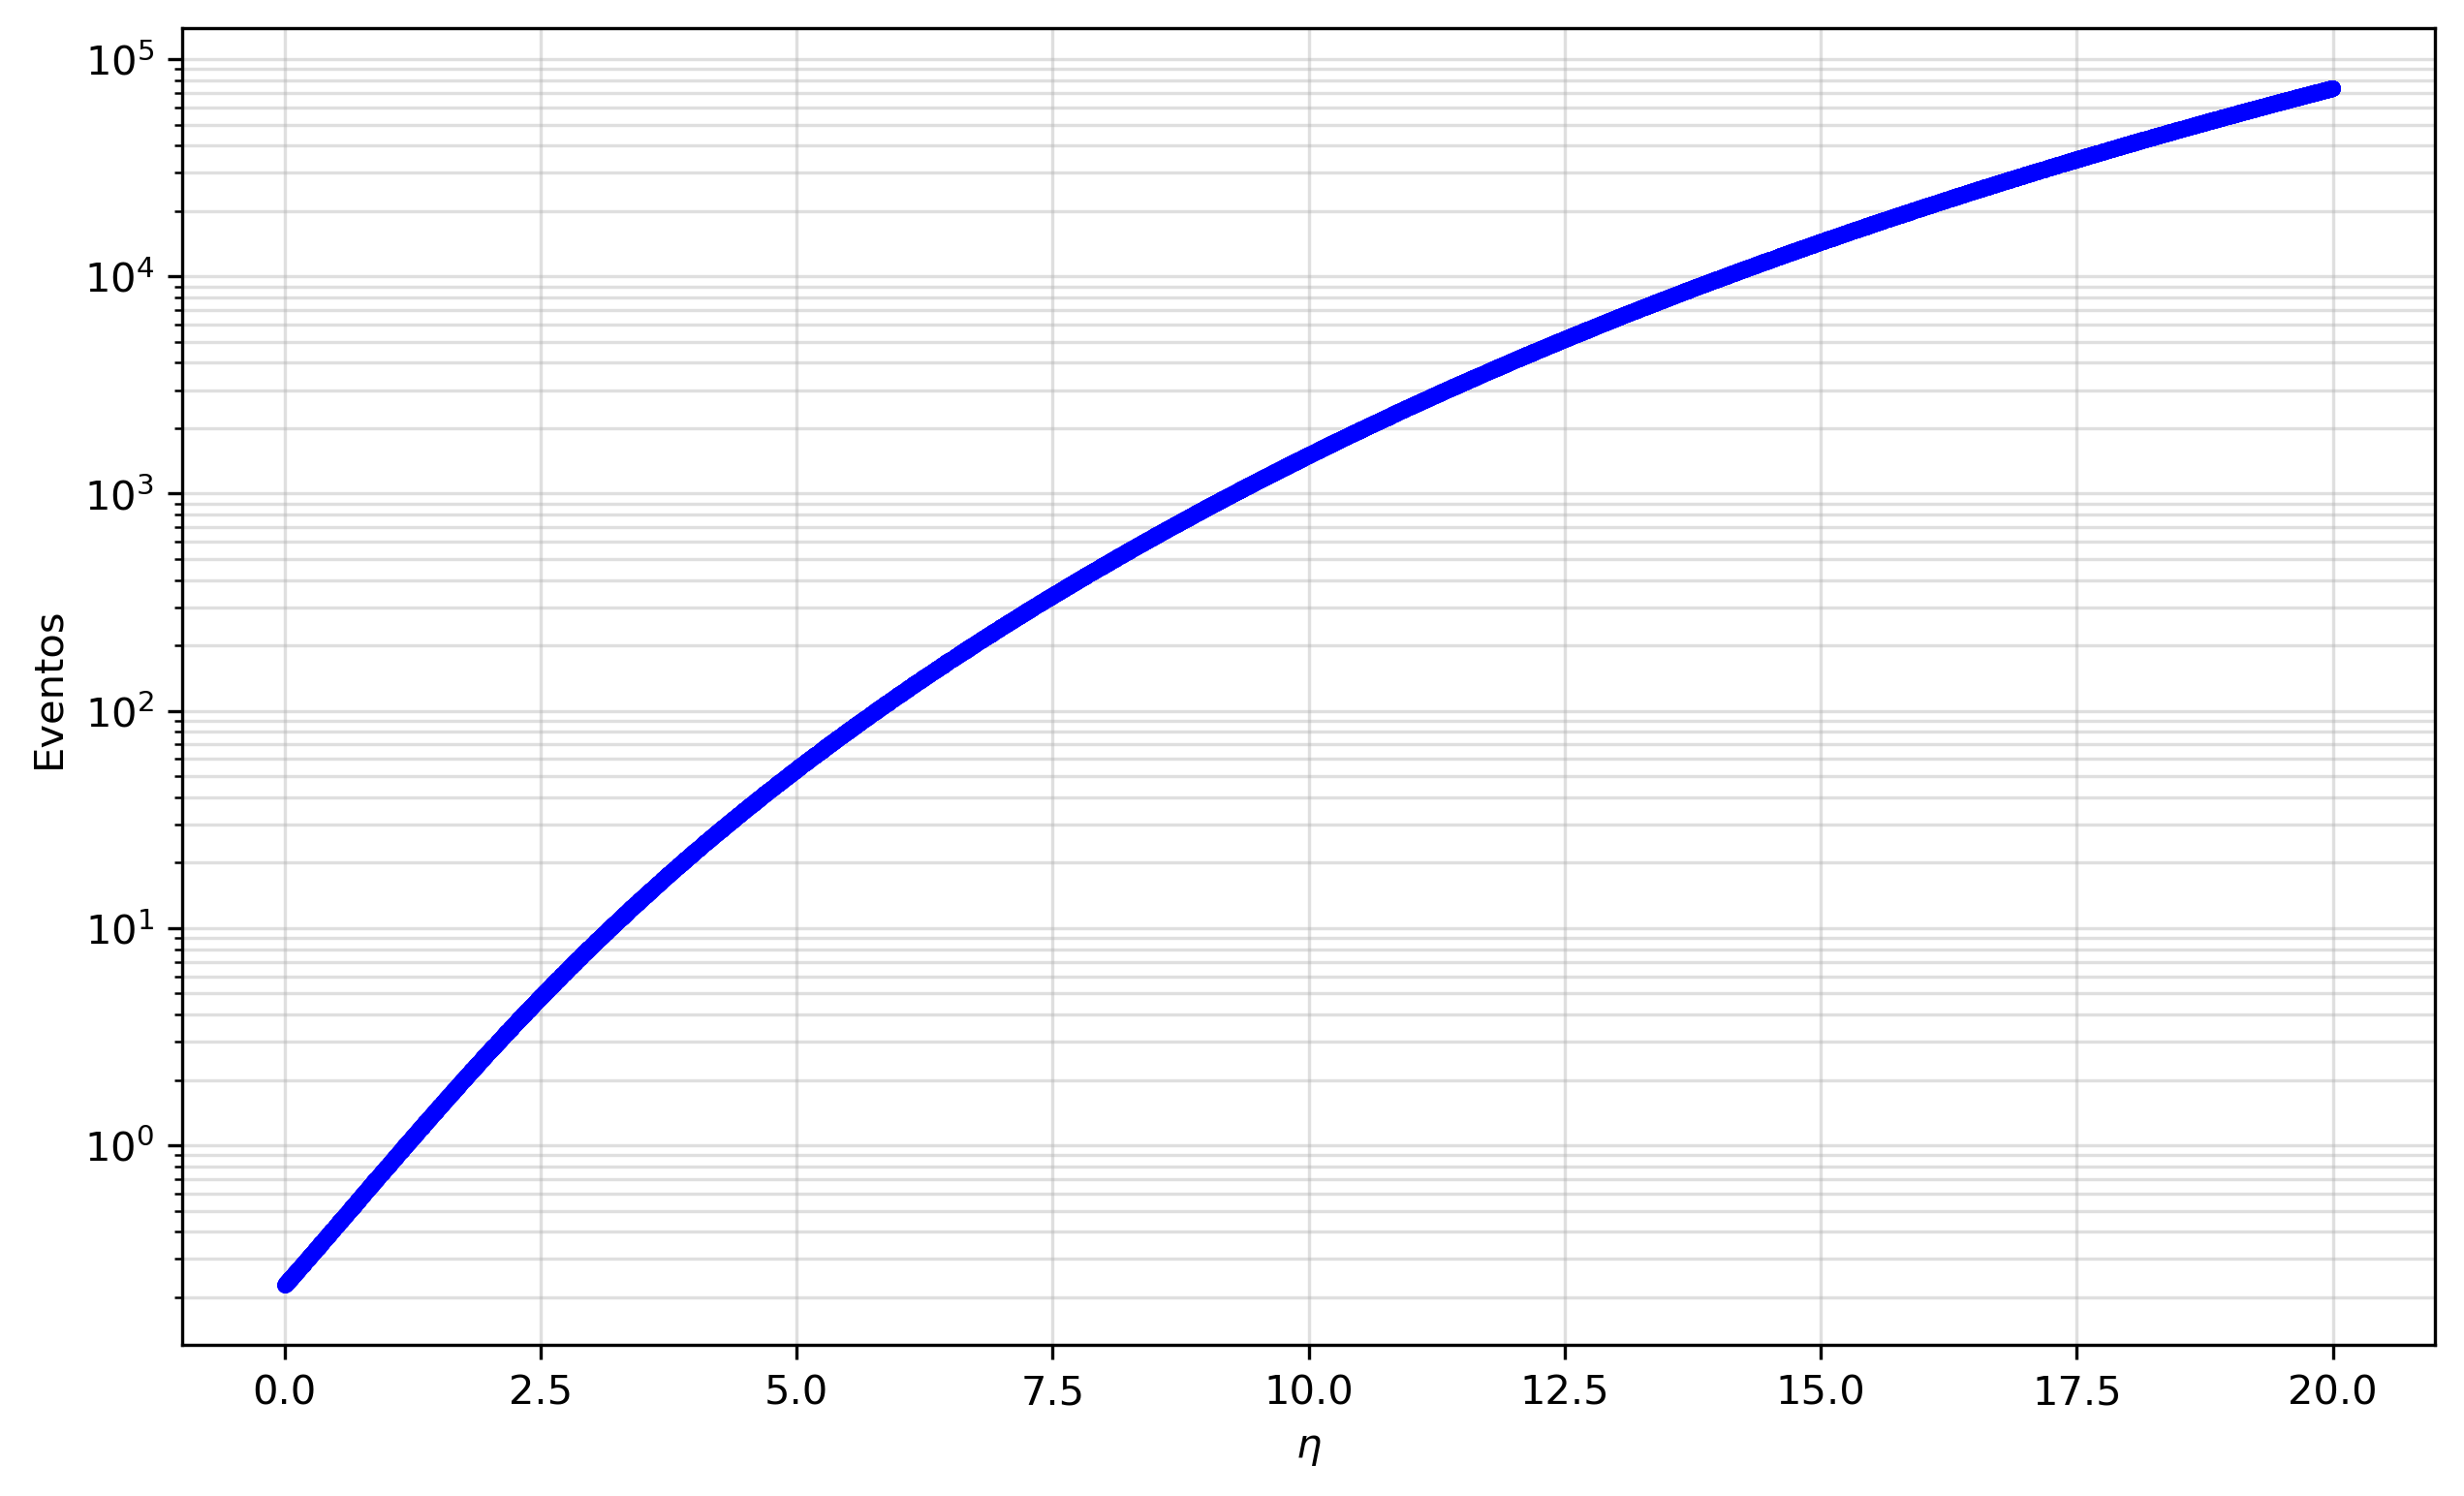

In [343]:
plt.figure(figsize=(10,6), dpi = 300)
plt.grid(True, which = 'both', alpha = 0.4)
plt.plot(ets, r, 'b.')
plt.xlabel(r'$\eta$')
plt.ylabel('Eventos')
plt.yscale('log')

## Another small parenthesis to check how the observable mean energy and the emitted mean energy change with T and \eta

In [426]:
E_emit = []
E_detec = []

for i in range(10000):
    T = np.random.uniform(0, 100)
    eta = np.random.uniform(0, 20)
    detc = simps(E*detec(E, T, eta), E)/simps(detec(E, T, eta), E)
    emit = simps(E*spec(E, T, eta), E)/simps(spec(E, T, eta), E)
    if detc >= 0 and emit >= 0:
        if np.abs(detc - emit) <= 50:
            E_emit.append(emit)
            E_detec.append(detc)

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


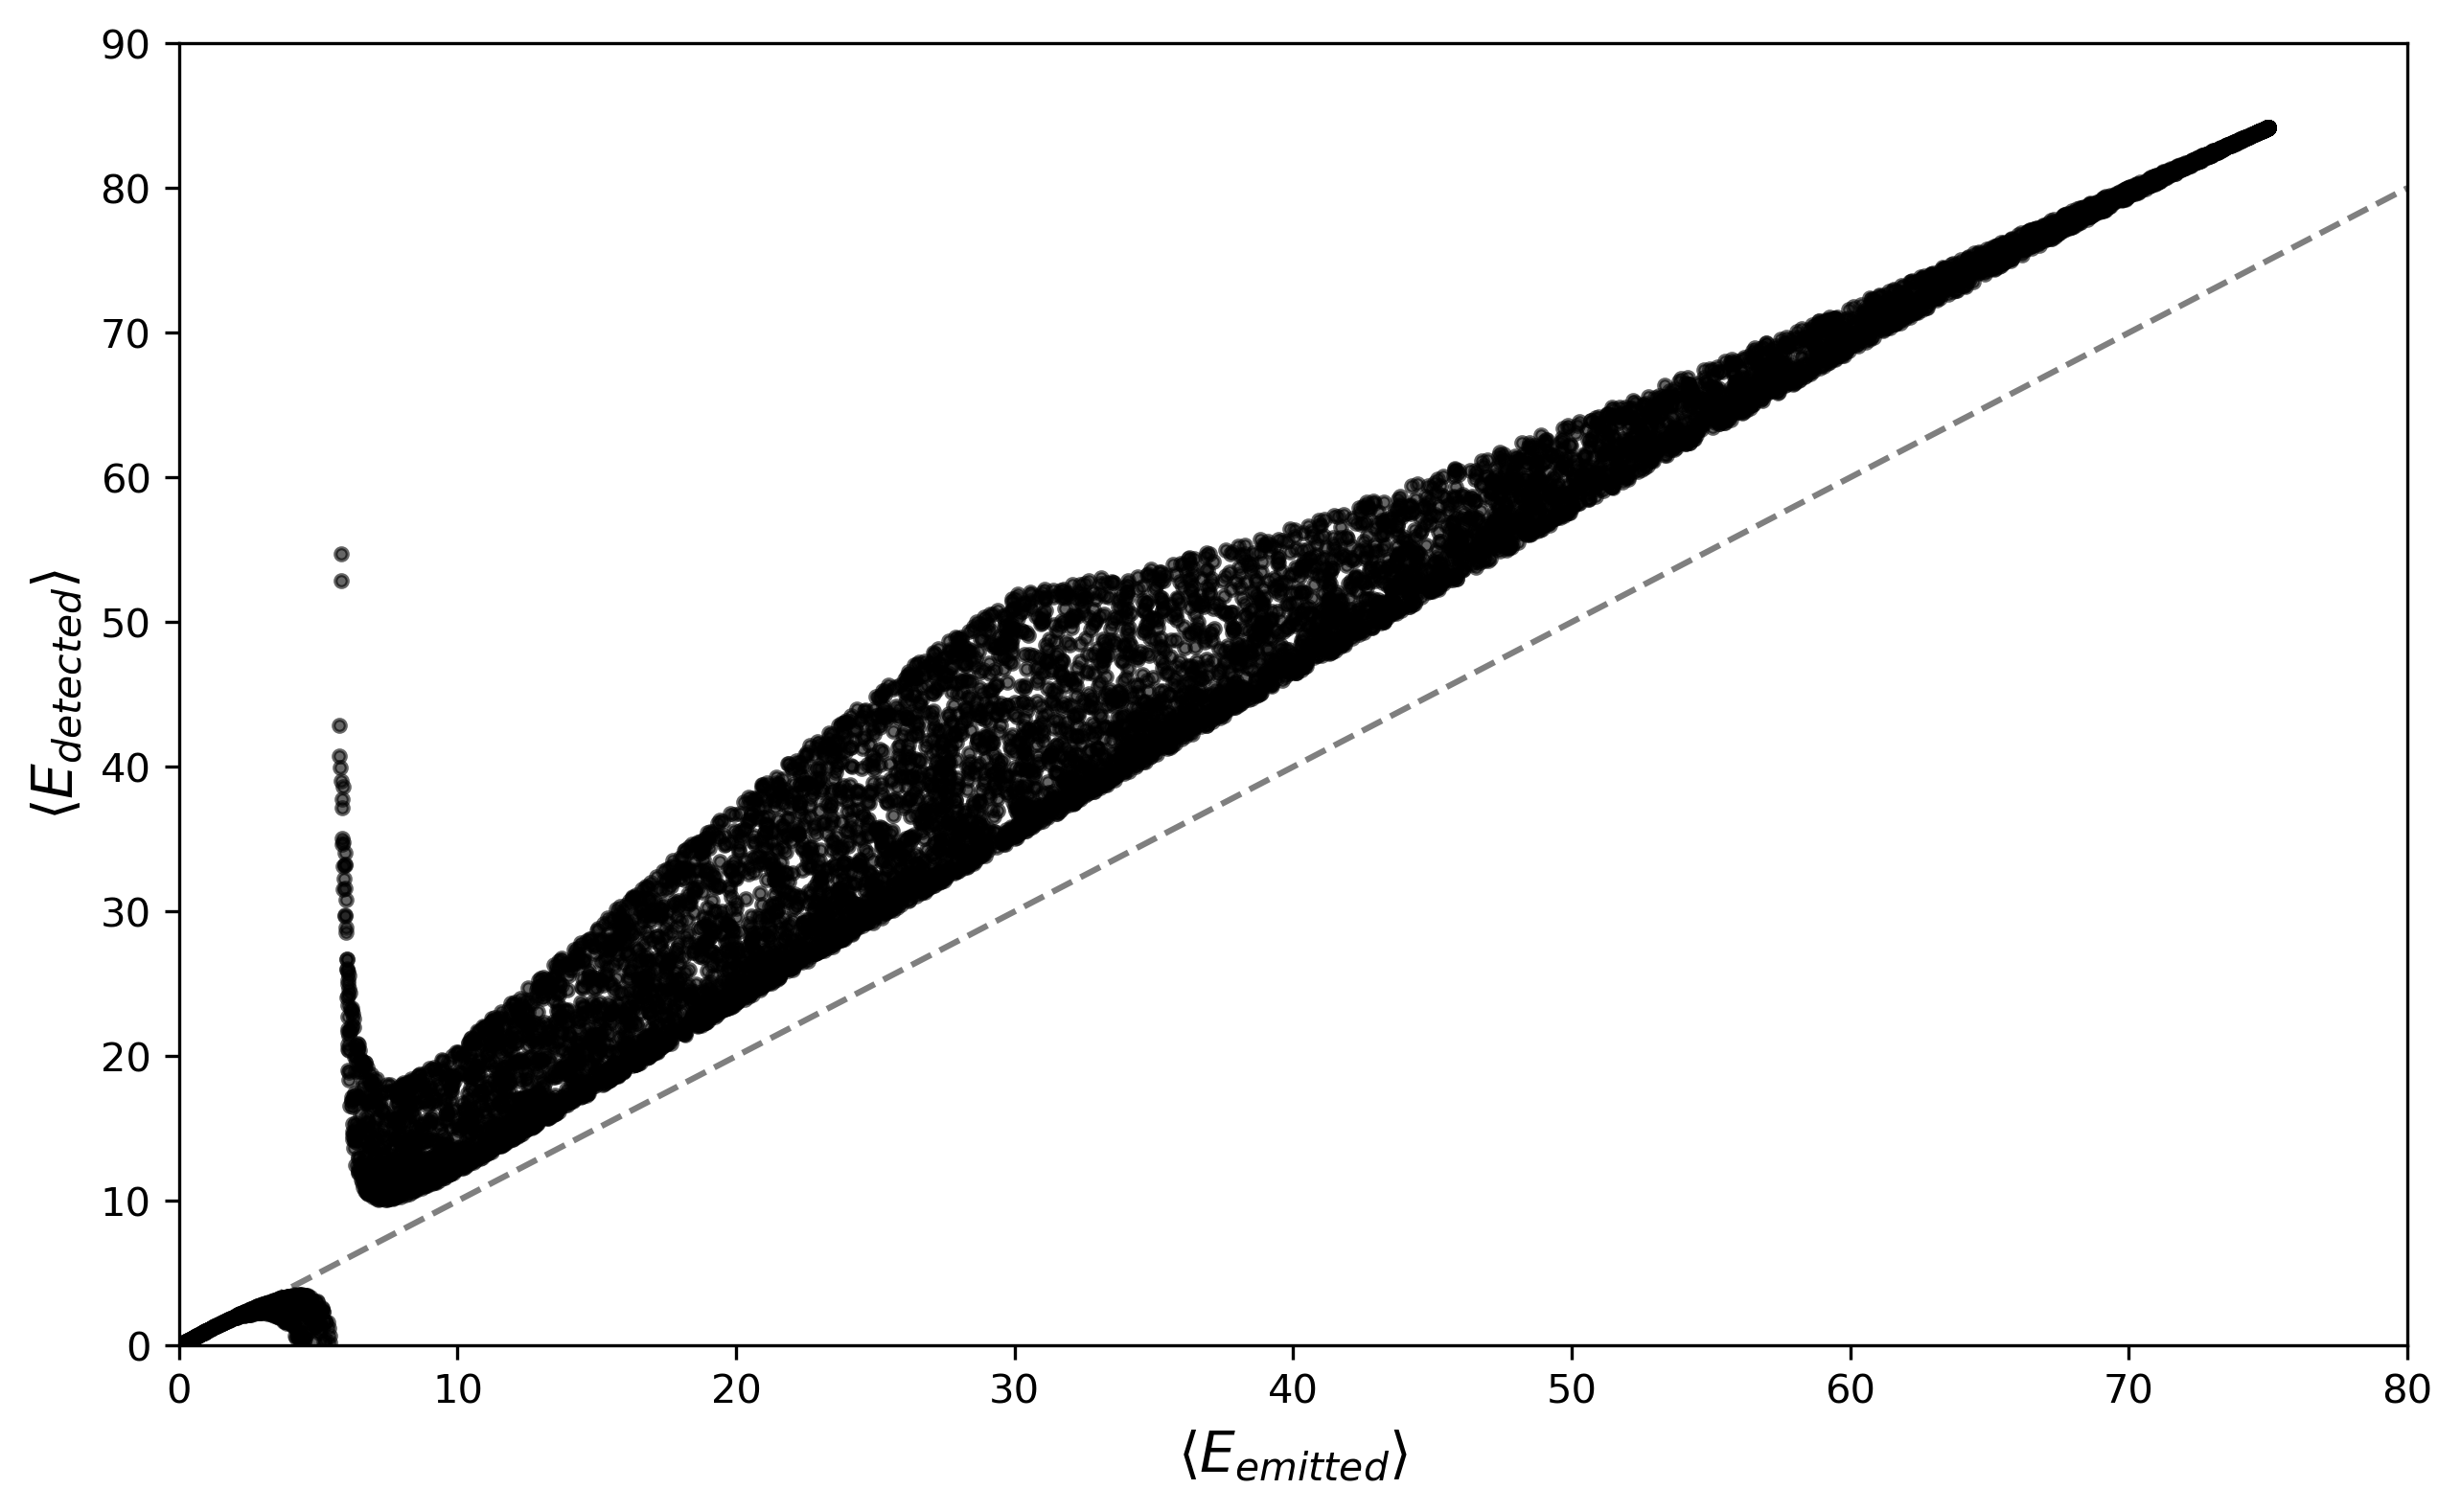

In [552]:
x = np.linspace(0, 80, len(E_emit))

plt.figure(figsize=(10,6), dpi = 300)
#plt.grid(True, which = 'both', alpha = 0.4)
plt.plot(E_emit, E_detec, 'k.', alpha = 0.6)
plt.plot(x, x, color = 'black', linestyle = 'dashed', alpha = 0.5)
plt.xlabel(r'$\left \langle E_{emitted} \right \rangle$', fontsize = 14)
plt.ylabel(r'$\left \langle E_{detected} \right \rangle$', fontsize = 14)
plt.xlim(0, 80)
plt.ylim(0, 90)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/MeanEnergies.pdf')

R^2 score: 0.971785214479155
R^2 score: 0.9632847684448708


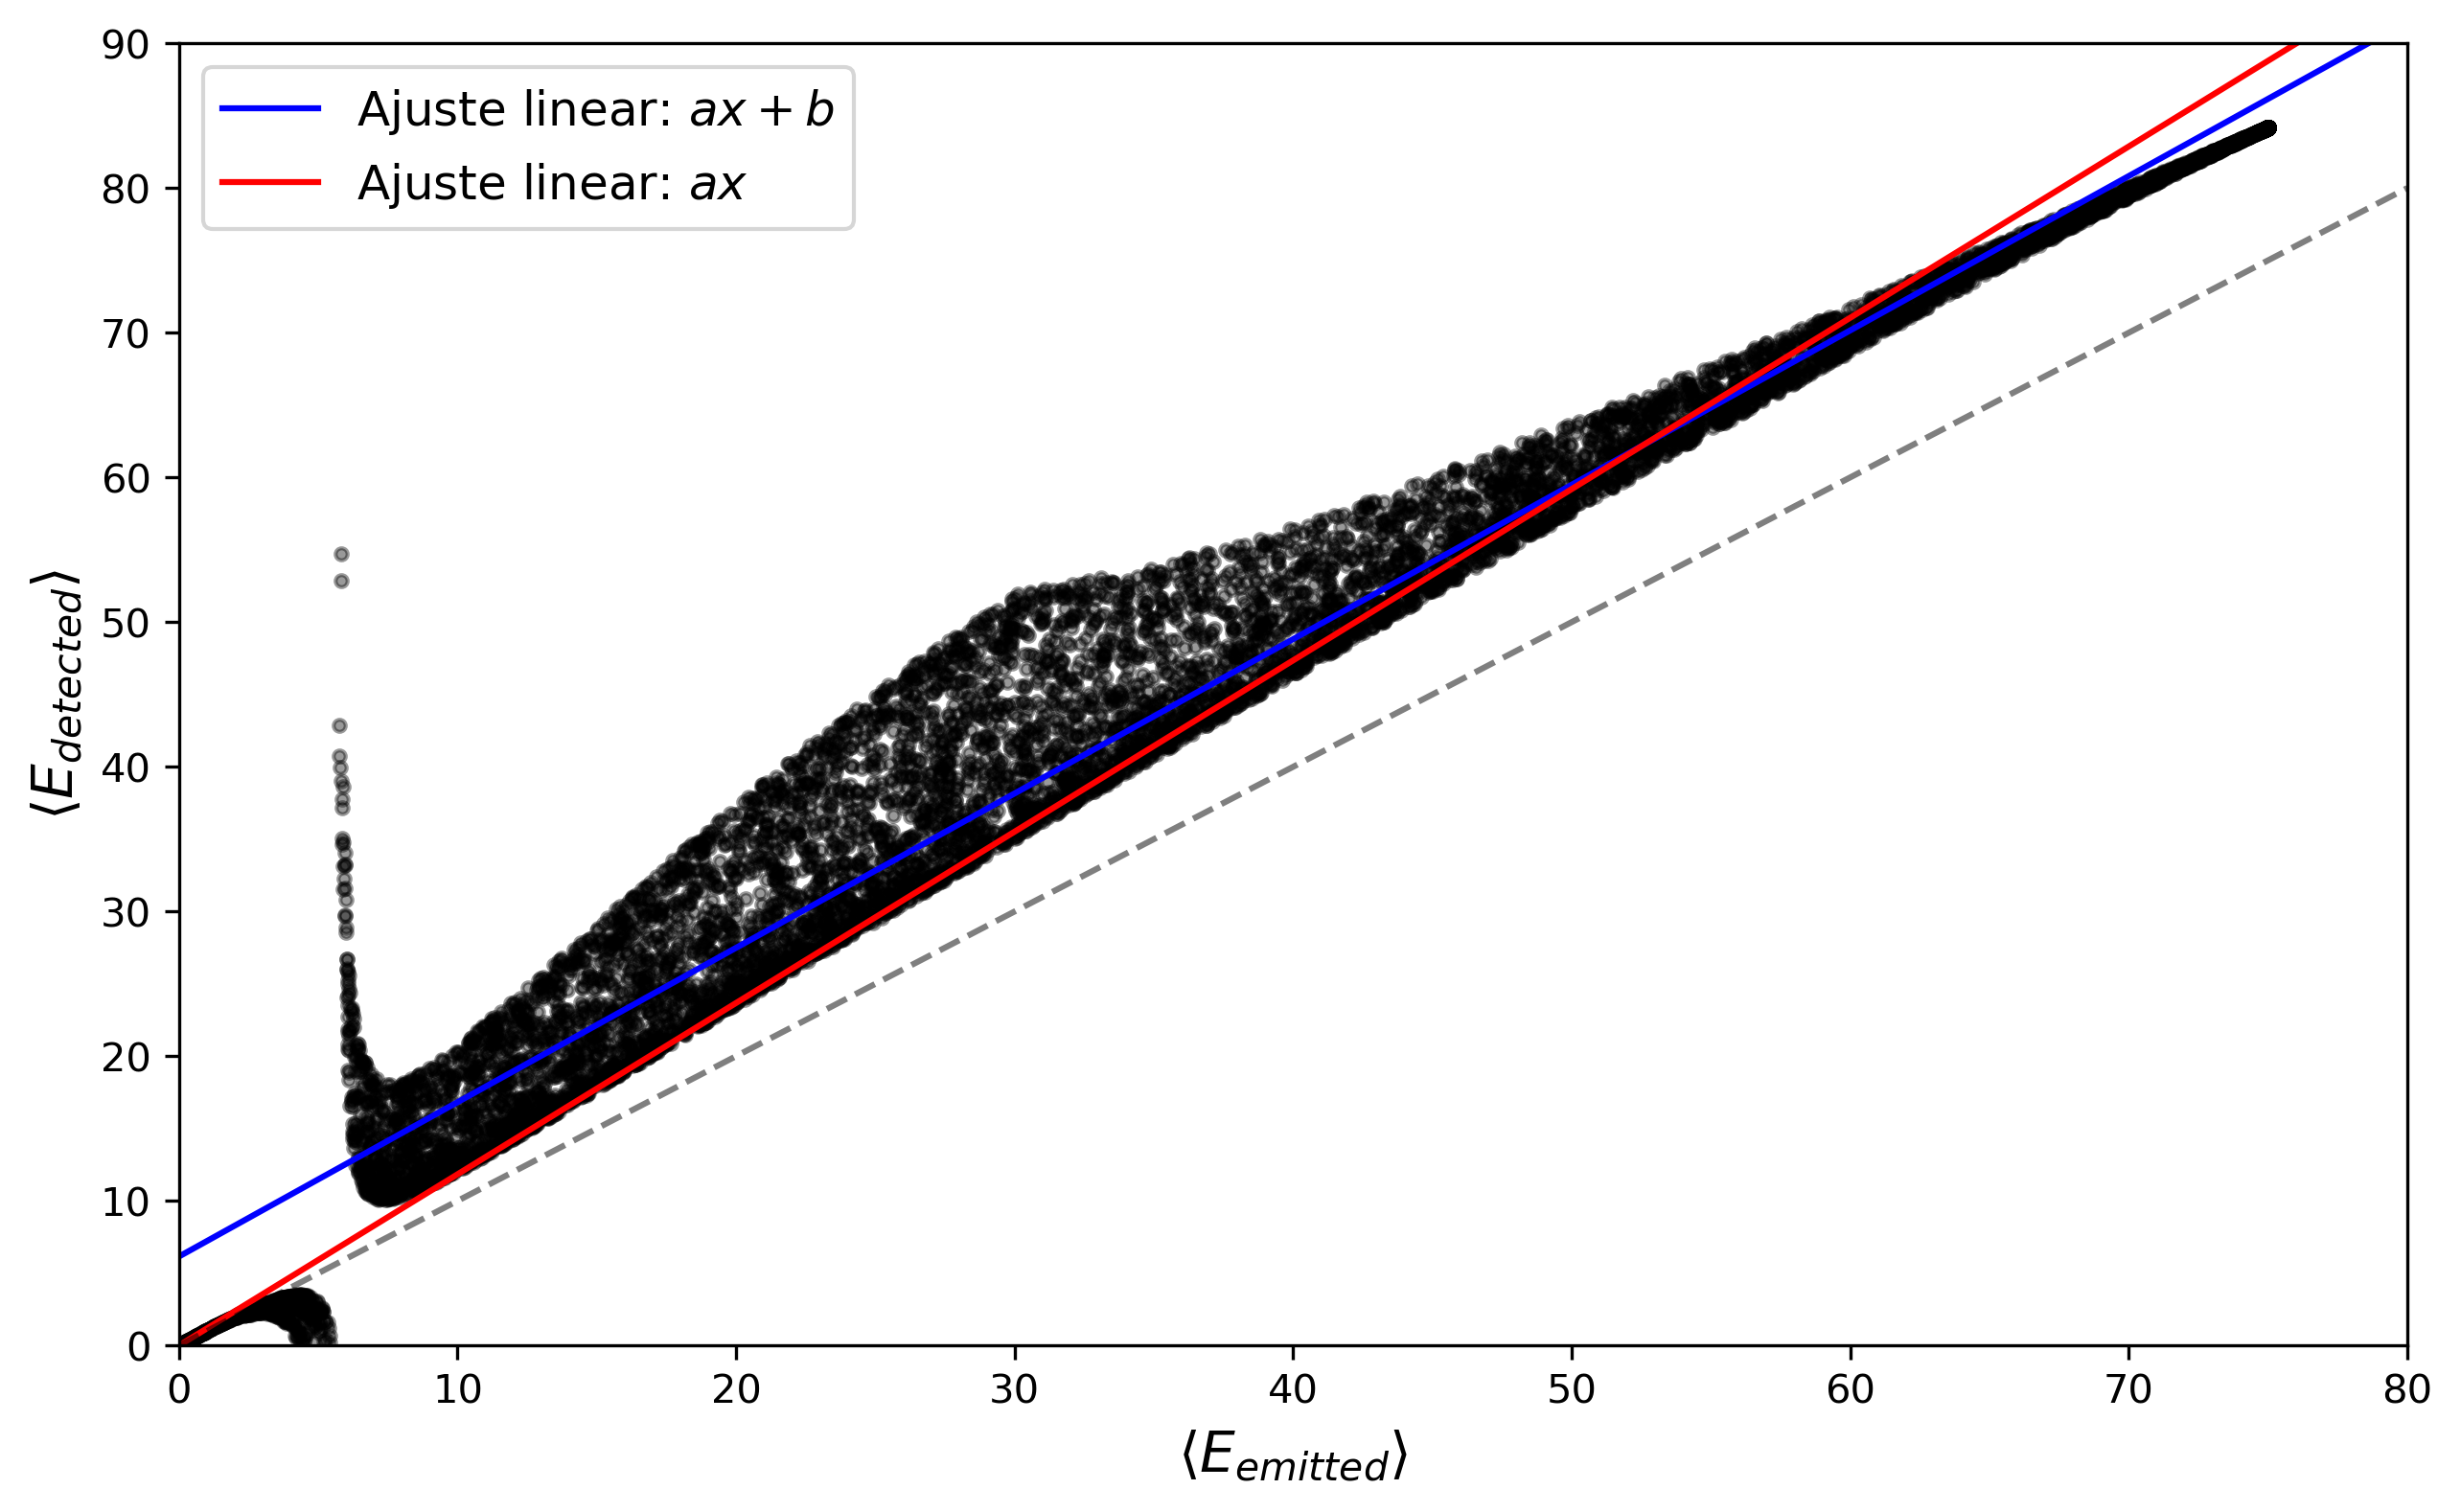

In [437]:
def lin(x, a, b):
    return a*x + b

def slope(x, a):
    return x*a

x = np.linspace(0, 80, len(E_emit))

c, cov = curve_fit(lin, E_emit, E_detec)
c_slope, cov_slope = curve_fit(slope, E_emit, E_detec)

linopt = lin(np.array(E_emit), c[0], c[1])
slopeopt = slope(np.array(E_emit), c_slope[0])

print(f'R^2 score: {r2_score(linopt, E_detec)}')
print(f'R^2 score: {r2_score(slopeopt, E_detec)}')

plt.figure(figsize=(10,6), dpi = 300)
plt.plot(E_emit, E_detec, 'k.', alpha = 0.4)
plt.plot(x, lin(x, c[0], c[1]), color = 'blue', label = r'Ajuste linear: $ax + b$')
plt.plot(x, slope(x, c_slope[0]), color = 'red', label = r'Ajuste linear: $ax$')
plt.plot(x, x, color = 'black', linestyle = 'dashed', alpha = 0.5)
plt.xlabel(r'$\left \langle E_{emitted} \right \rangle$', fontsize = 14)
plt.ylabel(r'$\left \langle E_{detected} \right \rangle$', fontsize = 14)
plt.xlim(0, 80)
plt.ylim(0, 90)
plt.legend(loc = 'upper left', fontsize = 12)

30.316965790498664
26.814632801417773


([<matplotlib.axis.XTick at 0x7f2a39e71790>,
 <a list of 2 Text xticklabel objects>)

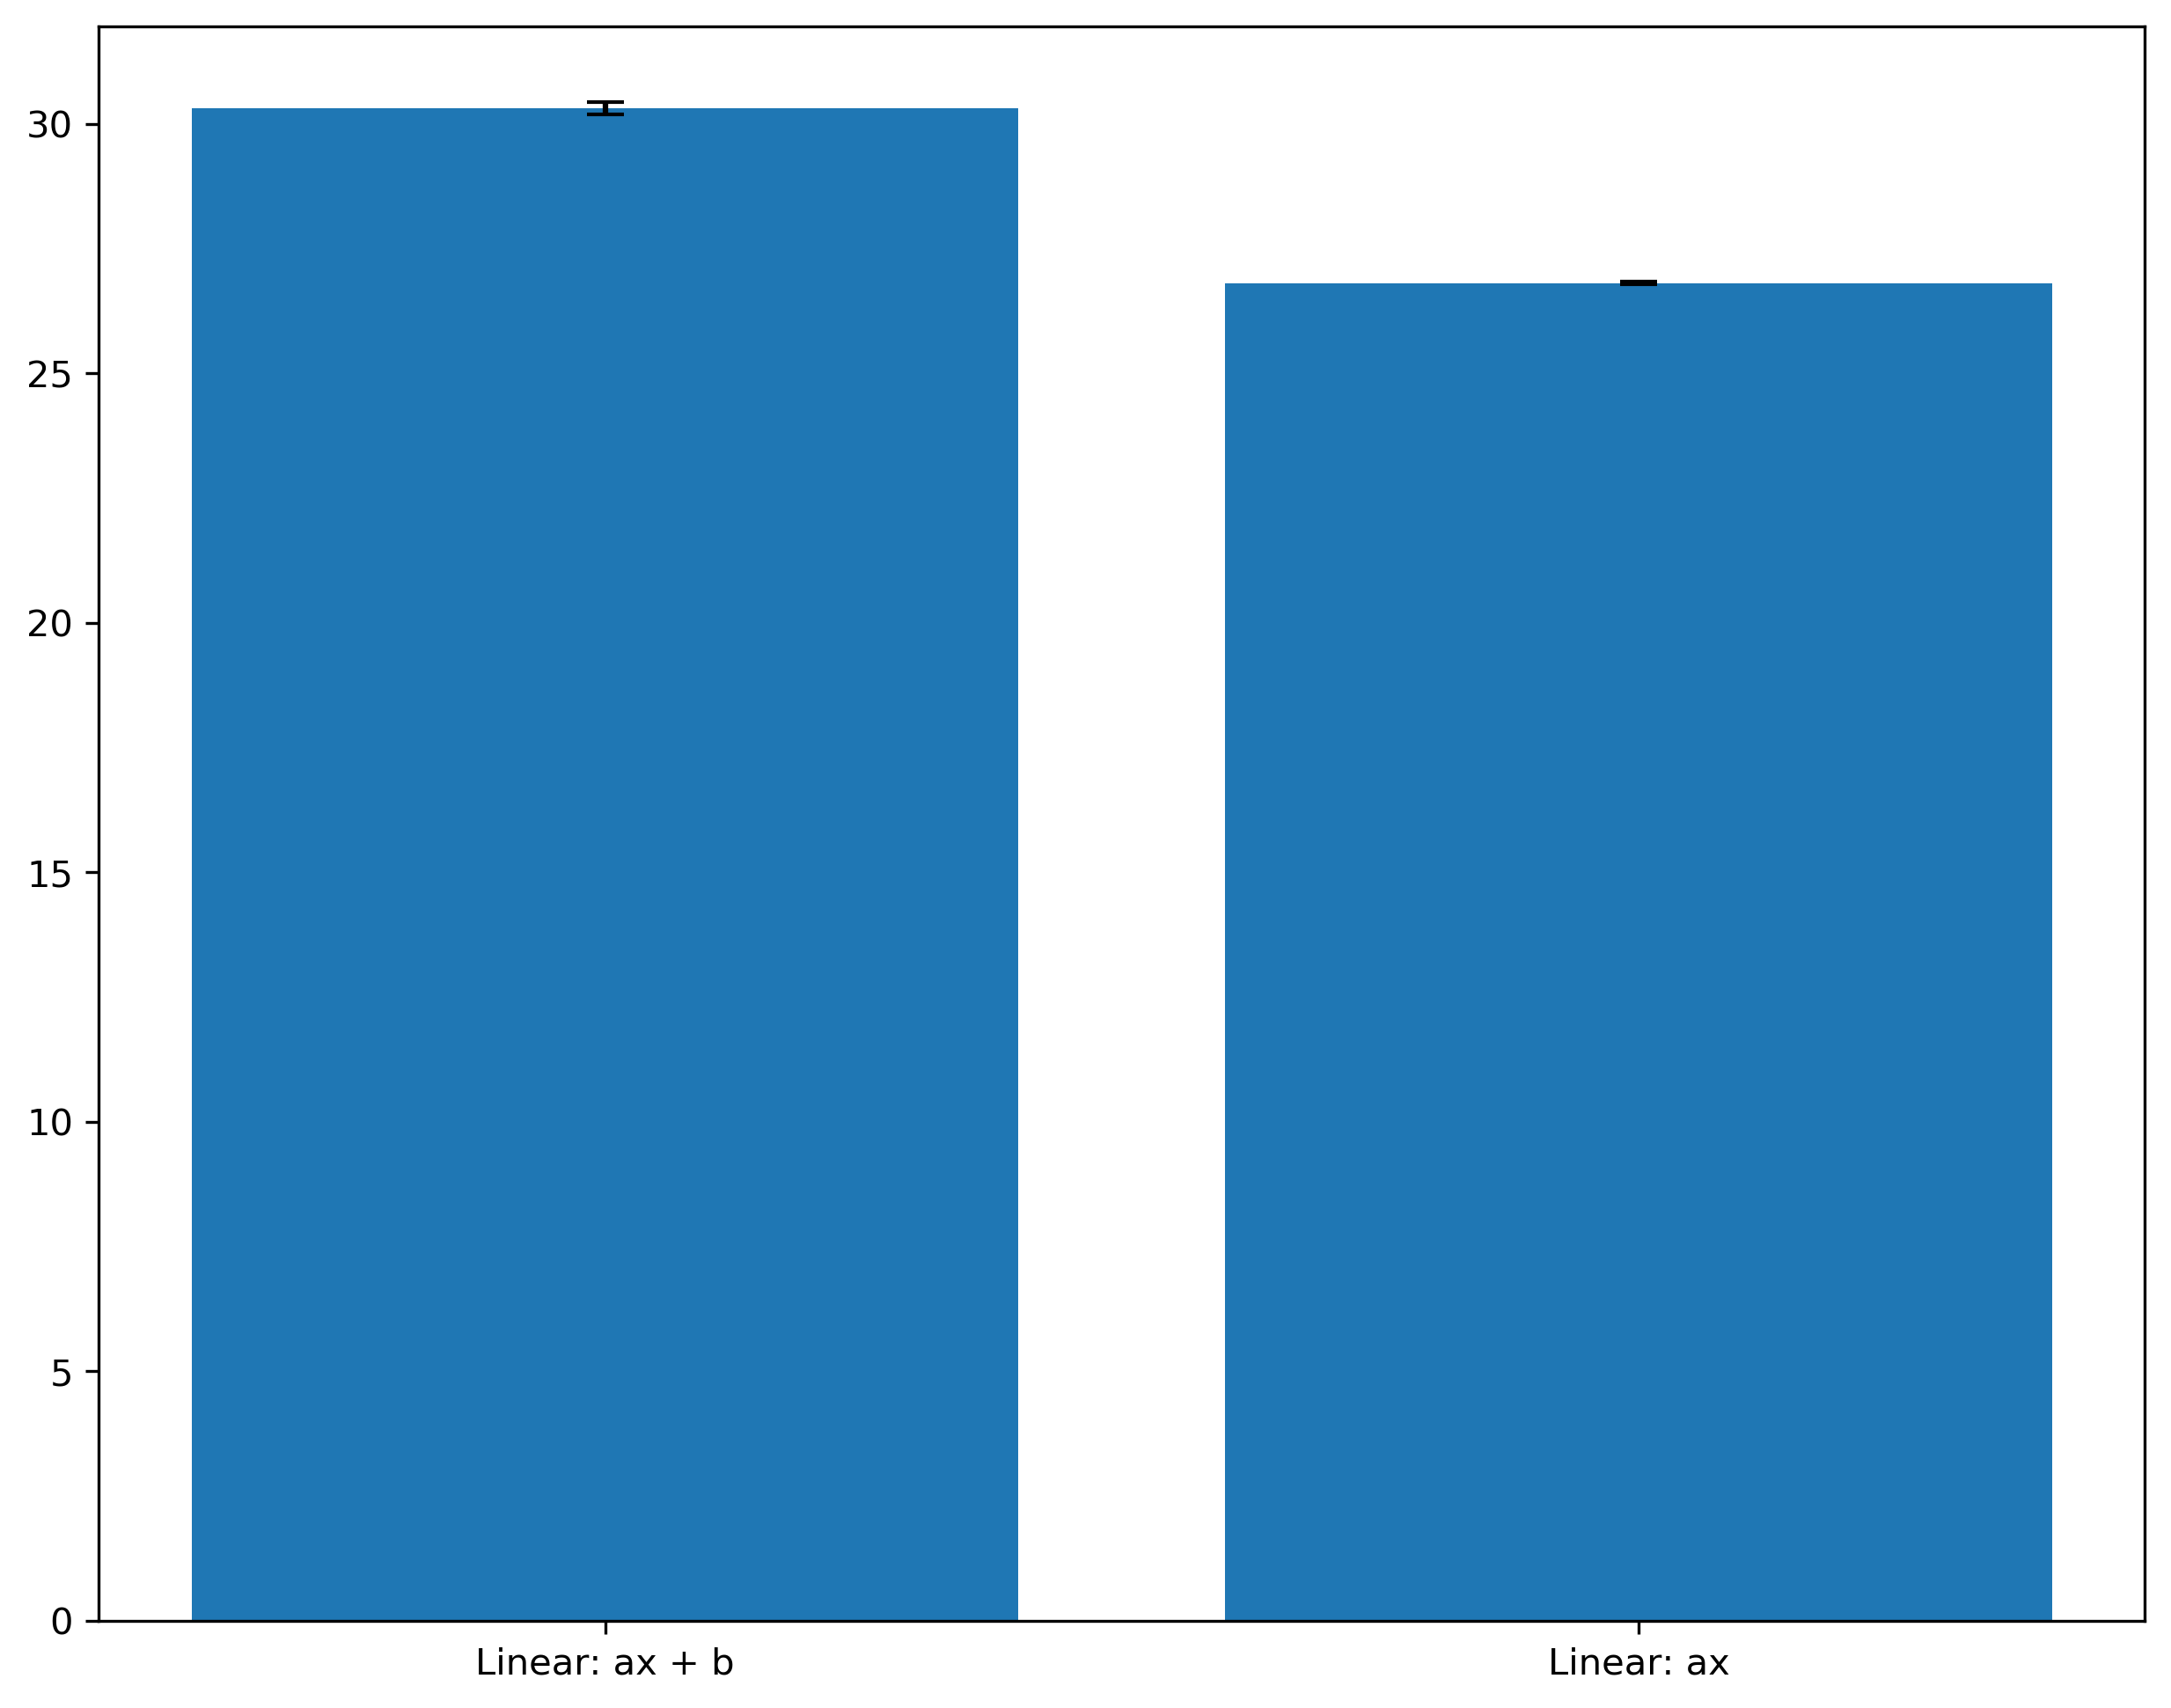

In [440]:
print(lin(22.65, c[0], c[1]))
print(slope(22.65, c_slope[0]))

x_bar = [1,2]
bar = [lin(22.65, c[0], c[1]), slope(22.65, c_slope[0])]
bar_err = [lin(22.65, cov[0,0]**0.5, cov[1,1]**0.5), slope(22.65, cov_slope[0,0]**0.5)]
labels = ['Linear: ax + b', 'Linear: ax']

plt.figure(figsize=(10,8), dpi = 300)
plt.bar(x_bar, bar)
plt.errorbar(x_bar, bar, yerr = bar_err, color = 'black', fmt = 'none', capsize = 5)
plt.xticks(x_bar, labels)

## Resuming with the simulation

How about a plot of this spectrum for a better look?

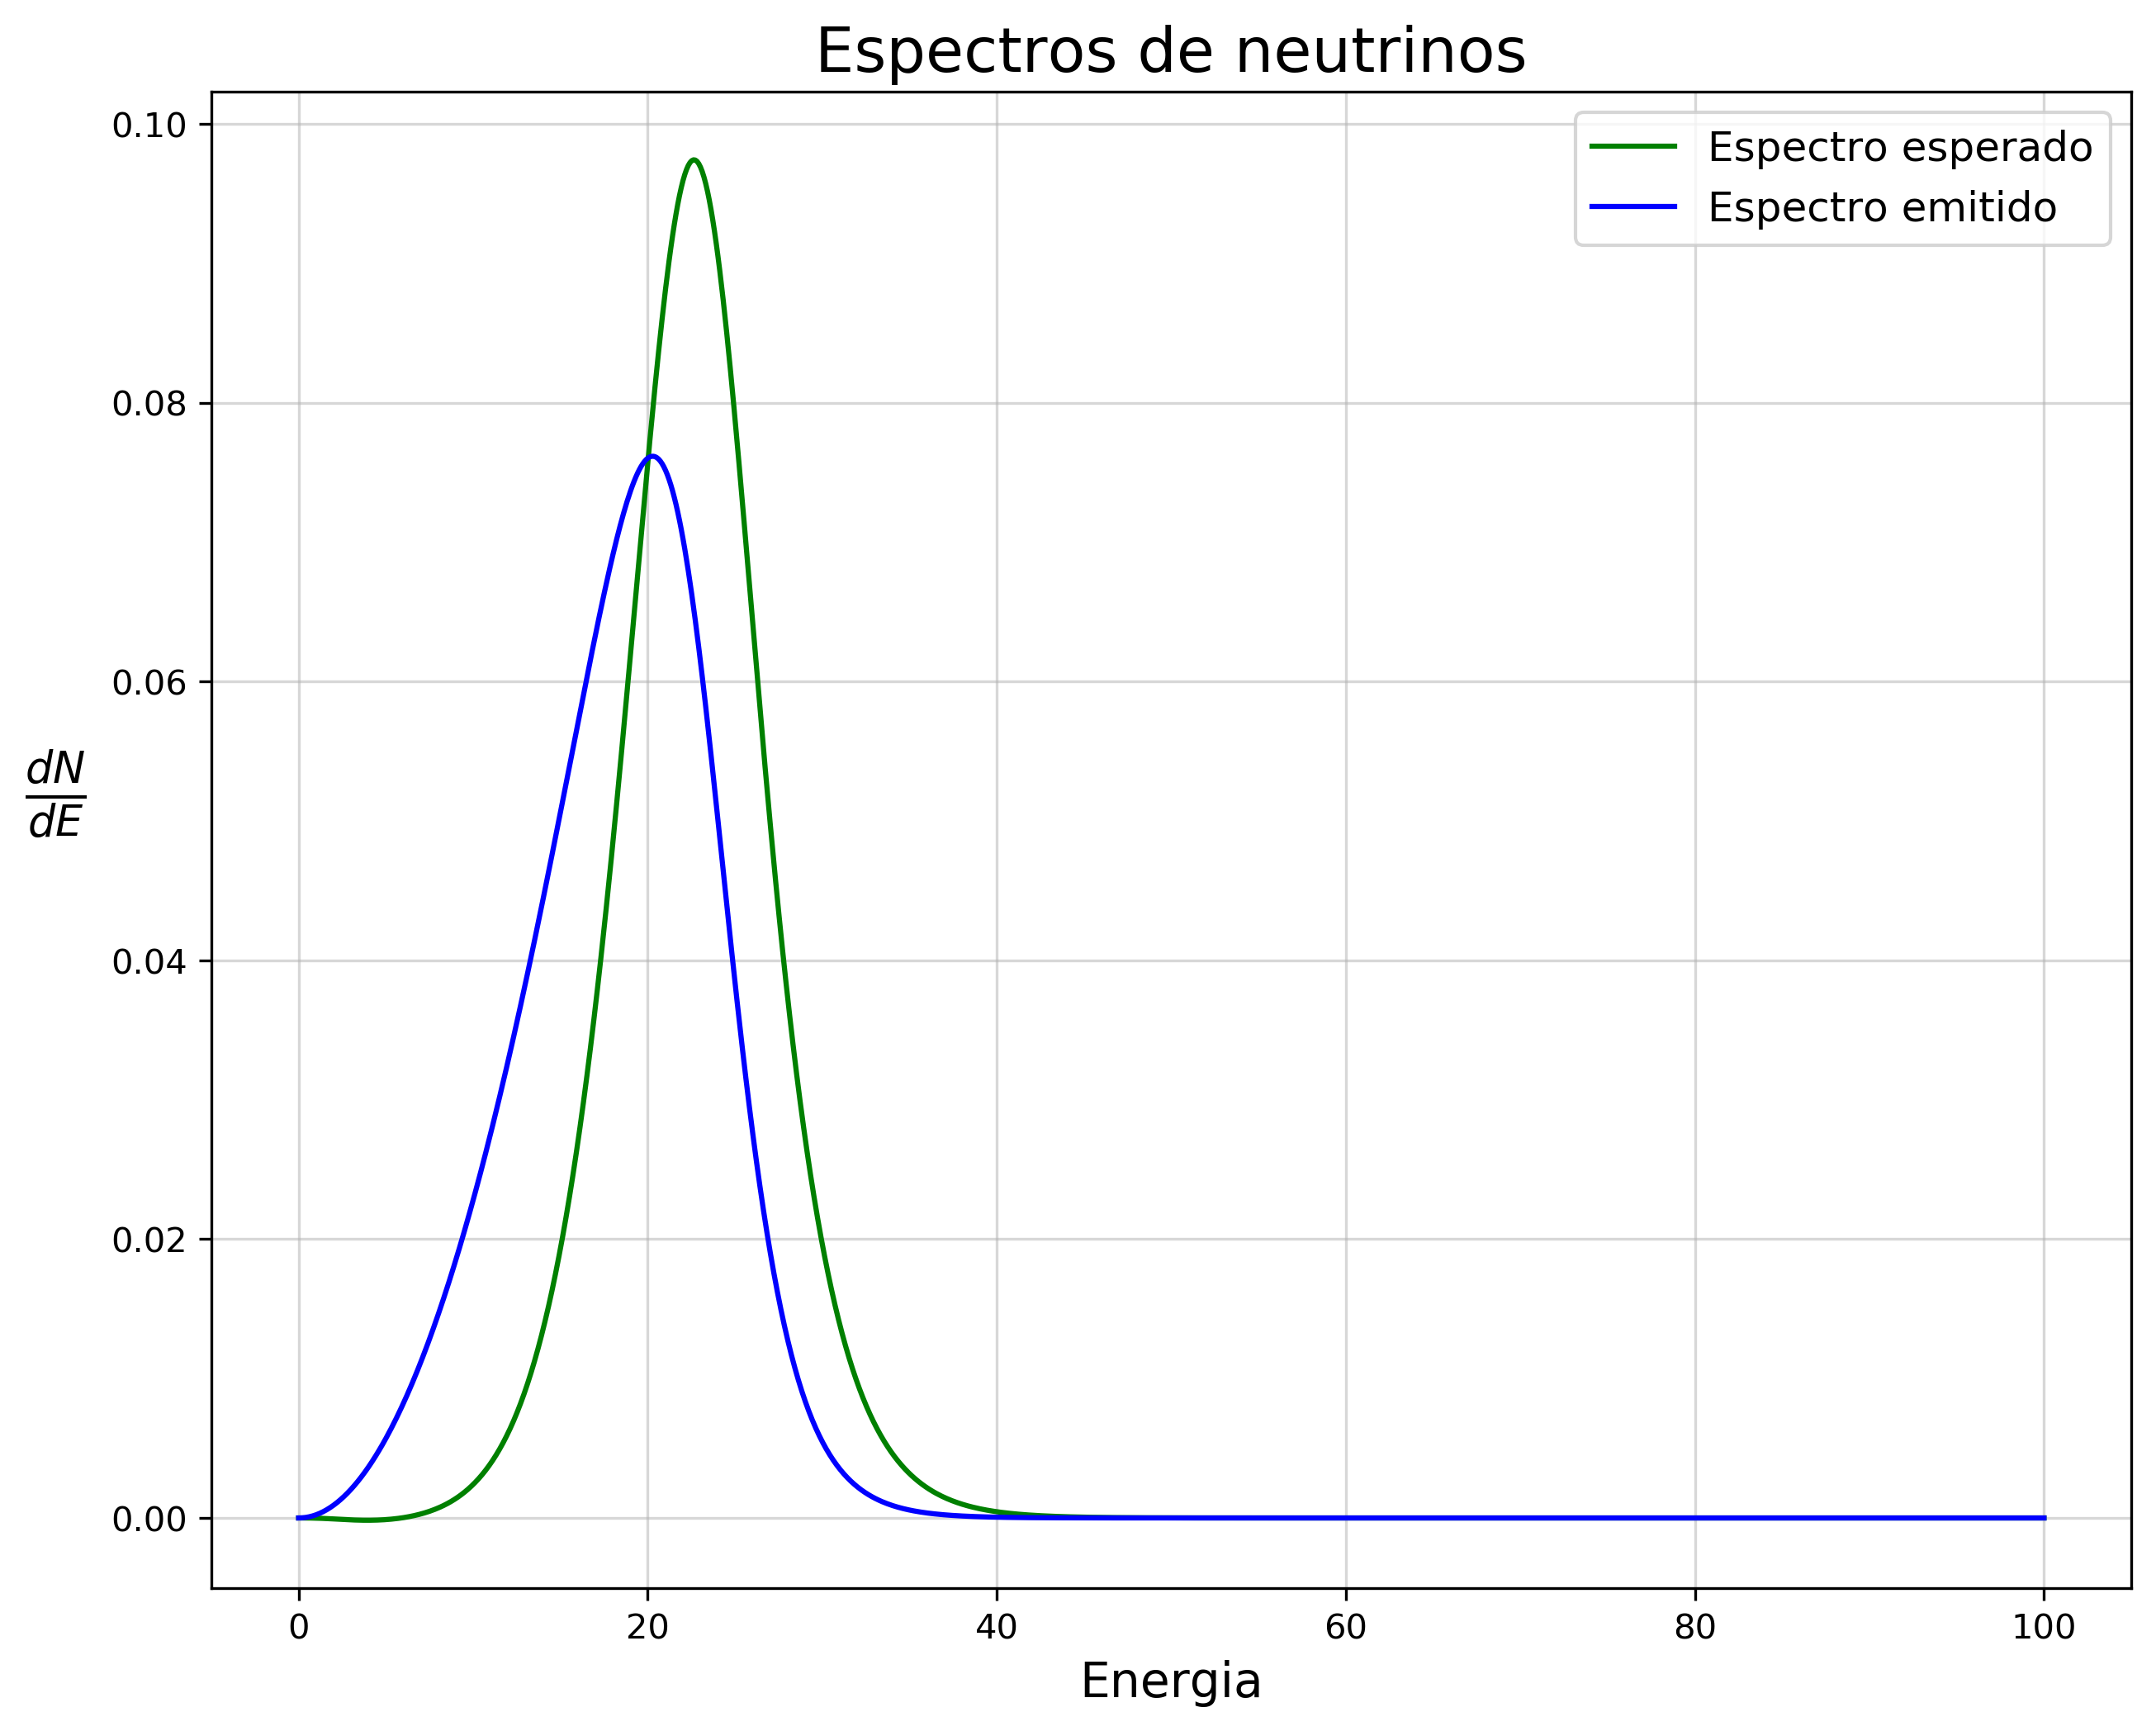

In [400]:
plt.figure(figsize=(10,8), dpi = 300)
plt.grid(True, which = 'both', alpha = 0.5)
plt.plot(E, detec(E, 20, 12)/s0, color = 'green', label = 'Espectro esperado')
plt.plot(E, spec(E, 20, 12)/tot, color = 'blue', label = 'Espectro emitido')
plt.xlabel(r'Energia', fontsize = 14)
plt.ylabel(r'$\frac{dN}{dE}$', rotation = 0, labelpad = 16, fontsize = 18)
#plt.yscale('log')
plt.title('Espectros de neutrinos', fontsize = 18)
plt.legend(fontsize = 12)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/DetecESpec2.pdf')

Sweet, we expect to detect 401 neutrinos in our detector. All of that seems wonderful, but the real world is not so organized and we must introduce a random fluctuations in our detection. That shall be acomplished by creating a poisson distribution centered at $s_0$, we then pick a random number from this distribution and assign it as our new number of detected neutrinos

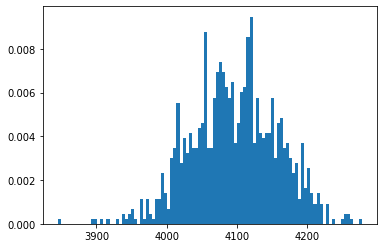

Number chosen = 4082


In [352]:
poiss = np.random.poisson(s0, 1000)
count, bins, ignored = plt.hist(poiss, 100, density=True)
plt.show()
print('Number chosen = %3.f' % poiss[0])

#Lets make it our reference for all future analysis
ref = poiss[0]

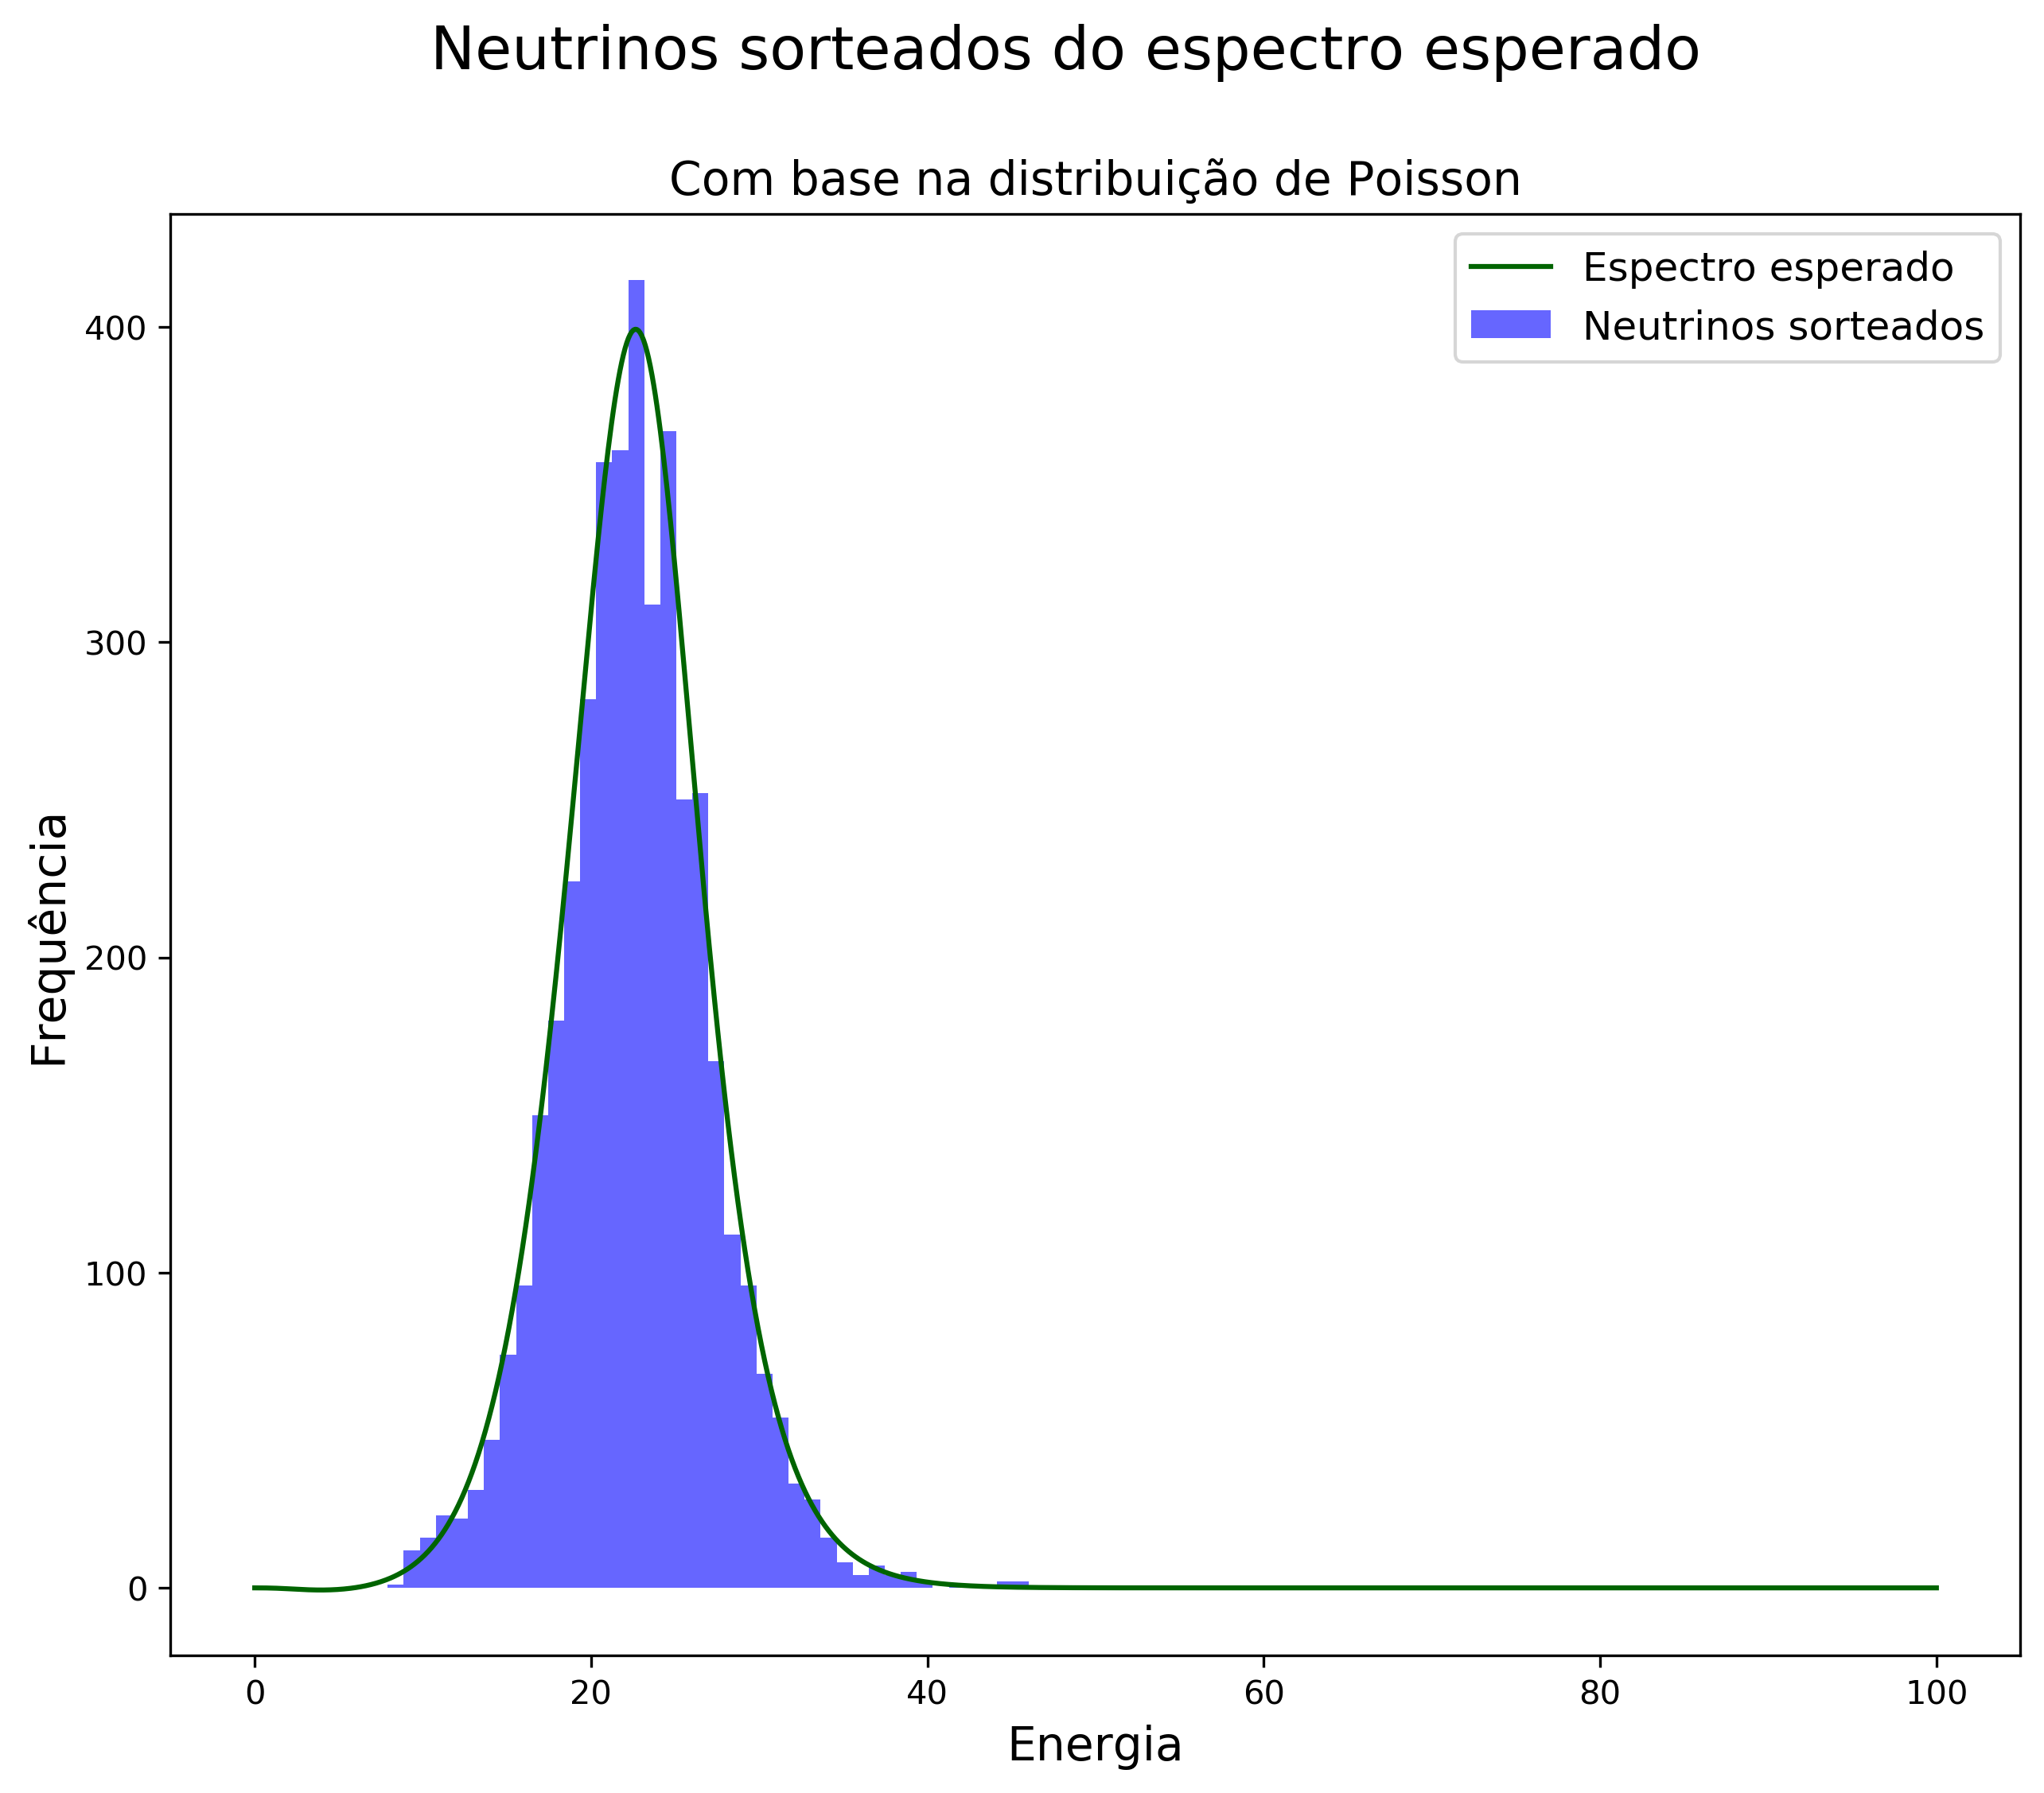

In [397]:
ref_samples = []
population = E
weights = detec(E, 20, 12)
ref_samples = choices(population, weights, k = ref)

plt.figure(figsize=(10,8), dpi = 300)
plt.hist(ref_samples, bins = 40, color = 'blue', alpha = 0.6, label = 'Neutrinos sorteados')
plt.plot(E, detec(E, 20, 12), color = 'darkgreen', label = 'Espectro esperado')
plt.xlabel(r'Energia', fontsize = 14)
plt.ylabel(r'Frequência', fontsize = 14)
plt.suptitle('Neutrinos sorteados do espectro esperado', fontsize = 18)
plt.title('Com base na distribuição de Poisson', fontsize = 14)
plt.legend(fontsize=12)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/DetecFluctuation1.pdf')

In [358]:
new_sample = []
for i in range(len(ref_samples)):
    value = np.random.normal(ref_samples[i],scale=0.05*np.asarray(ref_samples[i]))
    new_sample.append(value)

In [359]:
len(new_sample)

4082

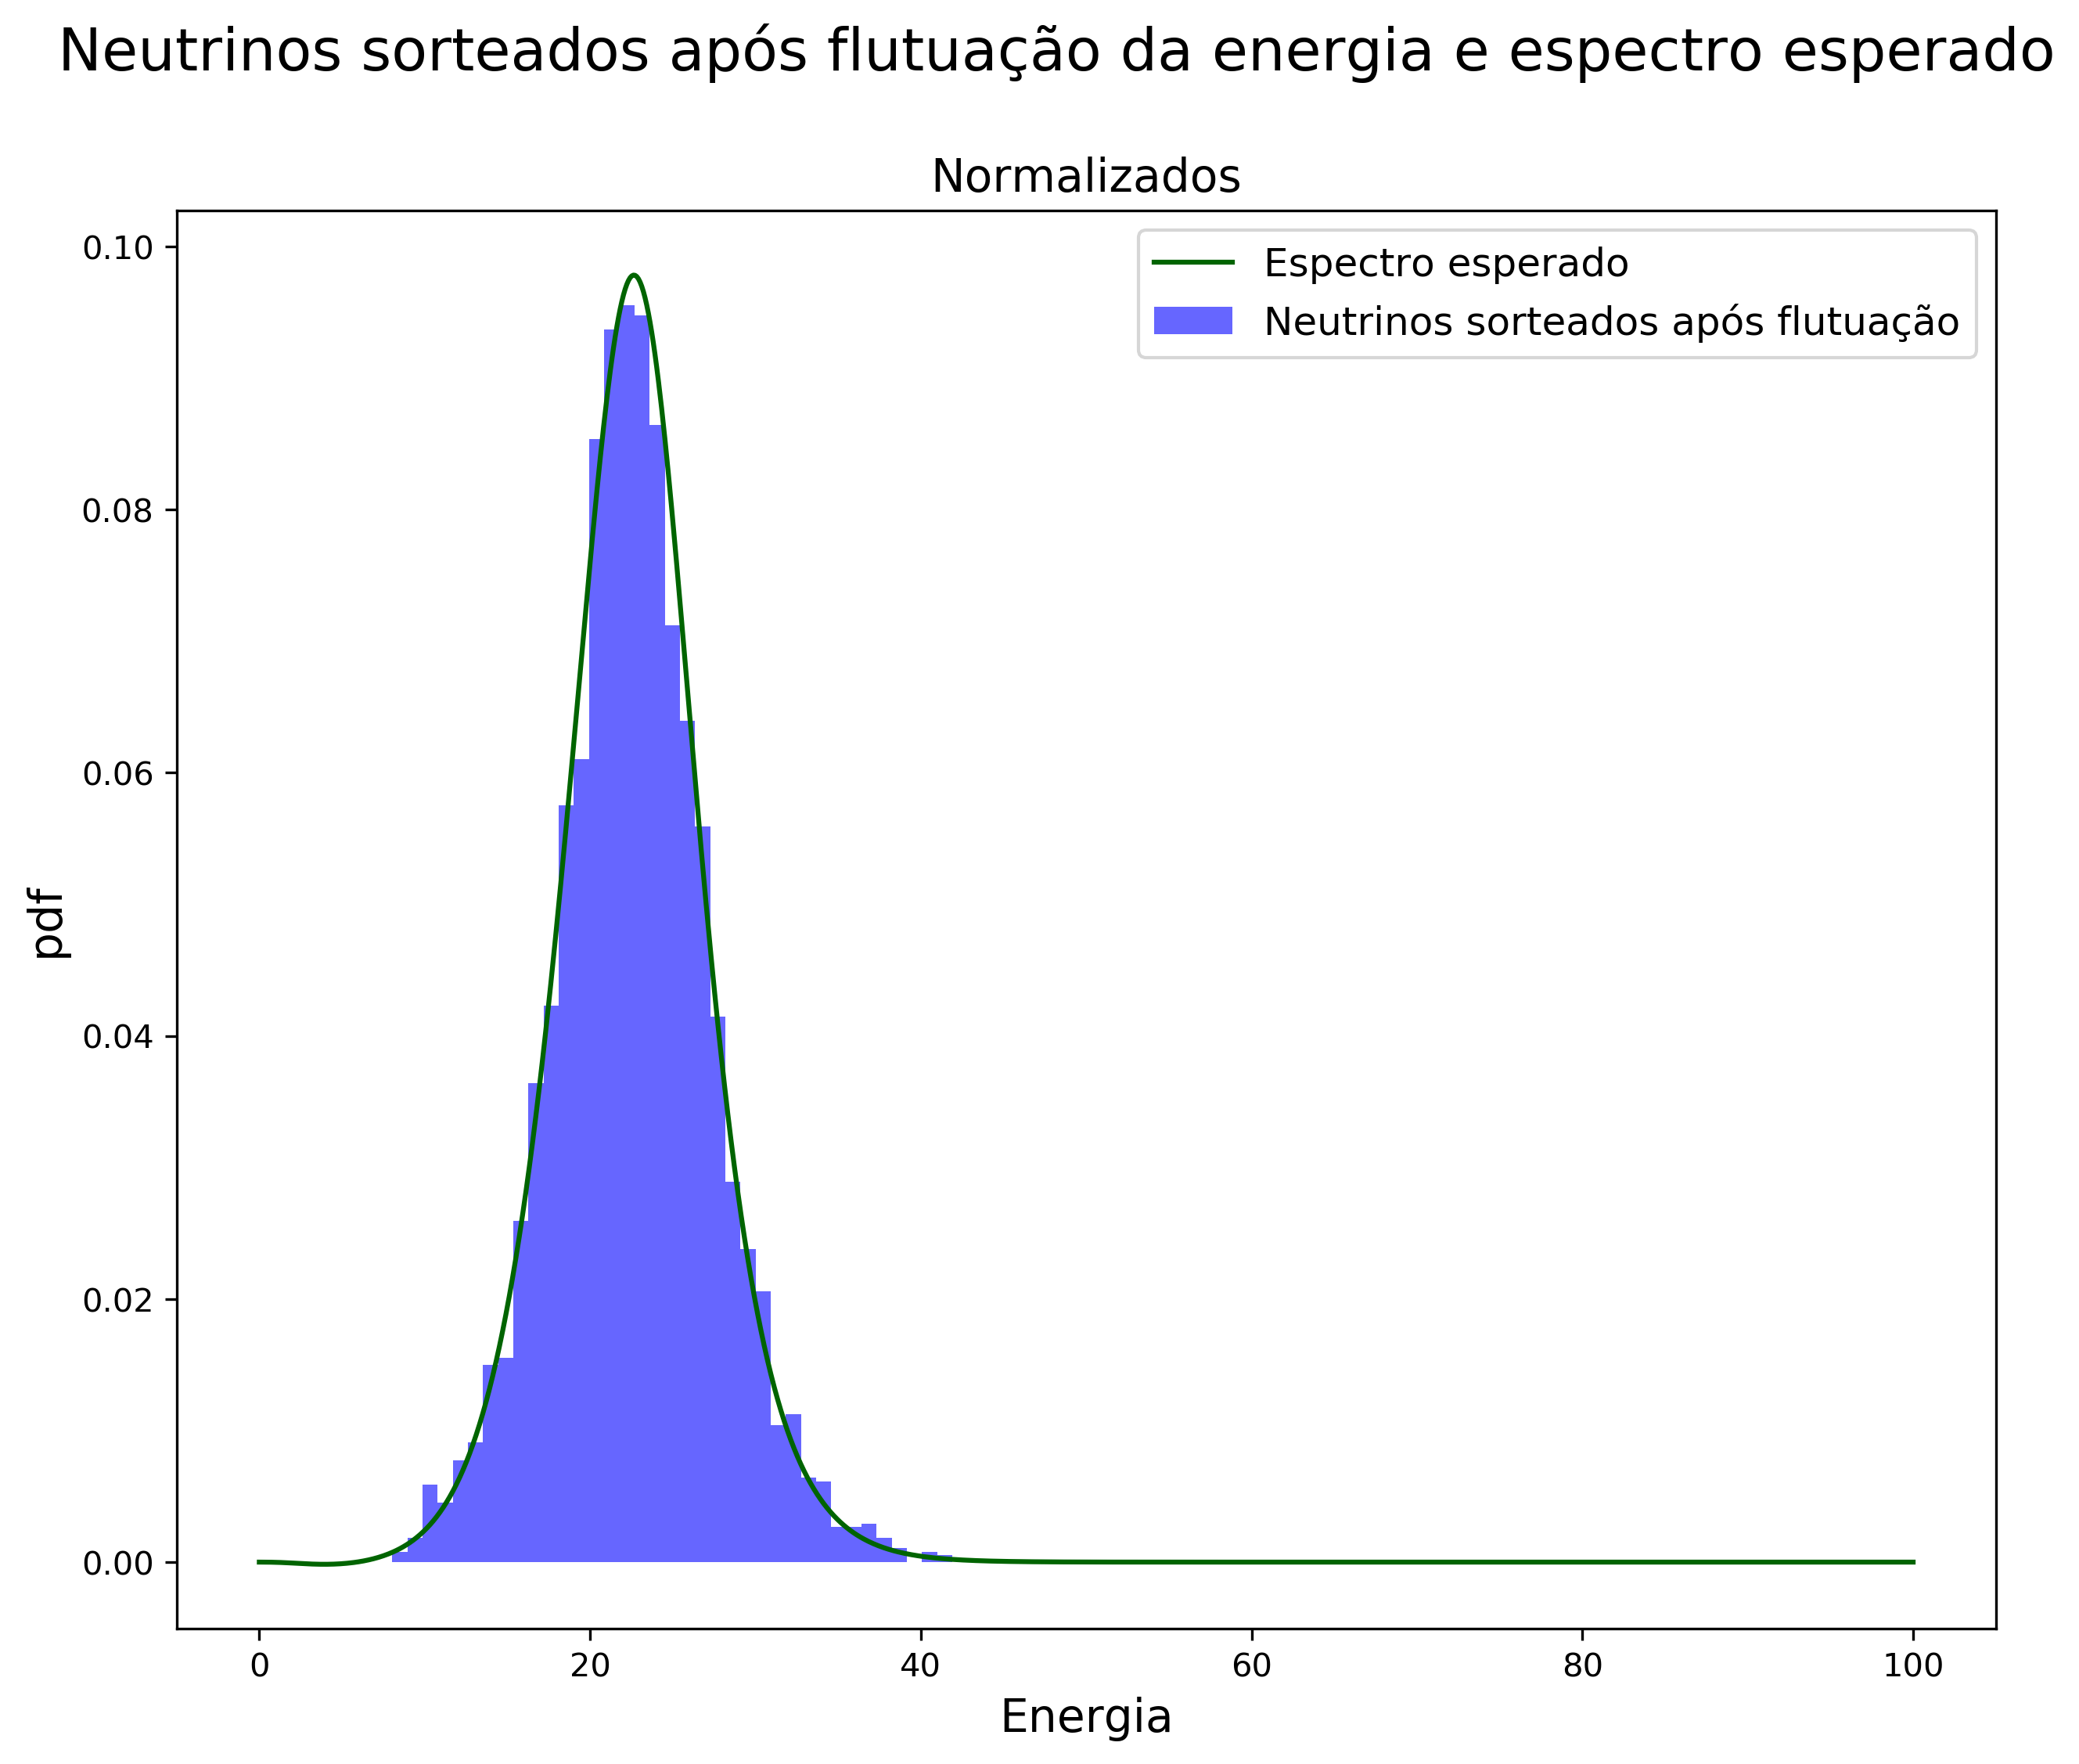

In [398]:
plt.figure(figsize = (10,8), dpi = 300)
plt.hist(new_sample, bins = 40, density = True, color = 'blue', alpha = 0.6, label = 'Neutrinos sorteados após flutuação')
plt.plot(E, detec(E, 20, 12)/ref, color = 'darkgreen', label = 'Espectro esperado')
plt.xlabel(r'Energia', fontsize = 14)
plt.ylabel(r'pdf', fontsize = 14)
plt.suptitle(r'Neutrinos sorteados após flutuação da energia e espectro esperado', fontsize = 18)
plt.title(r'Normalizados', fontsize = 14)
plt.legend(fontsize = 12)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/DetecFluctuation2.pdf')

In [513]:
prior_params = np.array([[0,40],[0,20]], dtype=np.float64)
Dados, E2 = np.histogram(new_sample, bins = 40, density = True)
E2 = (E2[:-1]+E2[1:])/2

In [514]:
def rejABC(prior_params, eps, n_sample):
    # prior_params: list of ranges for uniform priors;
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(prior_params) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
        
            p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
        
        d = np.sqrt(np.sum((Dados-detec(E2, *p[:-1])/ref)**2))/len(E2)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
    
    return post[1:]

In [540]:
post = rejABC(prior_params, 0.01, 1000000)

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [541]:
def sort(n, hist, bins): 
    # n: how many numbers to sort;
    # hist: l-sized array with height of columns of normalized histogram;
    # bins: (l+1)-sized array with values of bins divisions
    
    d = bins[1] - bins[0] # Bin size
    
    dat = [] # List of sorted random numbers
    
    for i in range(n):
        
        x = np.random.uniform(0., 1.)
        
        # Conversion of 0-1 random number to number sorted according to the given histogram
        for j in range(len(hist)):
            
            if (x < np.sum(hist[:j+1])*d):
                
                dat.append(np.random.uniform(bins[j], bins[j+1]))
                break
    
    return np.array(dat) # Converts list of sorted random numbers to numpy array

In [542]:
def smcABC(model, hist, bins, n_bins, p_std, eps, n_sample, n_max):
    # model: function to be fit; 
    # hist+bins: past posterior for new prior
    # n_bins: number of bins to be used to make new prior from last posterior
    # p_std: standard deviations of last posterior, to add noise to new posterior
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(hist) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
        
            # p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
            p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j]/n_bins)
        
        d = np.sqrt(np.sum((Dados-detec(E2, *p[:-1])/ref)**2))/len(E2)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
            
        if (len(post) > n_max):
            break
            
    return post[1:]

In [543]:
n_bins = 40

repeat = 5

for l in range(1, repeat):
    p = post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]][:-1]
    p_std = np.std(post[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    
    hist = np.zeros((len(p), n_bins))
    bins = np.zeros((len(p), n_bins+1))
    
    # Define new priors
    for k in range(len(hist)):
        hist[k], bins[k] = np.histogram(post[:, k], n_bins, density=True)
    eps = (np.max(post[:,-1]) + np.min(post[:,-1]))/2
    post = smcABC(detec(E2, *p), hist, bins, n_bins, p_std, eps, 1000000, 100000)

/home/pedroc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [544]:
eps

0.0009849600382137527

In [560]:
p = post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]][:-1]
p_std = np.std(post[:,:-1], axis=0)

T = post[:,0]
eta = post[:,1]

print('Valor para T: %3.2f' % p[0], '95% CDI:', np.percentile(T, 2.5), '-', np.percentile(T, 97.5))
print('Valor para eta: %3.2f' % p[1], '95% CDI:', np.percentile(eta, 2.5), '-', np.percentile(eta, 97.5))

Valor para T: 20.02 95% CDI: 19.24642517505293 - 21.126379892724085
Valor para eta: 11.95 95% CDI: 11.524427764662715 - 12.273987939222316


In [546]:
post[np.where(post[:,-1] == np.min(post[:,-1]))[0][0]]

array([2.00243650e+01, 1.19535897e+01, 3.81239884e-04])

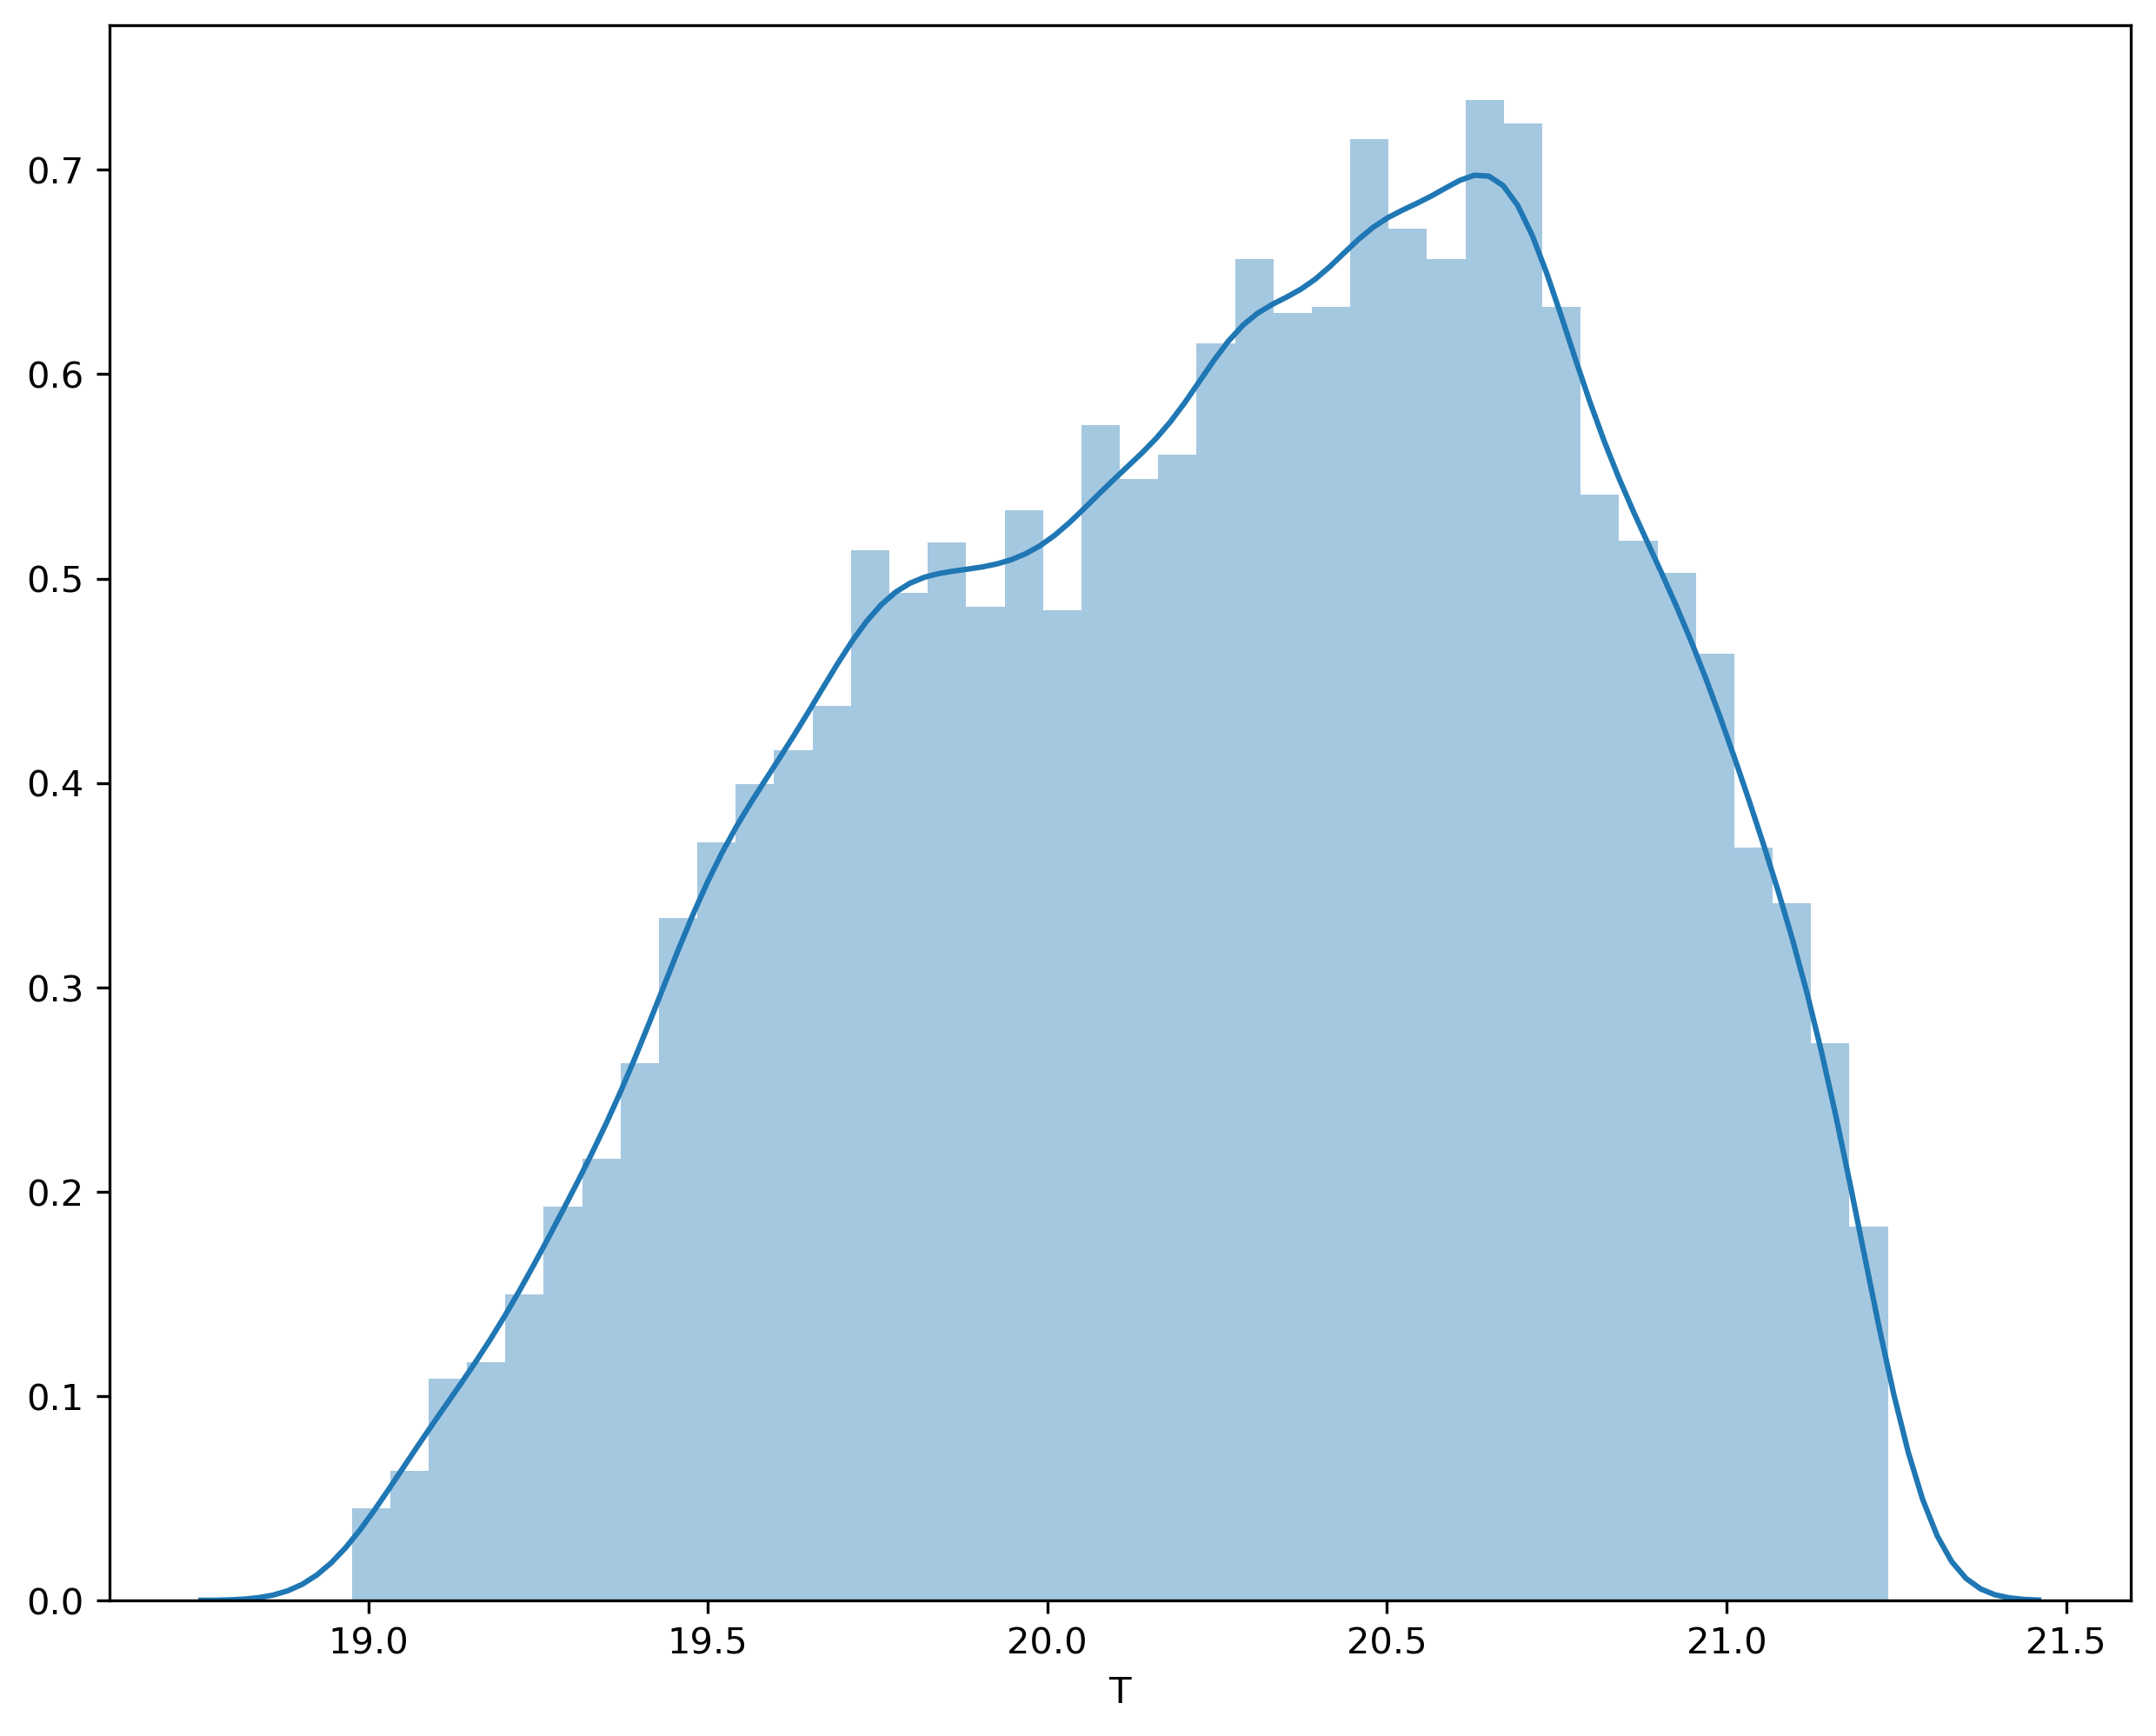

In [553]:
plt.figure(figsize=(10,8), dpi = 300)
sns.distplot(post[:,0], axlabel= 'T')
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/Tdistribution.pdf')

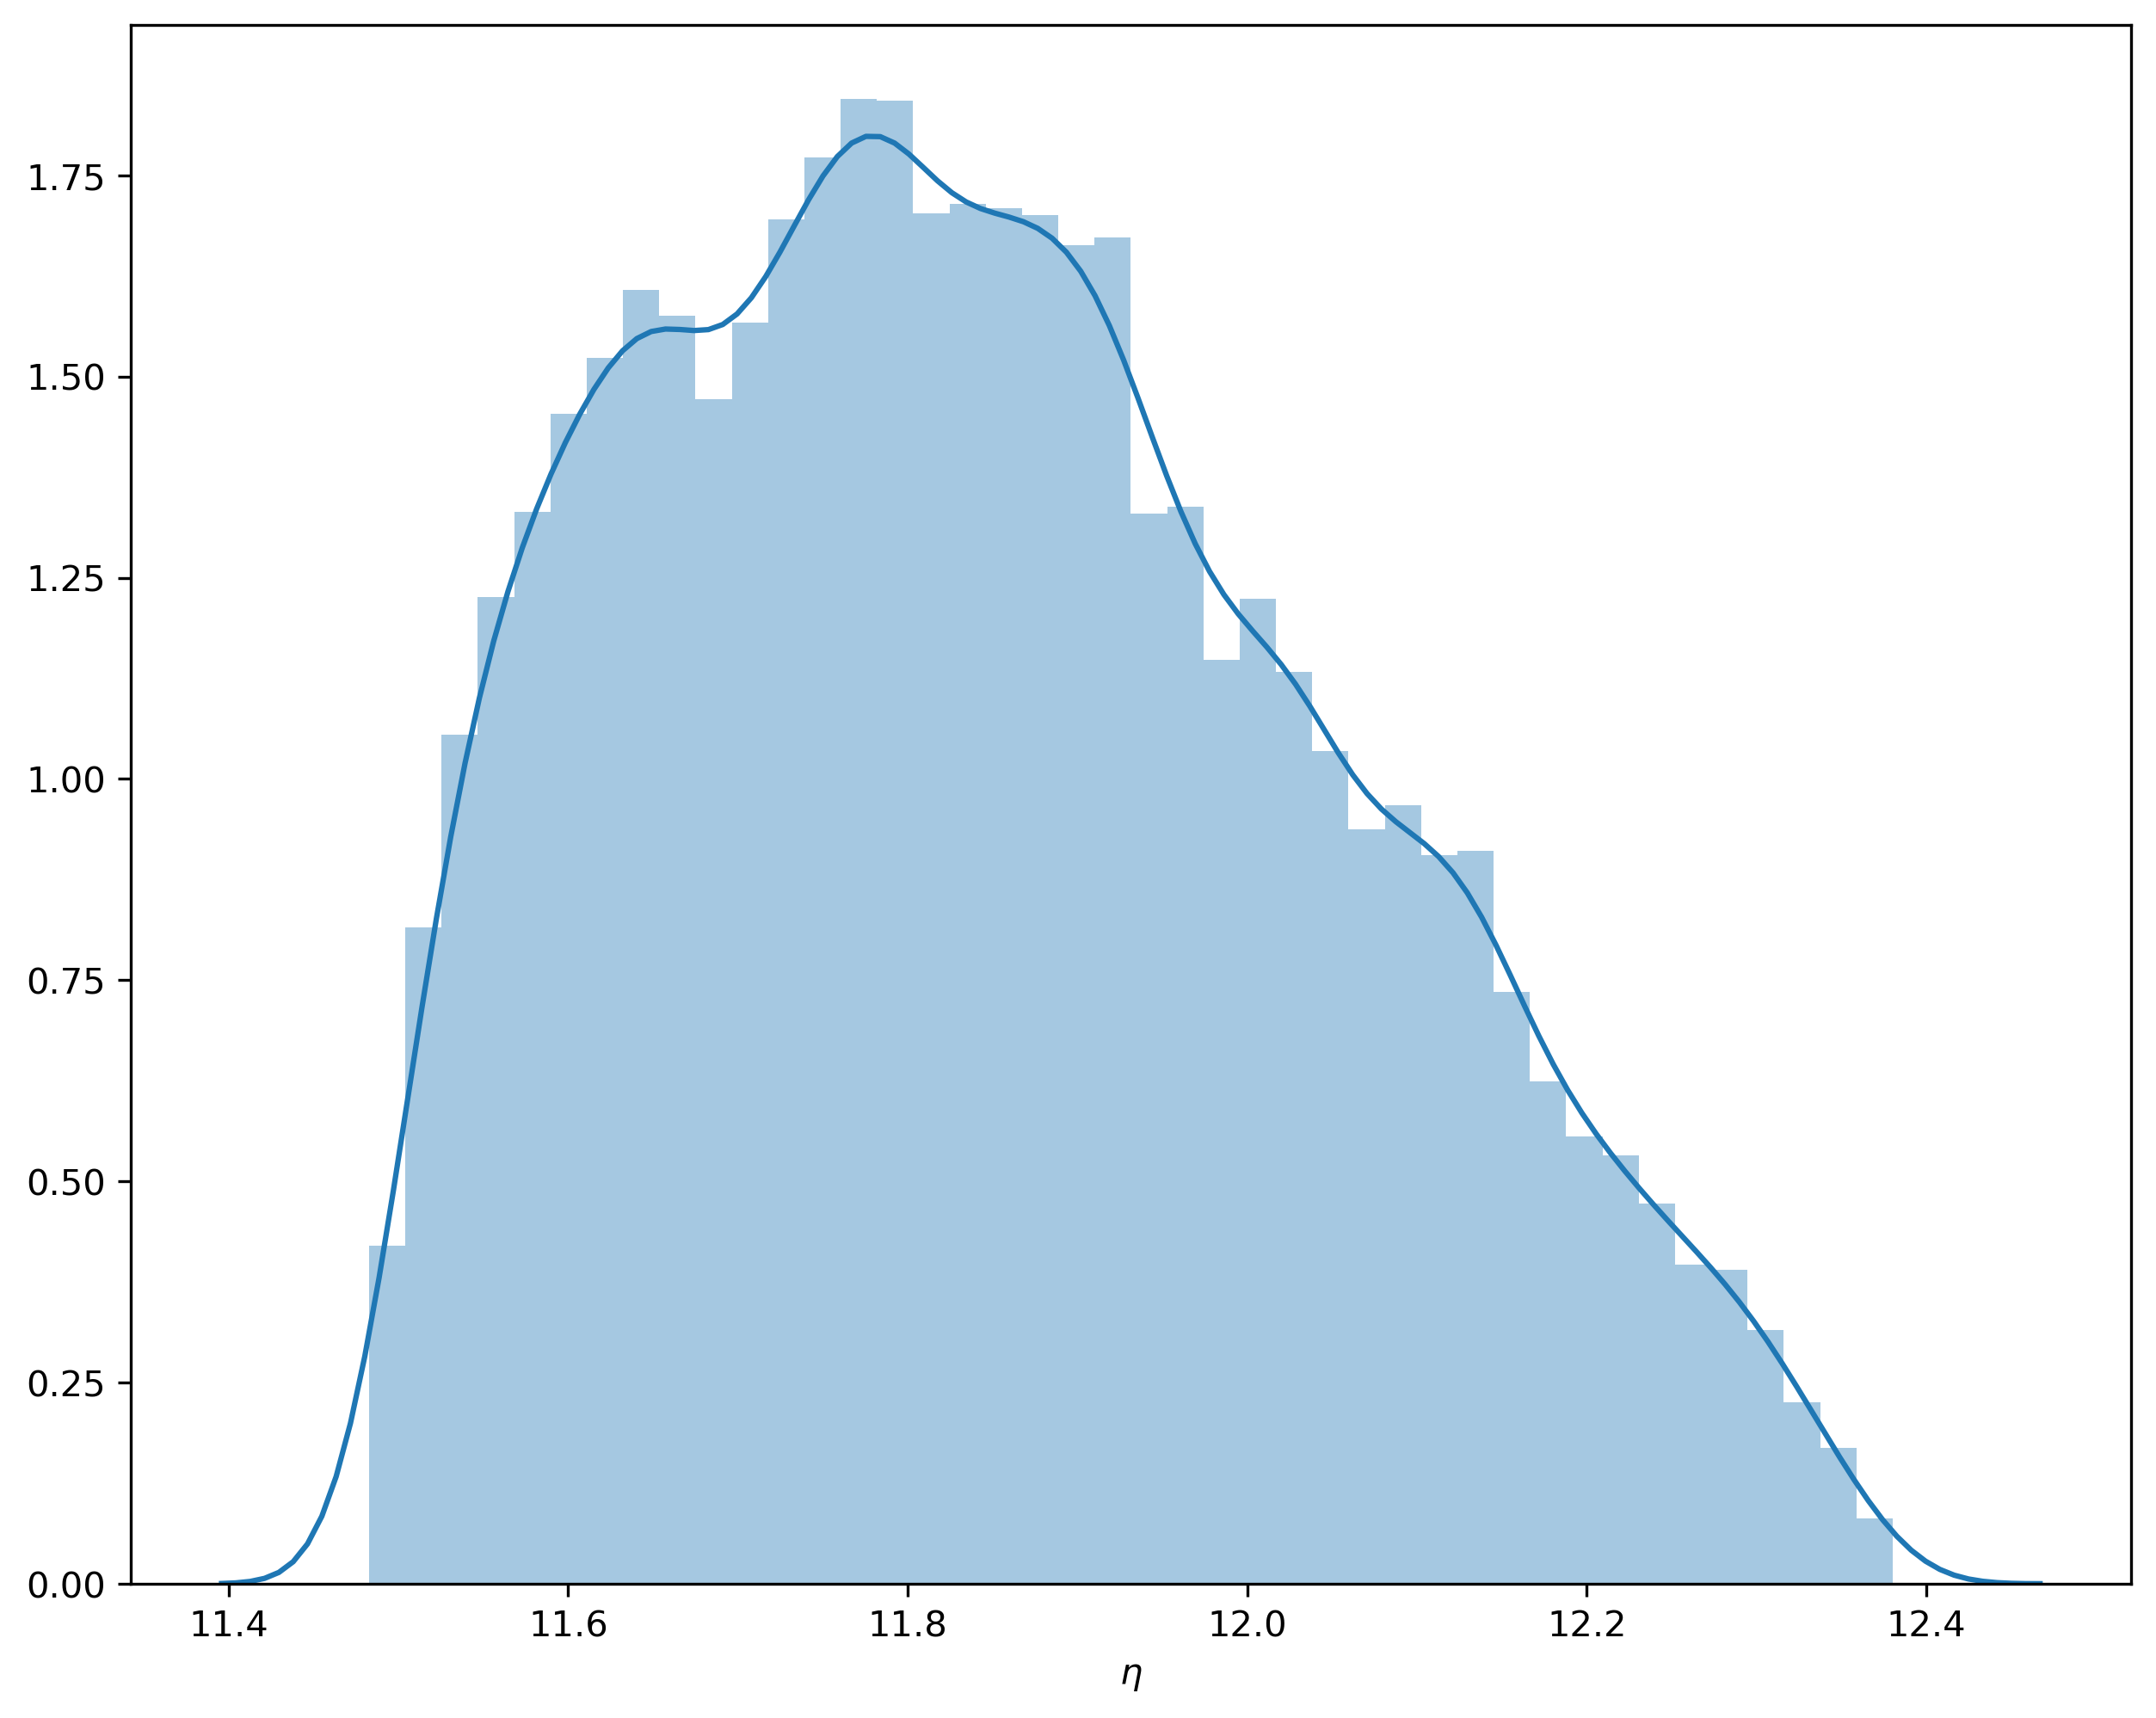

In [554]:
plt.figure(figsize=(10,8), dpi = 300)
sns.distplot(post[:,1], axlabel = r'$\eta$')
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/Etadistribution.pdf')

<Figure size 3000x2400 with 0 Axes>

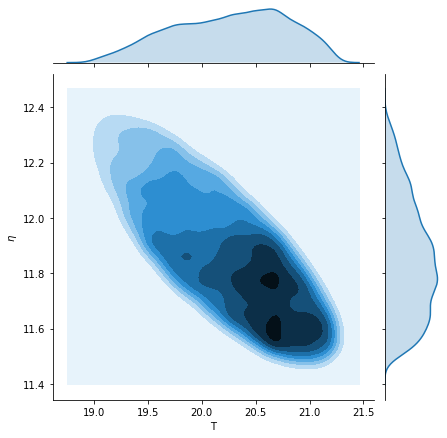

In [555]:
plt.figure(figsize = (10,8), dpi = 300)
ax = sns.jointplot(*post[:,:2].T, kind = 'kde')
ax.set_axis_labels('T', '$\eta$')
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/Bothdistribution.pdf')

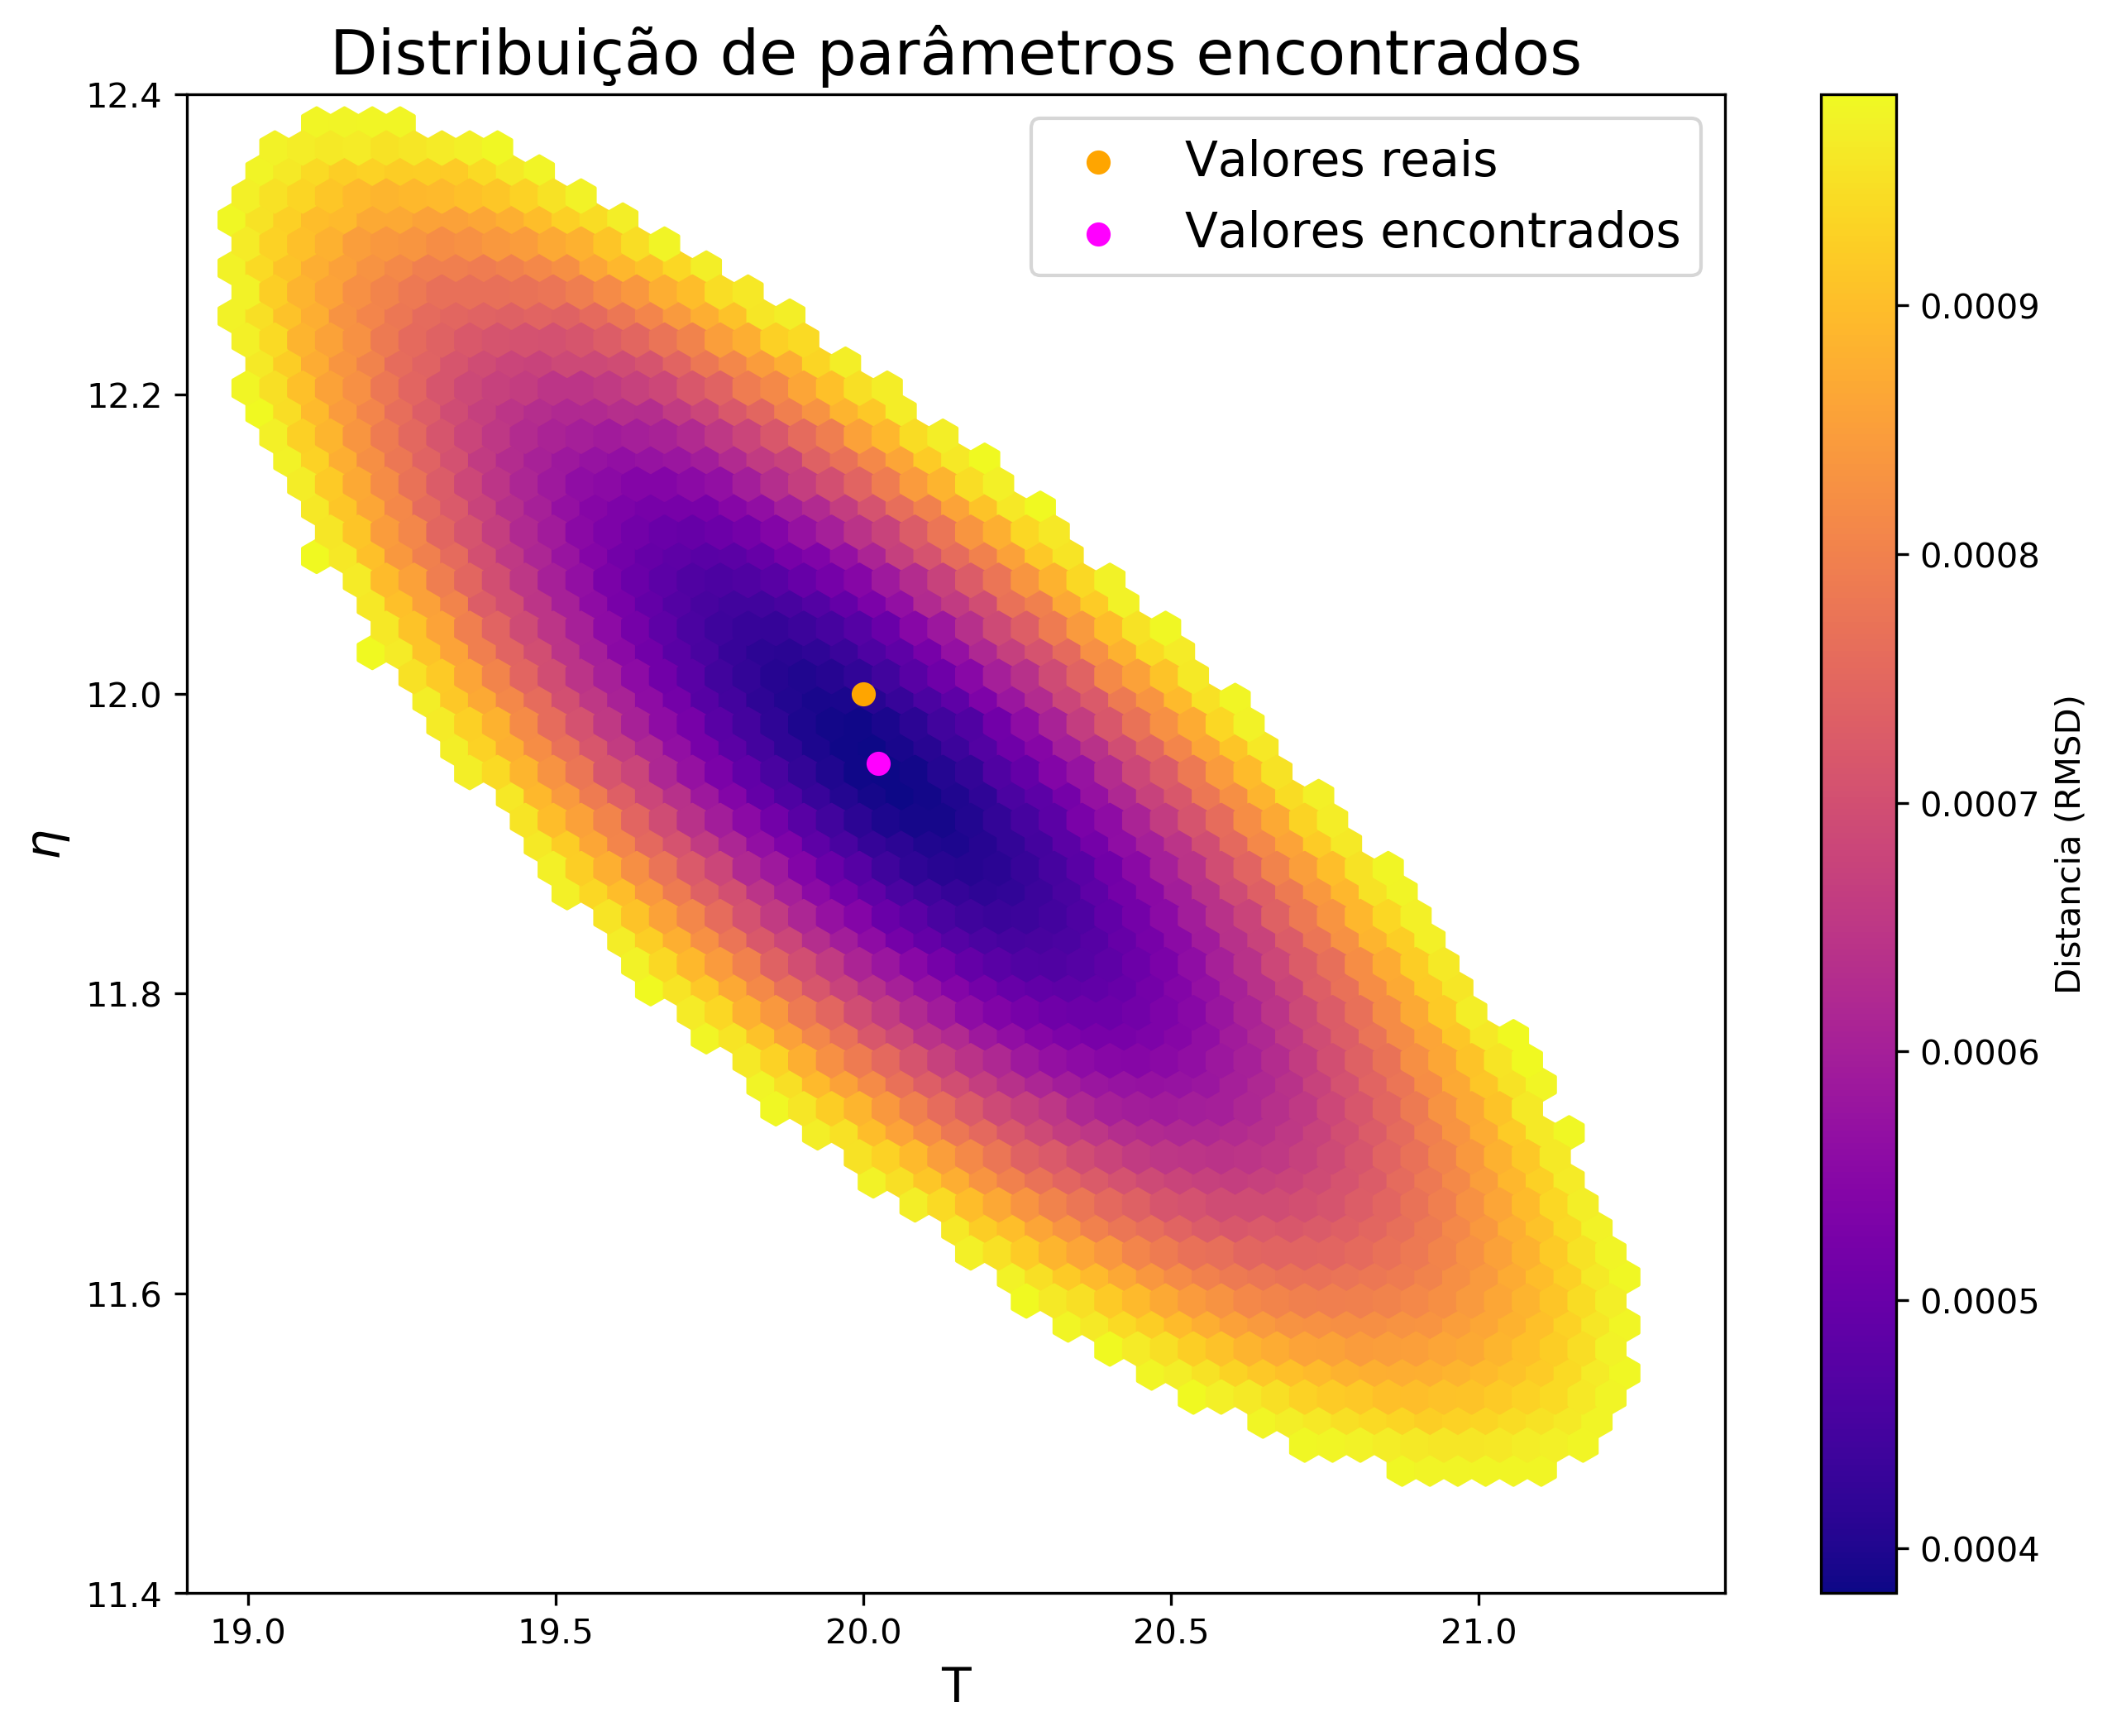

In [559]:
plt.figure(figsize=(10,8), dpi = 300)
cs = plt.hexbin(T, eta, C=post[:,2], gridsize=50, cmap="plasma", bins=None)
plt.colorbar(cs, label = 'Distancia (RMSD)')
plt.scatter(20, 12, color = 'orange', label = 'Valores reais')
plt.scatter(p[0], p[1], color = 'magenta', label = 'Valores encontrados')
plt.xlabel('T', fontsize = 14)
plt.ylabel('$\eta$', fontsize = 14)
plt.xlim(18.9, 21.4)
plt.ylim(11.4, 12.4)
plt.title('Distribuição de parâmetros encontrados', fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 14)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/Distancedistribution.pdf')

In [567]:
KS = []
pvalue = []

for i in range(len(post)):
    T0 = post[i,0]
    eta0 = post[i,1]
    K = stats.ks_2samp(detec(E2, T0, eta0)/ref, Dados)
    KS.append(K[0])
    pvalue.append(K[1])

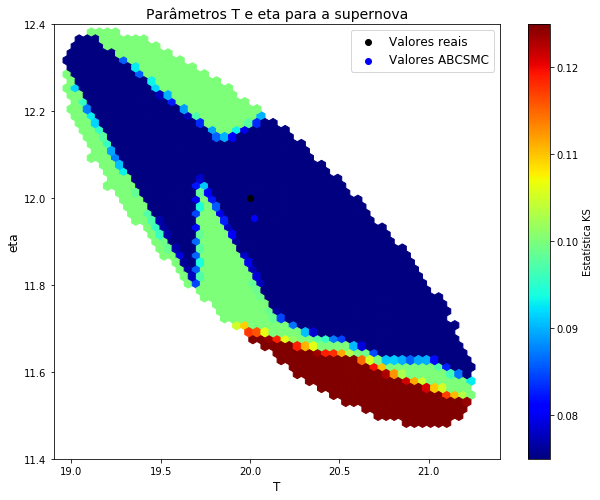

In [570]:
plt.figure(figsize=(10,8))
#plt.rc('text', usetex = True)
#plt.rc('font', family ='serif')
cs = plt.hexbin(T, eta, C=KS, gridsize=50, cmap=plt.cm.jet, bins=None)
plt.colorbar(cs, label = 'Estatística KS')
plt.scatter(20, 12, color = 'black', label = 'Valores reais')
plt.scatter(p[0], p[1], color = 'blue', label = 'Valores ABCSMC')
plt.xlabel('T', fontsize = 12)
plt.ylabel('eta', fontsize = 12)
plt.xlim(18.9, 21.4)
plt.ylim(11.4, 12.4)
plt.title('Parâmetros T e eta para a supernova', fontsize = 14)
plt.legend(loc = 'upper right', fontsize = 12)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/KSdistribution.pdf')

In [471]:
T_best = p[0]
eta_best = p[1]

def detec2(E, d):
    Nt = 1e36 #Number of target particles in the detector
    D = Nt/(4*np.pi*(d*(3.09e16))**2)
    return spec(E, T_best, eta_best)*(sigma(E, 0, 1/2, 1/2)+sigmaCCAr(E))*efficiency(E, 0.976, 1.265)*D

In [472]:
eta_best

11.95134110564169

In [473]:
prior = np.array([[40000,60000]], dtype=np.float64)

In [474]:
def rejABC2(prior_params, eps, n_sample):
    # prior_params: list of ranges for uniform priors;
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(prior_params) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
        
            p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
        
        d = np.abs(ref - simps(detec2(E, *p[:-1]), E))
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
    
    return post[1:]

In [475]:
np.abs(simps(detec2(E, 50000), E)-ref)

60.17061700216027

In [476]:
simps(detec(E, 20, 12), E)

4098.479489624855

In [477]:
simps(detec2(E, 50000), E)

4021.8293829978397

In [478]:
ref

4082

In [479]:
D = rejABC2(prior, 500, 1000000)

In [480]:
len(D)

306353

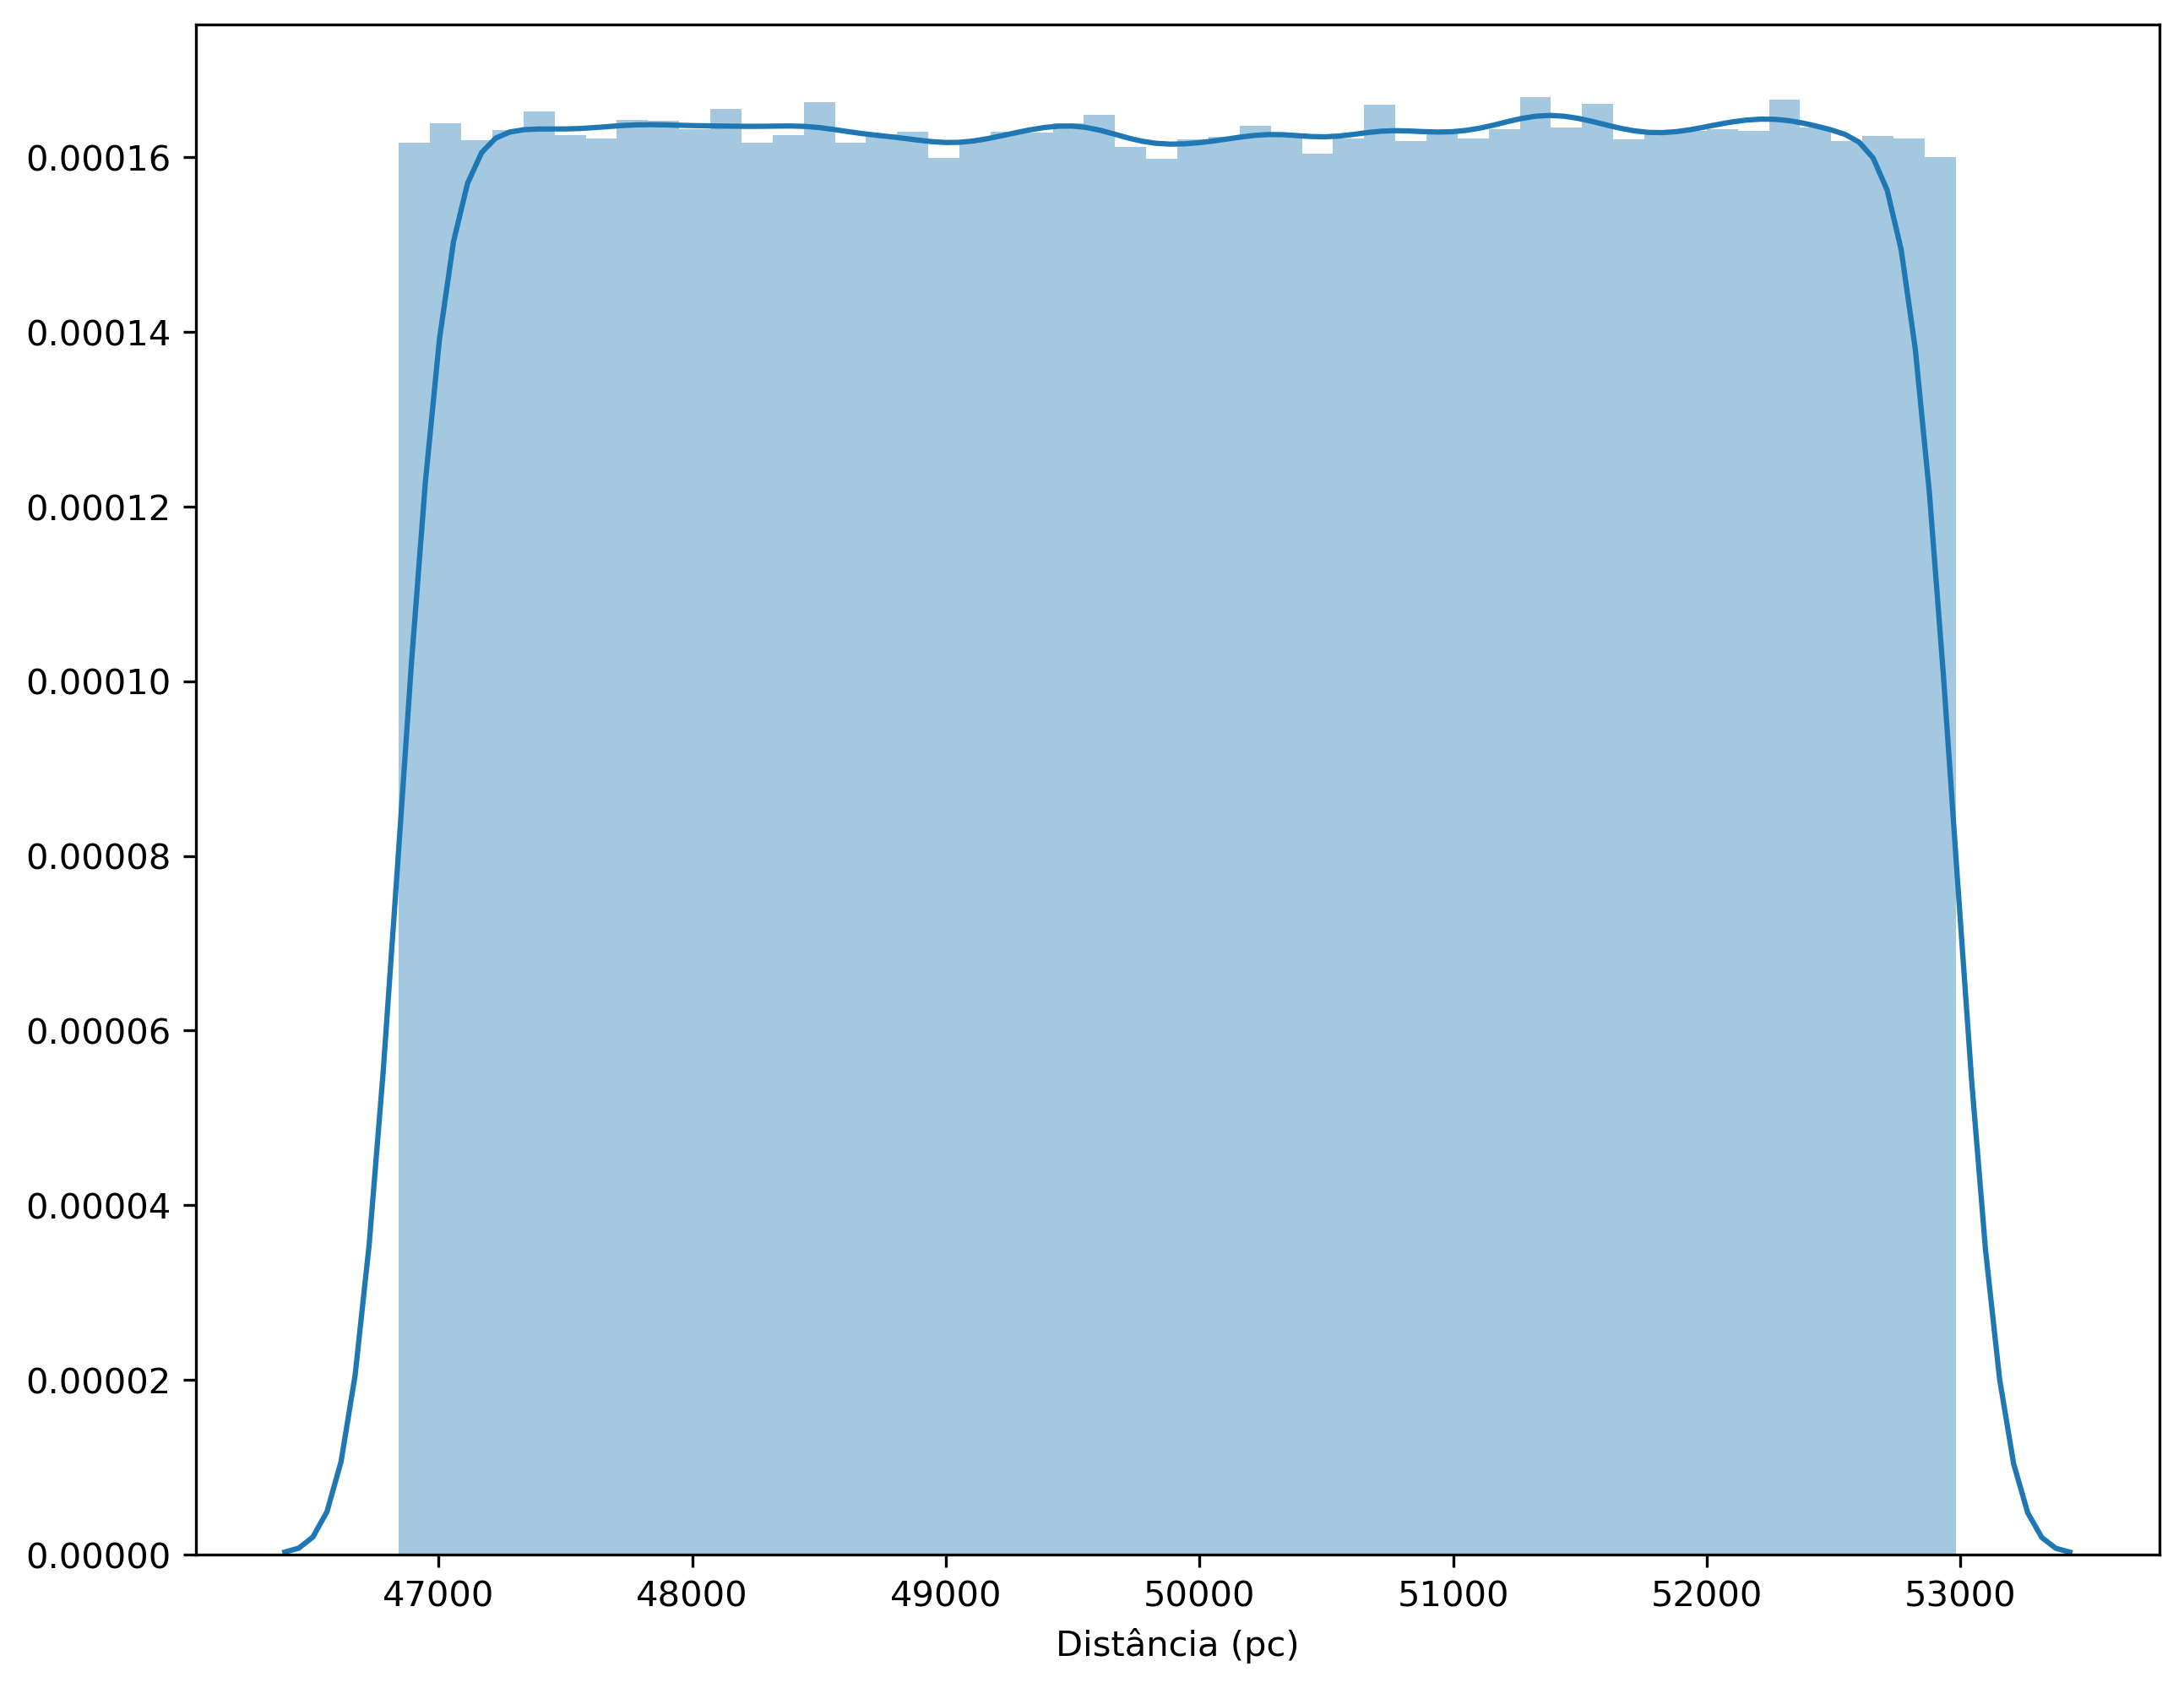

In [481]:
plt.figure(figsize=(10,8), dpi = 300)
sns.distplot(D[:,0], axlabel = 'Distância (pc)')

In [482]:
def sort(n, hist, bins): 
    # n: how many numbers to sort;
    # hist: l-sized array with height of columns of normalized histogram;
    # bins: (l+1)-sized array with values of bins divisions
    
    d = bins[1] - bins[0] # Bin size
    
    dat = [] # List of sorted random numbers
    
    for i in range(n):
        
        x = np.random.uniform(0., 1.)
        
        # Conversion of 0-1 random number to number sorted according to the given histogram
        for j in range(len(hist)):
            
            if (x < np.sum(hist[:j+1])*d):
                
                dat.append(np.random.uniform(bins[j], bins[j+1]))
                break
    
    return np.array(dat) # Converts list of sorted random numbers to numpy array

In [483]:
def smcABC(model, hist, bins, n_bins, p_std, eps, n_sample, n_max):
    # model: function to be fit; 
    # hist+bins: past posterior for new prior
    # n_bins: number of bins to be used to make new prior from last posterior
    # p_std: standard deviations of last posterior, to add noise to new posterior
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(hist) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
        
            # p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
            p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j]/n_bins)
        
        d = np.abs(ref - simps(detec2(E, p[:-1]), E))
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
            
        if (len(post) > n_max):
            break
            
    return post[1:]

In [507]:
n_bins = 40

repeat = 5

for l in range(1, repeat):
    p = D[np.where(D[:,-1] == np.min(D[:,-1]))[0][0]][:-1]
    p_std = np.std(D[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    
    hist = np.zeros((len(p), n_bins))
    bins = np.zeros((len(p), n_bins+1))
    
    # Define new priors
    for k in range(len(hist)):
        hist[k], bins[k] = np.histogram(D[:, k], n_bins, density=True)
    eps = (np.max(D[:,-1]) + np.min(D[:,-1]))/2
    D = smcABC(detec2(E, p), hist, bins, n_bins, p_std, eps, 1000000, 100000)

In [508]:
eps

0.9765226465599426

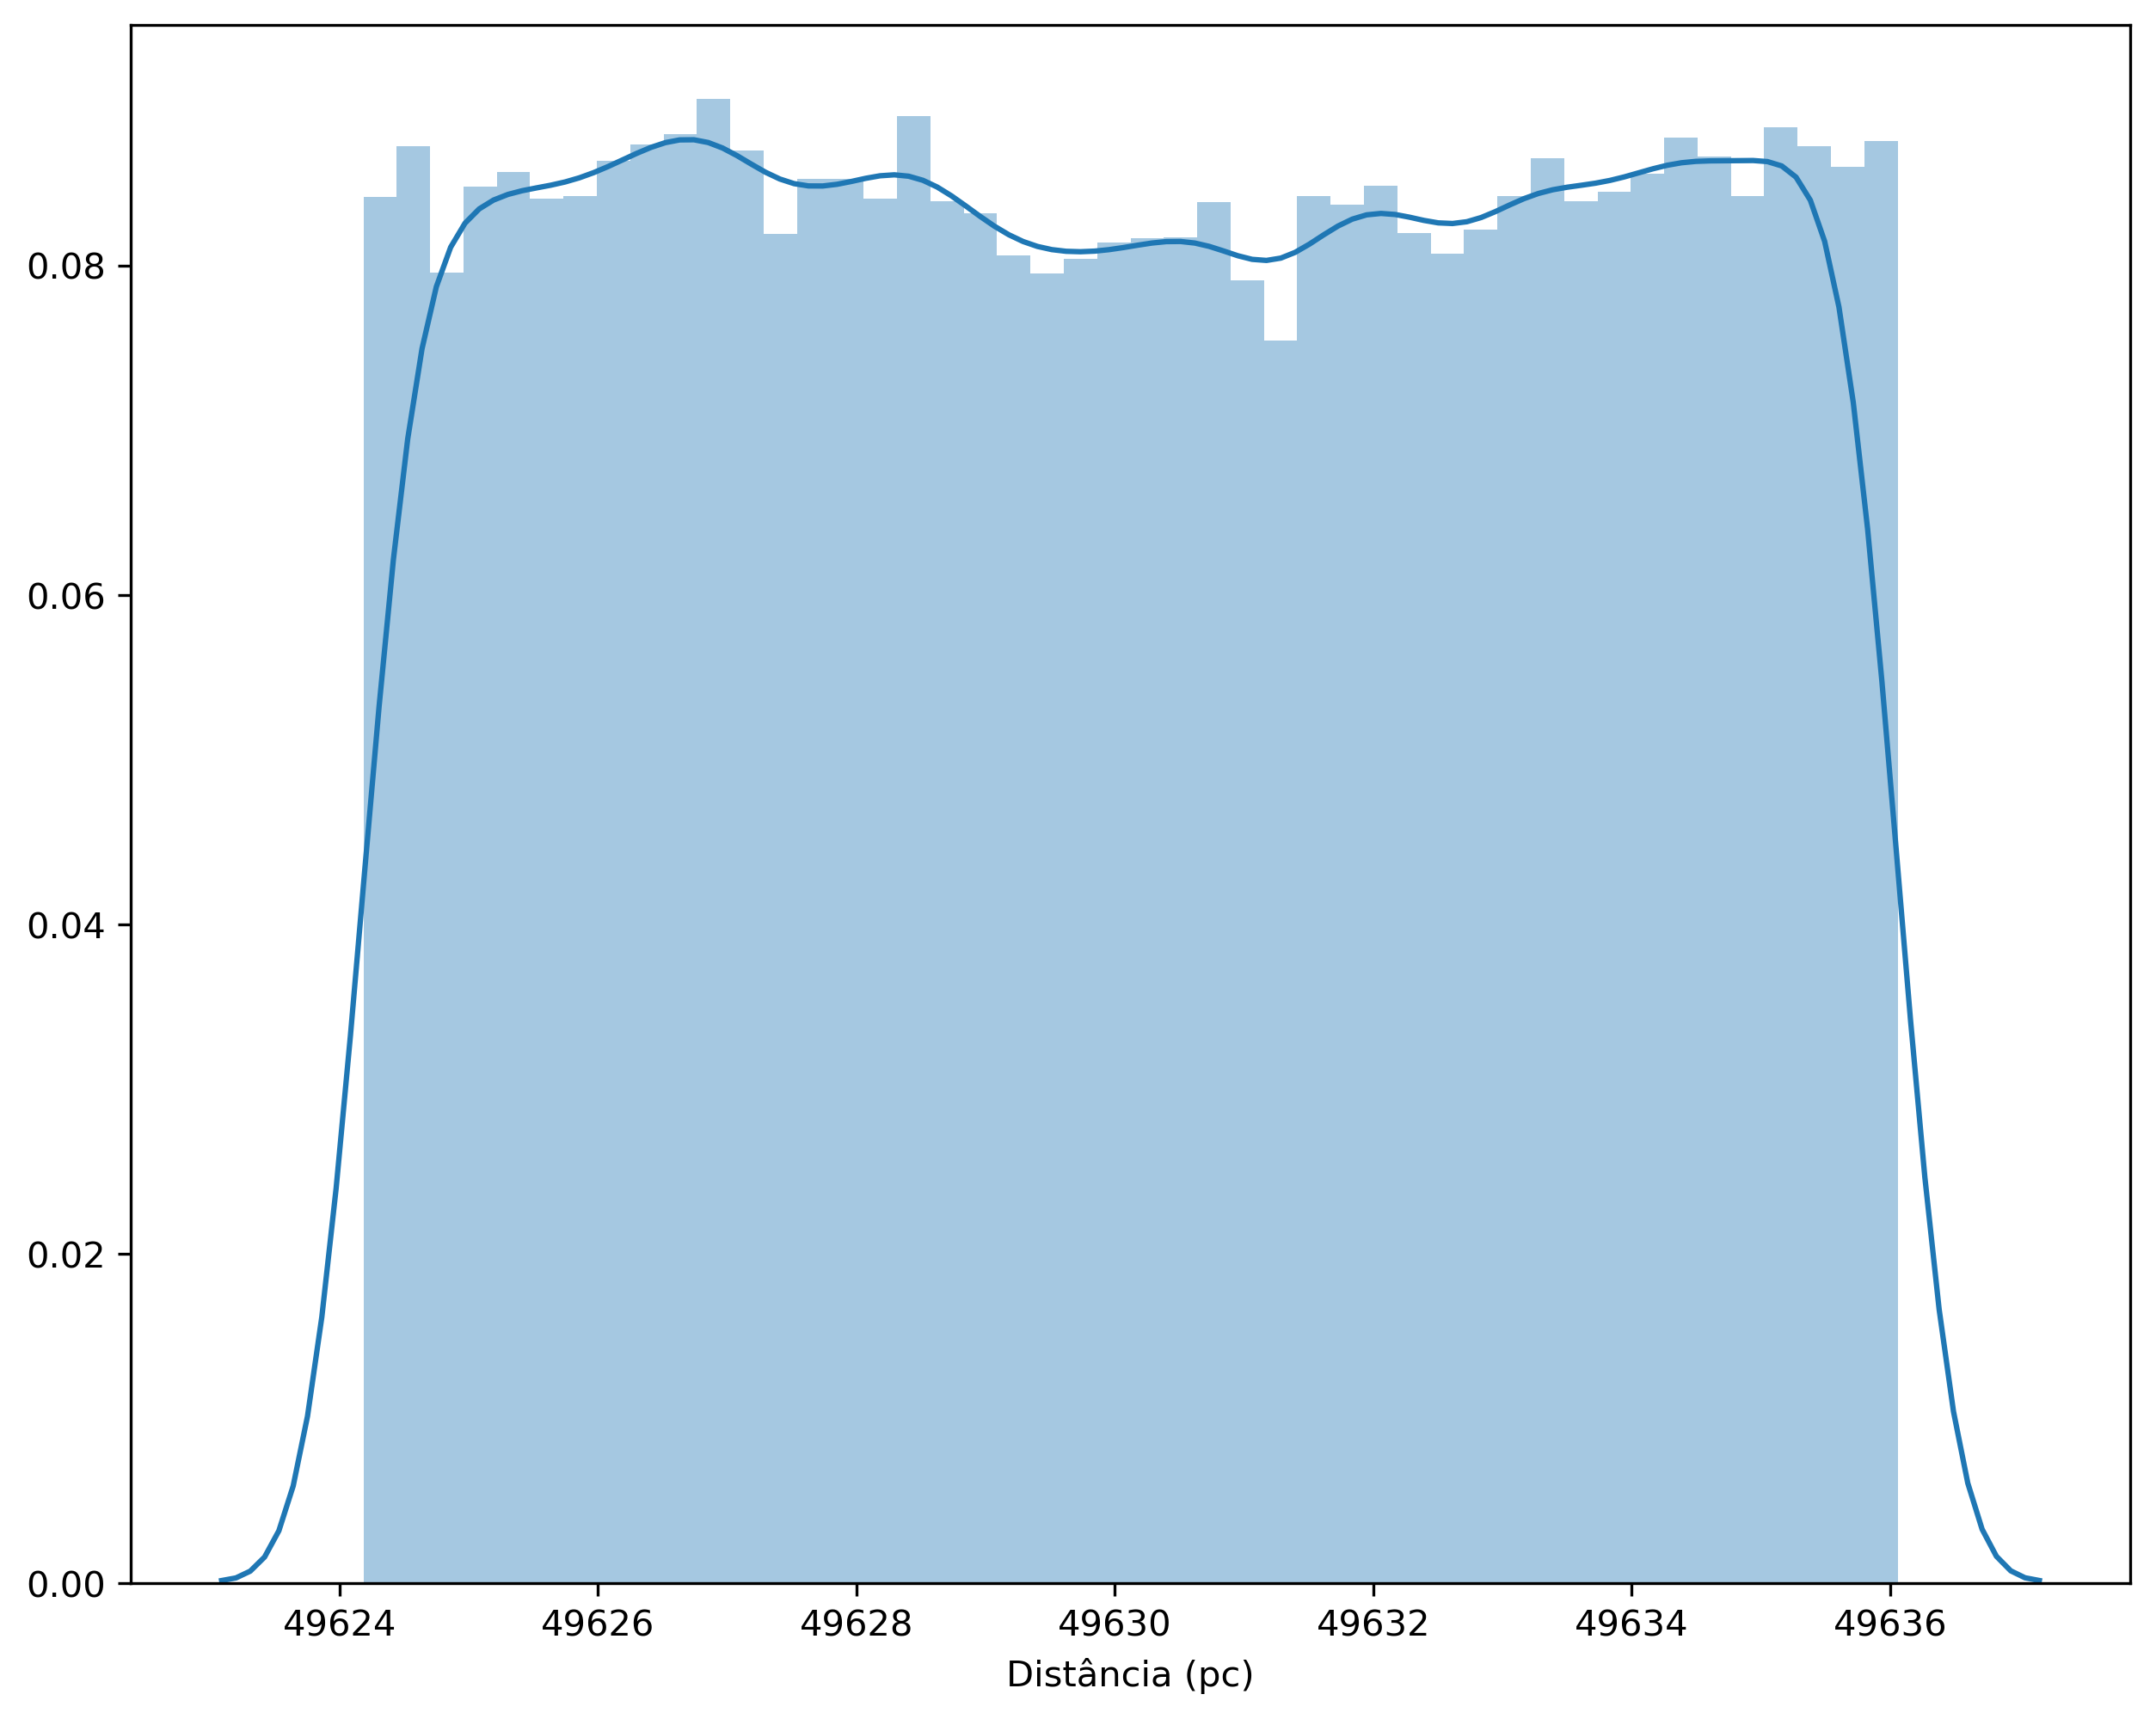

In [509]:
plt.figure(figsize=(10,8), dpi = 300)
sns.distplot(D[:,0], axlabel = 'Distância (pc)')
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/Ddistribution.pdf')

In [487]:
d = post_[np.where(post_[:,-1] == np.min(post_[:,-1]))[0][0]][:-1]

print('Distância até a supernova:', d, '95% CDI:', np.percentile(post_[:,0], 2.5), '-', np.percentile(post_[:,0], 97.5))

Distância até a supernova: [49630.15047833] 95% CDI: 47013.51996896493 - 52809.90340795494


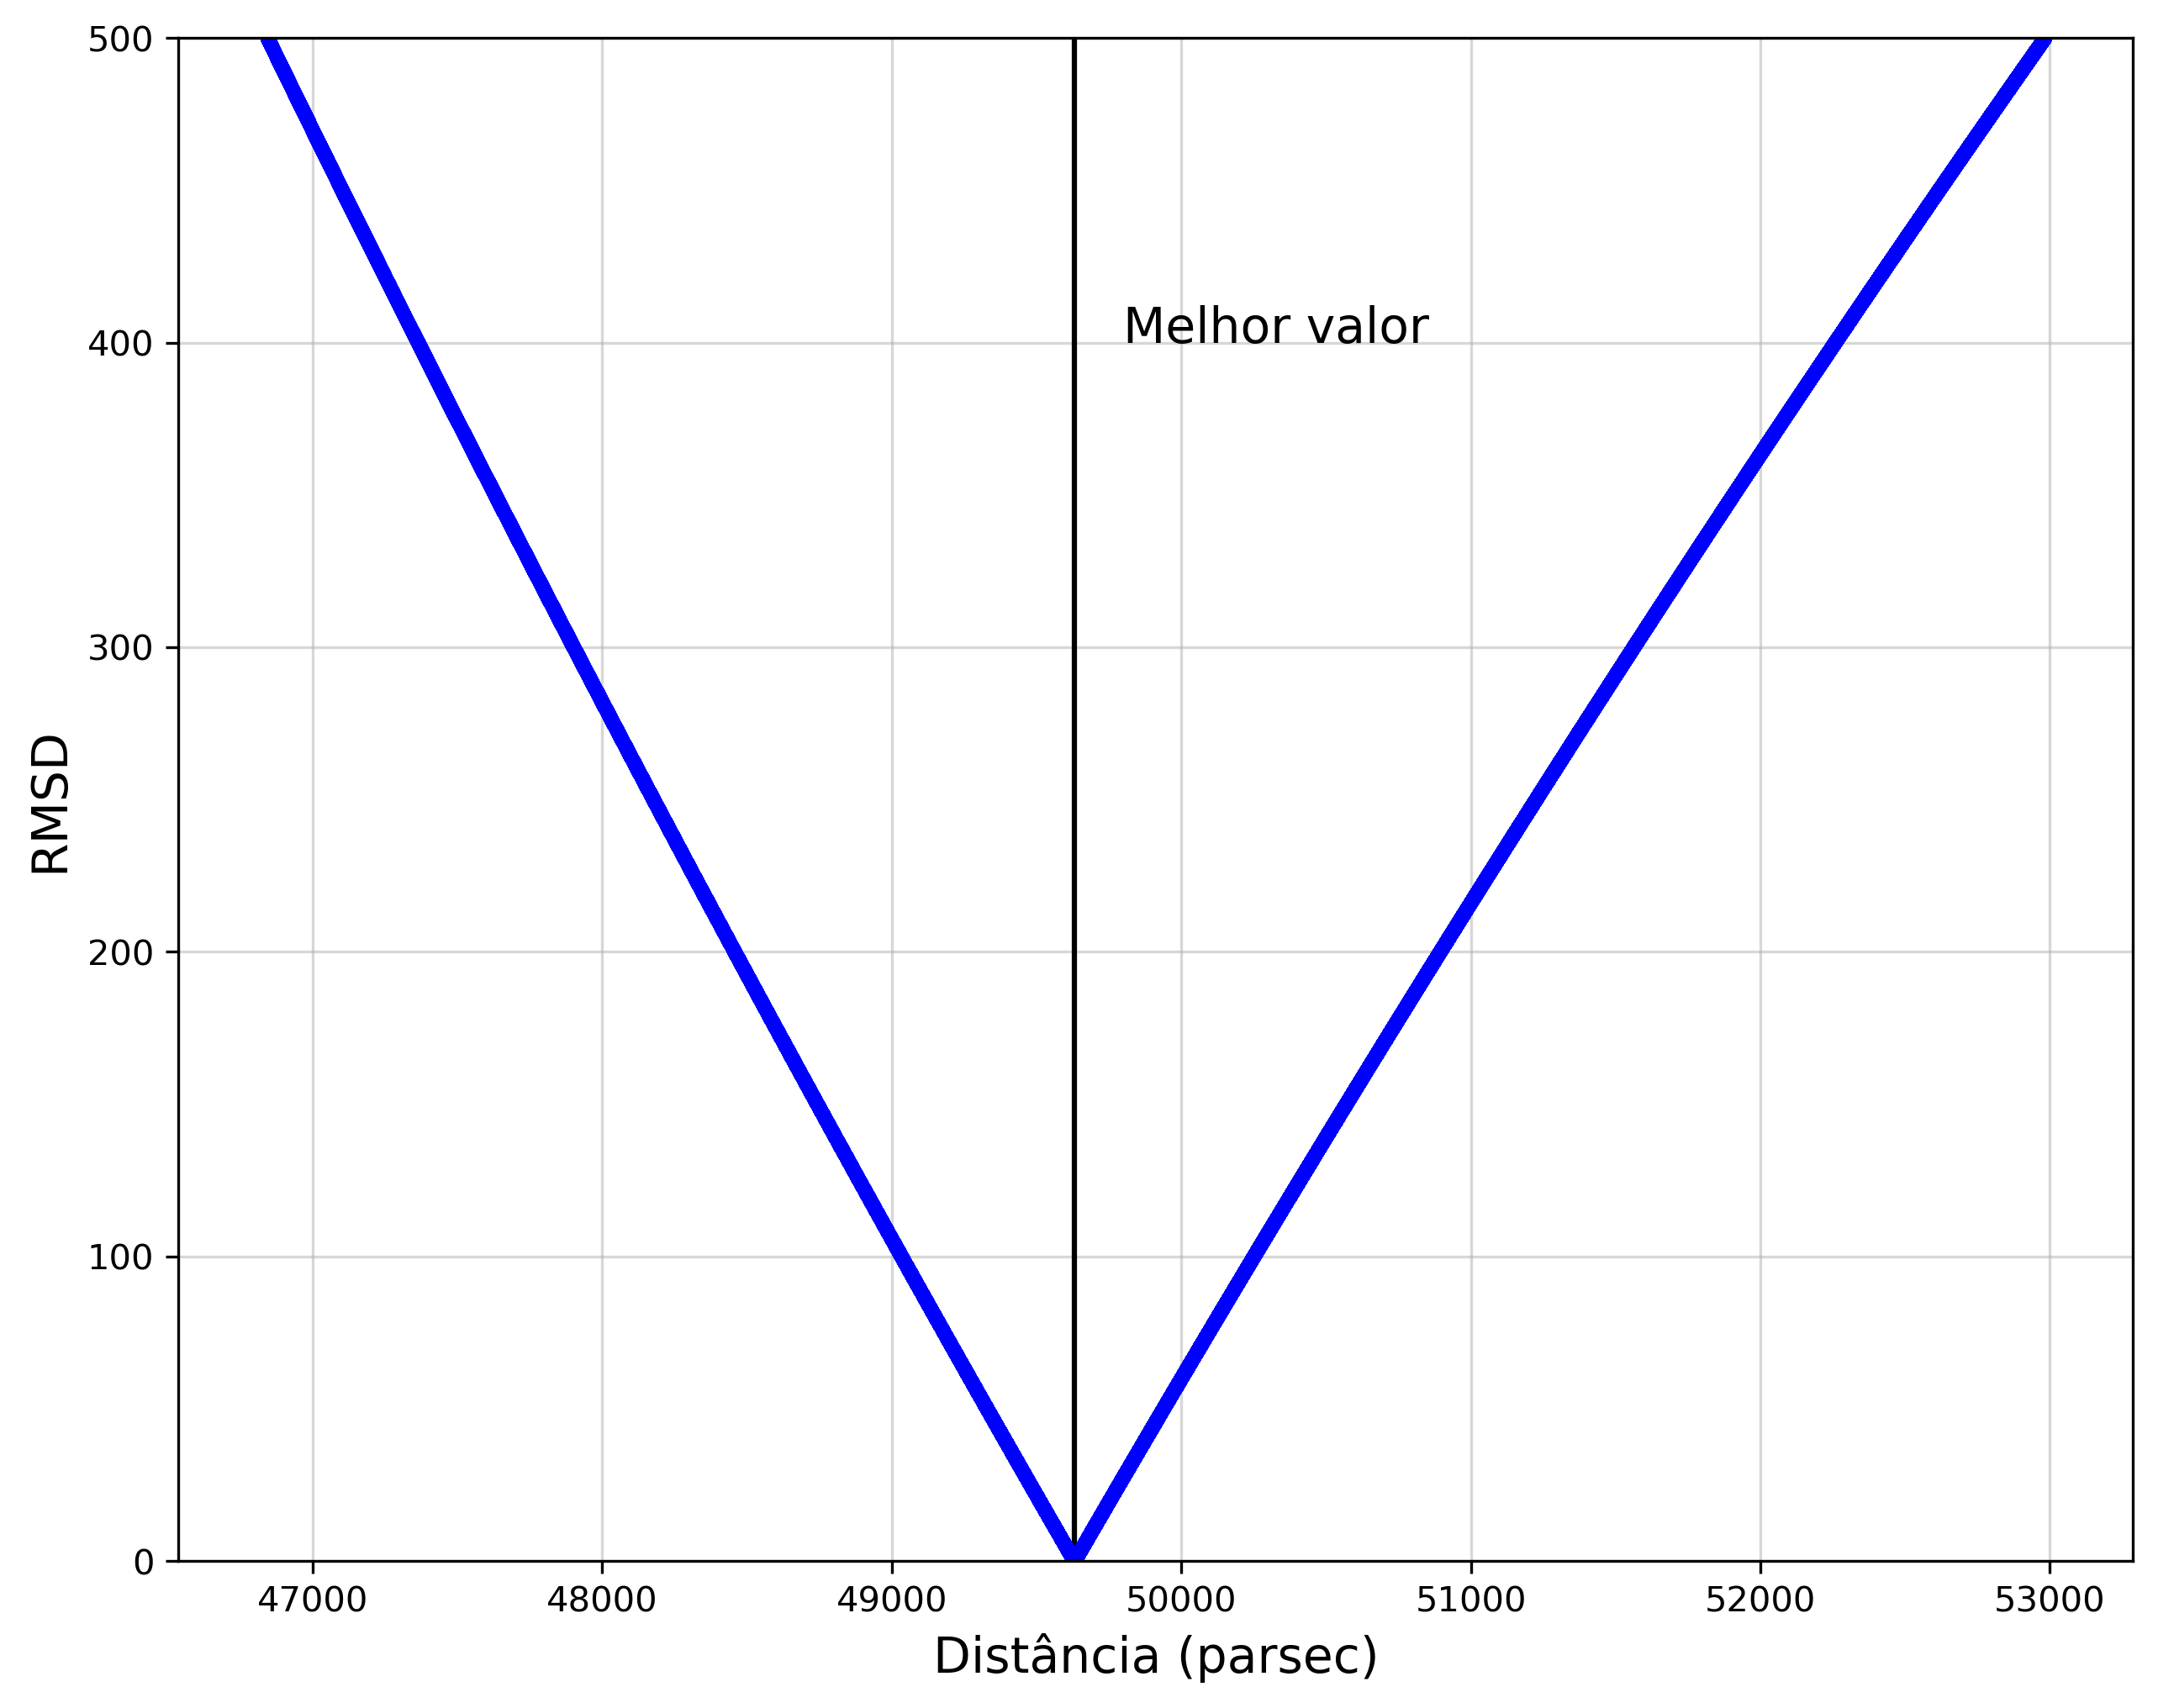

In [494]:
plt.figure(figsize = (10,8), dpi = 300)
plt.grid(True, alpha = 0.5)
plt.plot(post_[:,0], post_[:,1], 'b.')
plt.vlines(d, 0, 500, color = 'black')
plt.ylim(0, 500)
plt.text(49800, 400, r'Melhor valor', fontsize = 14)
plt.xlabel('Distância (parsec)', fontsize = 14)
plt.ylabel('RMSD', fontsize = 14)
plt.savefig('/home/pedroc/Documentos/pedro/TCC/ImagensCodigo/DRMSD.pdf')